## Script to parse behavioral data from pickle files

The purpose of this notebook is to parse the behavioral data in the appropriate pickle files into a format that is easily usable for analysis and plotting.

The pickle files for each animal contain dictionaries where the keys are session names and the values are lists of trials where every trial is a dictionary of this form:

```            trial = {
                'trial_num': 347,
                'stim_presentation_time': 1134567, # in microseconds
                'behavior_outcome_time': 1734567, # in microseconds
                'reaction_time': 600000, # in microseconds
                'behavior_outcome': 'success', # can be 'success', 'failure' or 'ignore'
                'BlobIdentityIdx': 1, # can be 1 or 2
            }
```

Continue below for how these data will be transformed. Make sure to run these cells in order.

### Dependencies

In [1]:
from __future__ import division
import os
import math
import copy
import random
import scipy
from pylab import figure
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymworks
import pickle
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline

/home/rodrigo/miniconda3/envs/strategic/lib/python2.7/site-packages/pymworks/protocol/__init__.py:15: UserWarning: networkx is required for pymworks.protocols.states
  warnings.warn('networkx is required for pymworks.protocols.states')


### Functions  and parameters needed to parse the pickle files

##### Parameters for running parsing

In [2]:
bootstrap_iterations = 100 # choose number of bootstrap iterations for calculating performance error
wiggle_session_indices = False # for binning data over normalized session time. if True adds random noise to session_indices so they don't completely overlap if same number of sessions, etc

##### Location of files

In [3]:
# filepaths of data to analyze

# regular stim learning
fp_AK_AL = '_pickledata/AK_and_AL_Cohorts/10fullcross_experiment_with_ignores/canonical_size_deptrotrl_10fullcross/pickle_files_by_session/'

# regular stim learning only canonical
fp_AN = '_pickledata/AN_Cohort/canonical_only_with_ignores/pickle_files_by_session/'

# regular no min RT
fp_nominrt = '_pickledata/AK_Cohort/6_fullcrossnominrt_with_ignores/pickle_files_by_session/'

# stimB learning
fp_stimB_base = '_pickledata/AL_and_AM_Cohorts/newshapes_experiment_with_ignores/6_baselinefullcross/180825_to_180913/pickle_files_by_session/'
fp_stimB = '_pickledata/AL_and_AM_Cohorts/newshapes_experiment_with_ignores/6_stimB/180914_to_181004/pickle_files_by_session/'

# transparent/dim
fp_transp_base = '_pickledata/AK_Cohort/transparency_experiment_with_ignores/fullcross_before_transparency/180620_to_180624/pickle_files_by_session/'
fp_transp = '_pickledata/AK_Cohort/transparency_experiment_with_ignores/transparency/180625_to_180830/pickle_files_by_session/'

# stimC learning with RT bounds
fp_stimC_rtbound_base = '_pickledata/AL_and_AM_Cohorts/newshapes_experiment_with_ignores/6_baselinefullcross/180825_to_180913/pickle_files_by_session/'
fp_stimC_rtbound = '_pickledata/AL_and_AM_Cohorts/rtbound_experiment_with_ignores/7_stimCrtbound/181022_to_181101/pickle_files_by_session/'

##### Defining functions

**Logic:**

Function ```open_pickle_files_and_analyze()``` takes in the ```filepath``` as input, finds the pickle files, and then runs the function ```get_data```

Function ```get_data()``` takes in ```animal_name``` and ```trials_grouped_by_session``` as input, and then outputs a dictionary with the parsed data of the following form:

``` data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'outcome_with_ignores_by_trial': outcome_with_ignores_by_trial,
    'iti_by_trial': iti_by_trial,
    'stim_id_by_trial': stim_id_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'beh_outcome_with_ignores_by_session': beh_outcome_with_ignores_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'iti_success_by_session': iti_success_by_session,
    'iti_failure_by_session': iti_failure_by_session,
    'stim_id_by_session': stim_id_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'pct_correct_bootstrap_error_by_session': pct_correct_bootstrap_error_by_session,
    'pct_ignore_by_session': pct_ignore_by_session,
    'pct_ignore_bootstrap_error_by_session': pct_ignore_bootstrap_error_by_session,
    'hitrate_falsealarms_by_session': hitrate_falsealarms_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_bootstrap_error_by_session': rt_success_bootstrap_error_by_session,
    'rt_failure_bootstrap_error_by_session': rt_failure_bootstrap_error_by_session,
    'rt_bootstrap_error_by_session': rt_bootstrap_error_by_session,
    'norm_session_indices': norm_session_indices
    }
```

where:

- ***animal_name*** : animal name  
- **rt_by_trial** : list of individual trial reaction times across all sessions in pickle file
- **outcome_by_trial** : list of individual trial outcomes ('success', 'failure') across all sessions in pickle file
- **outcome_with_ignores_by_trial** : list of individual trial outcomes ('success', 'failure', 'ignore') across all sessions in pickle file
- **iti_by_trial** : list of individual trial intertrial intervals across all sessions in pickle file
- **stim_id_by_trial** : list of individual trial stimulus identities (e.g. 0, 1) across all sessions in pickle file

- **beh_outcome_by_session** : dict where key = session, val = of individual trial outcomes ('success', 'failure')
- **beh_outcome_with_ignores_by_session** : dict where key = session, val = of individual trial outcomes ('success', 'failure', 'ignore')
- **rt_by_session** : dict where key = session, val = individual trial reaction times
- **rt_success_by_session** : dict where key = session, val = individual success trial reaction times
- **rt_failure_by_session** : dict where key = session, val = individual failure trial reaction times
- **iti_by_session** : dict where key = session, val = individual trial intertrial intervals
- **iti_success_by_session**: dict where key = session, val = individual trial intertrial intervals for previous correct/success trials
- **iti_failure_by_session**: dict where key = session, val = individual trial intertrial intervals for previous incorrect/failure trials
- **stim_id_by_session**: dict where key = session, val = individual trial stimulus identities (e.g. 0, 1) 

- **pct_correct_by_session** : dict where key = session, val = accuracy for that session
- **pct_correct_bootstrap_error_by_session** : dict where key = session, val = bootstrapped accuracy error for that session
- **pct_ignore_by_session** : dict where key = session, val = percent trials ignored for that session
- **pct_ignore_bootstrap_error_by_session** : dict where key = session, val = bootstrapped percent trials ignored error for that session
- **hitrate_falsealarms_by_session** : dict where key = session, val = dictionary with hitrate/falsealarm variables
    
- **avg_rt_success_by_session** : dict where key = session, val = avg RT for success trials in that session
- **avg_rt_failure_by_session** : dict where key = session, val = avg RT for failure trials in that session
- **rt_success_bootstrap_error_by_session** : dict where key = session, val = bootstrapped RT error for success trials in that session
- **rt_failure_bootstrap_error_by_session** : dict where key = session, val = bootstrapped RT error for failure trials in that session
- **rt_bootstrap_error_by_session** : dict where key = session, val = bootstrapped RT error for all success & failure trials in that session

- **norm_session_indices** : list of indices for sessions normalized from 0 to 1 (if animal takes 10 sessions to learn, then list contains [0.1, 0.2, 0.3,...,1.0]

the user can then use this data as she/he/they pleases. Some examples in the cells below.

In [4]:
def open_pickle_files_and_analyze(filepath):
    # get list of pickle file filenames in filepath
    dirs_list = [each for each in os.walk(filepath)]
    dirs_list = dirs_list[0][2] # capture only the pickle file filenames
    dirs_list = [i for i in dirs_list if i.startswith('.') == False] # remove hidden files

    # initiate dictionaries that will hold data
    results_by_session = {} # dictionary where keys will be animals, and values will be data
    sessions_by_animal = {} # dictionary where keys will be animals, and values will be session names

    # load the pickle files in the dirs_list one by one
    for filename in dirs_list:
        with open(filepath + filename, 'rb') as handle:
            data = pickle.load(handle)
        
        animal = data.keys()[0]# get animal name

        # notify the user of the sessions that are read
        print ' '
        print 'Read data from', animal, 'for...'
        print 'sessions:'
        for session in sorted(data[animal].keys()):
            print session

        # lump sessions from all phases into one dictionary
        trials_grouped_by_session = data[animal]
        
        # then analyze
        result_by_session = get_data(animal, trials_grouped_by_session) # analyze one animal at a time
        # store data in dictionaries
        results_by_session[animal] = result_by_session # add to results_by_session dictionary
        sessions_by_animal[animal] = result_by_session['avg_rt_success_by_session'].keys() # add sessions to sessions_by_animal dictionary

    return results_by_session

def get_data(animal_name, trials_grouped_by_session):
    
    # ~~~~~~~~~ Capture trial data ~~~~~~~~~
    
    data_by_trial = trial_data(trials_grouped_by_session)
    rt_by_trial = data_by_trial['rt_by_trial']
    rt_with_ignores_by_trial = data_by_trial['rt_with_ignores_by_trial']
    outcome_by_trial = data_by_trial['outcome_by_trial']
    outcome_with_ignores_by_trial = data_by_trial['outcome_with_ignores_by_trial']
    iti_by_trial = data_by_trial['iti_by_trial']
    stim_id_by_trial = data_by_trial['stim_id_by_trial']
    stim_id_with_ignores_by_trial = data_by_trial['stim_id_with_ignores_by_trial']
    
    # ~~~~~~~~~ Capture session data ~~~~~~~~~
    
    data_by_session = session_data(trials_grouped_by_session)
    beh_outcome_by_session = data_by_session['beh_outcome_by_session']
    beh_outcome_with_ignores_by_session = data_by_session['beh_outcome_with_ignores_by_session']
    rt_by_session = data_by_session['rt_by_session']
    rt_with_ignores_by_session = data_by_session['rt_with_ignores_by_session']
    rt_success_by_session = data_by_session['rt_success_by_session']
    rt_failure_by_session = data_by_session['rt_failure_by_session']
    iti_by_session = data_by_session['iti_by_session']
    iti_success_by_session = data_by_session['iti_success_by_session']
    iti_failure_by_session = data_by_session['iti_failure_by_session']
    stim_id_by_session = data_by_session['stim_id_by_session']
    stim_id_with_ignores_by_session = data_by_session['stim_id_with_ignores_by_session']
    
    # ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

    avg_rt_success_by_session = average_data_rt(rt_success_by_session)
    avg_rt_failure_by_session = average_data_rt(rt_failure_by_session)
    avg_rt_by_session = average_data_rt(rt_by_session)

    rt_success_bootstrap_error_by_session = bootstrap_error_rt(rt_success_by_session, bootstrap_iterations)
    rt_failure_bootstrap_error_by_session = bootstrap_error_rt(rt_failure_by_session, bootstrap_iterations)
    rt_bootstrap_error_by_session = bootstrap_error_rt(rt_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~ Performance analysis ~~~~~~~~~~
    
    pct_correct_by_session = pct_correct(beh_outcome_by_session)
    pct_correct_bootstrap_error_by_session = bootstrap_error_perf(beh_outcome_by_session, bootstrap_iterations)
    pct_ignore_by_session = pct_ignore(beh_outcome_with_ignores_by_session)
    pct_ignore_bootstrap_error_by_session = bootstrap_pct_ignore(beh_outcome_with_ignores_by_session, bootstrap_iterations)
    hitrate_falsealarms_by_session = hitrate_falsealarms(beh_outcome_by_session, rt_by_session, stim_id_by_session)
    
    # ~~~~~~~~~~~~ Session indices ~~~~~~~~~~~~

    norm_session_indices = [(x+1)/len(pct_correct_by_session) for x in range(len(pct_correct_by_session))]
    norm_session_indices = [(x+1)/len(avg_rt_success_by_session) for x in range(len(avg_rt_success_by_session))]

    
# need to update:

# rt_with_ignores_by_session   ~~ CHECK
# stim_id_with_ignores_by_session  ~~ CHECK

# outcome_with_ignores_by_trial
# rt_with_ignores_by_trial
# stim_id_with_ignores_by_trial  
    
    
    
    data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'rt_with_ignores_by_trial': rt_with_ignores_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'outcome_with_ignores_by_trial': outcome_with_ignores_by_trial,
    'iti_by_trial': iti_by_trial,
    'stim_id_by_trial': stim_id_by_trial,
    'stim_id_with_ignores_by_trial': stim_id_with_ignores_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'beh_outcome_with_ignores_by_session': beh_outcome_with_ignores_by_session,
    'rt_by_session': rt_by_session,
    'rt_with_ignores_by_session': rt_with_ignores_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'iti_success_by_session': iti_success_by_session,
    'iti_failure_by_session': iti_failure_by_session,
    'stim_id_by_session': stim_id_by_session,
    'stim_id_with_ignores_by_session': stim_id_with_ignores_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'pct_correct_bootstrap_error_by_session': pct_correct_bootstrap_error_by_session,
    'pct_ignore_by_session': pct_ignore_by_session,
    'pct_ignore_bootstrap_error_by_session': pct_correct_bootstrap_error_by_session,
    'hitrate_falsealarms_by_session': hitrate_falsealarms_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_bootstrap_error_by_session': rt_success_bootstrap_error_by_session,
    'rt_failure_bootstrap_error_by_session': rt_failure_bootstrap_error_by_session,
    'rt_bootstrap_error_by_session': rt_bootstrap_error_by_session,
    'norm_session_indices': norm_session_indices
    }

    return data

# ~~~~~~~~~ Capture trial data ~~~~~~~~~

# get trial data in big lists across all sessions
def trial_data(trials_grouped_by_session):
    # initialize lists for trial data across all sessions
    rt = []
    rt_with_ignores = []
    outcome = []
    outcome_with_ignores = []
    iti = []
    stim_id = []
    stim_id_with_ignores = []

    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            
            # only take into account the success or failure trials
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']:
               
                # append reaction time 
                rt.append(trials[trial_index]['reaction_time'])
                rt_with_ignores.append(trials[trial_index]['reaction_time'])
                # append behavior outcome
                outcome.append(trials[trial_index]['behavior_outcome'])
                outcome_with_ignores.append(trials[trial_index]['behavior_outcome'])
                # append stimulus identity
                stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                stim_id_with_ignores.append(trials[trial_index]['BlobIdentityIdx'])
                
                # intertrial interval analysis
                if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                    iti.append(iti_for_first_trial)
                elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                    next_stim_time = trials[trial_index]['stim_presentation_time']
                    response_time = trials[trial_index - 1]['behavior_outcome_time_with_ignores'] # previous trial behavior_outcome_time
                    inter_trial_interval = (next_stim_time - response_time)*0.001 # convert to ms
                    iti.append(inter_trial_interval)
                    
                    
            # ignore the 'ignore' trials for now
            elif trials[trial_index]['behavior_outcome_with_ignores'] == 'ignore':
                outcome_with_ignores.append(trials[trial_index]['behavior_outcome'])
                rt_with_ignores.append(trials[trial_index]['reaction_time'])
                stim_id_with_ignores.append(trials[trial_index]['BlobIdentityIdx'])
          
    data_by_trial = {
    'rt_by_trial': rt,
    'rt_with_ignores_by_trial': rt_with_ignores,
    'outcome_by_trial': outcome,
    'outcome_with_ignores_by_trial': outcome_with_ignores,
    'iti_by_trial': iti,
    'stim_id_by_trial': stim_id,
    'stim_id_with_ignores_by_trial': stim_id_with_ignores
    }
    return data_by_trial

# ~~~~~~~~~ Capture session data ~~~~~~~~~

def session_data(trials_grouped_by_session):
    # initialize dictionaries for trial data by sessions
    beh_outcome_by_session = {}
    beh_outcome_with_ignores_by_session = {}
    rt_by_session = {}
    rt_with_ignores_by_session = {}
    rt_success_by_session = {}
    rt_failure_by_session = {}
    iti_by_session = {}
    iti_success_by_session = {}
    iti_failure_by_session = {}
    stim_id_by_session = {}
    stim_id_with_ignores_by_session = {}
    
    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        session_rt_success = []
        session_rt_failure = []
        session_rt = []
        session_rt_with_ignores = []
        session_behavior_outcome = []
        session_behavior_outcome_with_ignores = []
        session_stim_id = []
        session_stim_id_with_ignores = []
        session_iti = []
        session_success_iti = []
        session_failure_iti = []
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            # behavior outcome and rt analysis
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']: 
                session_rt.append(trials[trial_index]['reaction_time'])
                session_rt_with_ignores.append(trials[trial_index]['reaction_time']) # WITH IGNORES
                session_behavior_outcome.append(trials[trial_index]['behavior_outcome']) 
                session_behavior_outcome_with_ignores.append(trials[trial_index]['behavior_outcome']) # WITH IGNORES
                session_stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                session_stim_id_with_ignores.append(trials[trial_index]['BlobIdentityIdx']) # WITH IGNORES
                if trials[trial_index]['behavior_outcome'] == 'success':
                    session_rt_success.append(trials[trial_index]['reaction_time'])
                elif trials[trial_index]['behavior_outcome'] == 'failure':
                    session_rt_failure.append(trials[trial_index]['reaction_time'])
            elif trials[trial_index]['behavior_outcome_with_ignores'] == 'ignore':
                session_behavior_outcome_with_ignores.append(trials[trial_index]['behavior_outcome_with_ignores']) # WITH IGNORES
                session_rt_with_ignores.append(trials[trial_index]['reaction_time_with_ignores']) # WITH IGNORES
                session_stim_id_with_ignores.append(trials[trial_index]['BlobIdentityIdx']) # WITH IGNORES
                
            # intertrial interval analysis
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']: # only do ITI analysis for success/failure trials
                if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                    session_iti.append(iti_for_first_trial)
                elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                    next_stim_time = trials[trial_index]['stim_presentation_time']
                    response_time = trials[trial_index - 1]['behavior_outcome_time_with_ignores'] # previous trial behavior_outcome_time
                    inter_trial_interval = (next_stim_time - response_time)*0.001 # convert to ms
                    session_iti.append(inter_trial_interval)

                    if trials[trial_index - 1]['behavior_outcome'] == 'success': # create separate list with previous success trial itis
                        session_success_iti.append(inter_trial_interval)
                    elif trials[trial_index - 1]['behavior_outcome'] == 'failure': # create separate list with previous failure trial itis
                        session_failure_iti.append(inter_trial_interval)

        beh_outcome_by_session[session] = session_behavior_outcome
        beh_outcome_with_ignores_by_session[session] = session_behavior_outcome_with_ignores
        rt_by_session[session] = session_rt
        rt_with_ignores_by_session[session] = session_rt_with_ignores
        rt_success_by_session[session] = session_rt_success
        rt_failure_by_session[session] = session_rt_failure
        iti_by_session[session] = session_iti
        iti_success_by_session[session] = session_success_iti
        iti_failure_by_session[session] = session_failure_iti
        stim_id_by_session[session] = session_stim_id
        stim_id_with_ignores_by_session[session] = session_stim_id_with_ignores
        
    data_by_session = {
    'beh_outcome_by_session': beh_outcome_by_session,
    'beh_outcome_with_ignores_by_session': beh_outcome_with_ignores_by_session,
    'rt_by_session': rt_by_session,
    'rt_with_ignores_by_session': rt_with_ignores_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'iti_success_by_session': iti_success_by_session,
    'iti_failure_by_session': iti_failure_by_session,
    'stim_id_by_session': stim_id_by_session,
    'stim_id_with_ignores_by_session': stim_id_with_ignores_by_session
    }
    
    return data_by_session

# ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

def average_data_rt(data_by_session):
    avg_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]
        # if the session was empty, insert a NaN
        if len(data) > 0:
            avg = np.mean(data)
        elif len(data) == 0:
            avg = float('nan')
        avg_by_session[session] = avg
    return avg_by_session


def bootstrap_error_rt(data_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]

        # print 'data'
        # print data
        # print ' '

        total_trials = len(data)
        
        # print 'len(data)'
        # print len(data)
        # print ' '
        if total_trials > 0:
            list_of_avg = []
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(data, total_trials)
                avg = np.mean(r)
                list_of_avg.append(avg)
            mean_error = np.std(list_of_avg)
            bootstrap_error_by_session[session] = mean_error
        else:
            bootstrap_error_by_session[session] = float('nan')
    return bootstrap_error_by_session

# ~~~~~~~~~~ Performance analysis ~~~~~~~~~~

def pct_correct(beh_out_by_session):
    pct_correct_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        counter = Counter(outcomes)
        if total_trials > 0:
            pct = counter['success'] / total_trials
        elif total_trials == 0:
            pct = float('nan')
        pct_correct_by_session[session] = pct
    return pct_correct_by_session


def bootstrap_error_perf(beh_out_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        list_of_pct = []
        if total_trials > 0:
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(outcomes, total_trials)
                counter = Counter(r)
                pct = counter['success'] / total_trials
                list_of_pct.append(pct)
            mean_error = np.std(list_of_pct)
        elif total_trials == 0:
            mean_error = float('nan')
        bootstrap_error_by_session[session] = mean_error
    return bootstrap_error_by_session

def pct_ignore(beh_out_with_ignores_by_session):
    pct_ignore_by_session = {}
    for session in sorted(beh_out_with_ignores_by_session.iterkeys()):
        outcomes = beh_out_with_ignores_by_session[session]
        total_trials = len(outcomes)
        counter = Counter(outcomes)
        if total_trials > 0:
            pct = counter['ignore'] / total_trials
        elif total_trials == 0:
            pct = float('nan')
        pct_ignore_by_session[session] = pct
    return pct_ignore_by_session

def bootstrap_pct_ignore(beh_out_with_ignores_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(beh_out_with_ignores_by_session.iterkeys()):
        outcomes = beh_out_with_ignores_by_session[session]
        total_trials = len(outcomes)
        list_of_pct = []
        if total_trials > 0:
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(outcomes, total_trials)
                counter = Counter(r)
                pct = counter['ignore'] / total_trials
                list_of_pct.append(pct)
            mean_pct_ignore = np.std(list_of_pct)
        elif total_trials == 0:
            mean_pct_ignore = float('nan')
        bootstrap_error_by_session[session] = mean_pct_ignore
    return bootstrap_error_by_session


def safe_division(x,y):
    try:
        return x/y
    except ZeroDivisionError:
        return 0
    
def hitrate_falsealarms(beh_out_by_session, rt_by_session, stim_id_by_session):
    hitrate_falsealarms_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        stim_ids = stim_id_by_session[session]
        possible_stim_ids = set(stim_ids)
        hitrate_falsealarms = dict.fromkeys(possible_stim_ids, 0)
        for stim_id in possible_stim_ids:
            hits = 0
            falsealarms = 0
            total_signal_stim = 0
            total_noise_stim = 0
            hits_rt = []
            falsealarms_rt = []
            total_signal_stim_rt = []
            total_noise_stim_rt = []
            for trial in range(len(stim_id_by_session[session])):
                if stim_id_by_session[session][trial] == stim_id:
                    total_signal_stim += 1
                    total_signal_stim_rt.append(rt_by_session[session][trial])
                    if beh_out_by_session[session][trial] == 'success':
                        hits += 1
                        hits_rt.append(rt_by_session[session][trial])
                elif stim_id_by_session[session][trial] != stim_id:
                    total_noise_stim += 1
                    total_noise_stim_rt.append(rt_by_session[session][trial])
                    if beh_out_by_session[session][trial] == 'failure':
                        falsealarms += 1
                        falsealarms_rt.append(rt_by_session[session][trial])
            hitrate_falsealarms[stim_id] = {
                'hits_signal_stim': hits,
                'total_signal_stim': total_signal_stim,
                'falsealarms_noise_stim': falsealarms,
                'total_noise_stim': total_noise_stim,
                'hit_rate_signal_stim': safe_division(hits, total_signal_stim),
                'falsealarm_rate_noise_stim': safe_division(falsealarms, total_noise_stim),
                'hits_signal_stim_rt': hits_rt,
                'total_signal_stim_rt': total_signal_stim_rt,
                'falsealarms_noise_stim_rt': falsealarms_rt,
                'total_noise_stim_rt': total_noise_stim_rt}
        hitrate_falsealarms_by_session[session] = hitrate_falsealarms
    return hitrate_falsealarms_by_session
                    

# ~~~~~~~~~~ Get relevant data ~~~~~~~~~~

def get_relevant_data(all_data_dict, relevant_data, all_sessions = True, sessions_to_count = 99, sessions_from_start = False):
    '''
    function that creates smaller dictionaries where animals are keys and values are lists of all data by session, or collapsed to one list
    
    input:
    all_data_dict:       dictionary outputted by open_pickle_files_and_analyze()
    relevant_data:       key for values in all_data_dict (string)
                           NOTE: this key should be for data organized by session, not by trial!
    all_sessions:        boolean var determining whether all sessions are included (True) or not (False)
                           if False, need to determine sessions_to_count, and sessions_from_start
    sessions_to_count:   number of sessions to count (i.e. 10 if want 10 sessions)
    sessions_from_start: boolean var determining whether sessions are counted from beginning of sorted list (True) or end (False)
                           e.g. if want only last 10 sessions, then: 
                           sessions_to_count = 10, sessions_from_start = False
    
    output:
    relevant_data_dict:  dictionary where key = animal, value = list of data from relevant_data key
                           where every list entry is from one session and sessions have been sorted
                           in the case of averages, such as "avg_rt_by_session", each list entry is a number
                           in the case of lists, such as "rt_by_session", each list entry is a list              
    '''
    relevant_data_dict = {}
    for animal in all_data_dict.iterkeys():
        if all_sessions == True:
            for session in sorted(all_data_dict[animal][relevant_data].keys()):
                try:
                    relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                except KeyError:
                    relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
        elif all_sessions == False:
            if sessions_from_start == True:
                for session in sorted(all_data_dict[animal][relevant_data].keys())[:sessions_to_count]:
                    try:
                        relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                    except KeyError:
                        relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
            elif sessions_from_start == False:
                for session in sorted(all_data_dict[animal][relevant_data].keys())[-sessions_to_count:]:
                    try:
                        relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                    except KeyError:
                        relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
    return relevant_data_dict

# ~~~~~~~~~~ Prepare inter-trial intervals ~~~~~~~~~~

def adjust_itis(iti_data, min_Drsi):
    '''
    adjust itis by subtracting minimum Drsi (Derr or Dcorr depending on type of iti) function
    '''
    iti_data_adj = {}
    for animal in iti_data.keys():
        for session in iti_data[animal]:
            try:
                iti_data_adj[animal].append([i - min_Drsi for i in session])
            except KeyError:
                iti_data_adj[animal] = [[i - min_Drsi for i in session]]
    return iti_data_adj

def avg_adjusted_itis(iti_data_adj, boundary = 2000):
    '''
    take mean of itis for all values under the boundary (don't count itis beyond the boundary') function
    '''
    iti_data_adj_mean = {}
    iti_data_adj_sem = {}
    iti_data_adj_median = {}
    for animal in iti_data_adj.keys():
        for session in iti_data_adj[animal]:
            session_below_boundary = [i for i in session if i < boundary]
            try:
                iti_data_adj_mean[animal].append(np.nanmean(session_below_boundary))
                iti_data_adj_median[animal].append(np.nanmedian(session_below_boundary))
                # regular sem
#                 iti_data_adj_sem[animal].append(stats.sem([i for i in session if i < boundary]))
            except KeyError:
                iti_data_adj_mean[animal] = [np.nanmean(session_below_boundary)]
                iti_data_adj_median[animal] = [np.nanmedian(session_below_boundary)]
#                 iti_data_adj_sem[animal] = [stats.sem([i for i in session if i < boundary])]

            # calculate bootstrap sem
            if len(session_below_boundary) > 0:
                list_of_avg = []
                for i in xrange(bootstrap_iterations):
                    r = np.random.choice(session_below_boundary, len(session_below_boundary))
                    avg = np.mean(r)
                    list_of_avg.append(avg)
                mean_error = np.std(list_of_avg)
                try:
                    iti_data_adj_sem[animal].append(mean_error)
                except KeyError:
                    iti_data_adj_sem[animal] = [mean_error]
            else:
                try:
                    iti_data_adj_sem[animal].append(float('nan'))
                except KeyError:
                    iti_data_adj_sem[animal] = [float('nan')]
    return iti_data_adj_mean, iti_data_adj_sem, iti_data_adj_median

# ~~~~~~~~~~ Convert reaction times to mean normalized decision times ~~~~~~~~~~

def convert_RTs_to_DTs(rts, iti_err = 0, t0 = 350, derr = 3136, with_itis = False):
    dts = {}
    for animal in rts.keys():
        if with_itis == True:
            for sesh in range(len(rts[animal])):
                try:
                    dts[animal].append((rts[animal][sesh] - t0)/(t0 + derr + iti_err[animal][sesh]))
                except KeyError:
                    dts[animal] = [(rts[animal][sesh] - t0)/(t0 + derr + iti_err[animal][sesh])]
        elif with_itis == False:
            dts[animal] = [(i - t0)/(t0 + derr) for i in rts[animal]]
    return dts

def calc_DT_err(rt_err, iti_err = 0, t0 = 350, derr = 3136, with_itis = False):
    dt_err = {}
    for animal in rt_err.keys():
        if with_itis == True:
            for sesh in range(len(rt_err[animal])):
                sum_sqrd_err = math.sqrt(rt_err[animal][sesh]**2 + iti_err[animal][sesh]**2)
                adj_err = sum_sqrd_err / (t0 + derr + iti_err[animal][sesh])
                try:
                    dt_err[animal].append(adj_err)
                except KeyError:
                    dt_err[animal] = [adj_err]
        elif with_itis == False:
            dt_err[animal] = [i/(t0 + derr) for i in rt_err[animal]]
        
    return dt_err

# ~~~~~~~~~~ Mesh data to create averages over learning ~~~~~~~~~~

def mesh_data(results, datakey = 'none'):
    '''
    input:
        results = dict where keys = animals, values = either dictionary with data or a list with data
        datakey = if not 'none', keys to dictionary with data
                  if none - values of results are lists
                  
    output:
        meshed_data = dict containing meshed data and meshed indices
    '''
    
    d = {}
    for animal in results.keys():
#         i = results[animal]['norm_session_indices'] # indexed session list comes pre-made from get_data_for_figure()
        if datakey == 'none':
            i = [(x+1)/len(results[animal]) for x in range(len(results[animal]))]
            y_data = results[animal]
        elif datakey != 'none':
            i = [(x+1)/len(results[animal][datakey]) for x in range(len(results[animal][datakey]))]
            y_data = results[animal][datakey]
        
        y = []
        
        if type(y_data) == dict:
            for session in sorted(y_data.iterkeys()):
                y.append(y_data[session])
            d[animal] = {'i': i, 'y': y}
        elif type(y_data) == list:
            y = y_data
            d[animal] = {'i': i, 'y': y}

    all_y = []
    all_i = []
    for a in d.iterkeys():
        # print 'key = ' + a
        if len(all_i) == 0:
            # print 'in if statement'
            all_i = d[a]['i']
            all_y = d[a]['y']
            # print all_i
            # print all_x
        else:
            # print 'in else statement'
            for j in range(len(d[a]['i'])):
                # print 'first for loop'
                for i in range(len(all_i)):
                    # print 'second for loop'
                    if all_i[i] >= d[a]['i'][j]:
                        #print 'first half'
                        #print all_x[:i]
                        all_i = all_i[:i] + [d[a]['i'][j]] + all_i[i:]
                        all_y = all_y[:i] + [d[a]['y'][j]] + all_y[i:]
                        # print all_i
                        # print all_x
                        break

    # print 'all_x:', all_x
    # print ' '
    # print 'all_i:', all_i

    meshed_data = {'all_i': all_i, 'all_y': all_y}

    return meshed_data

def avg_binned_data(meshed_data, n_bins):
    x_data = meshed_data['all_i']
    y_data = meshed_data['all_y']

    # if every animal has the exact number of sessions, add some noise to the indices to shuffle them:
    if wiggle_session_indices == True:
        x_data = [(i+(random.uniform(-1,1)/25)) for i in x_data]
    else:
        pass


    n_bins = n_bins
    
    x_n, x_bins, x_patches = plt.hist(x_data, bins = n_bins)

    # based on the bins for x_data, bin y_data
    # note that this code creates an extra bin at the end because there is one more bin value than bins
    # that is fixed with a for loop below
    y_bins = []
    for i in range(len(x_bins)):
        y_bin = []
        for j in range(len(x_data)):
            if i < (len(x_bins)-1):
                if (x_data[j] >= x_bins[i] and (x_data[j] < x_bins[i+1])):
                    y_bin.append(y_data[j])
                else:
                    pass
            elif i >= (len(x_bins)-1):
                if x_data[j] == (x_bins[i]):
                    y_bin.append(y_data[j])
                else:
                    pass
        y_bins.append(y_bin)

    # the above code creates an extra bin at the end
    # this for loop combines the last two bins
    for i in range(len(y_bins)):
        if i == (len(y_bins)-1):
            y_bins[i-1] = y_bins[i-1] + y_bins[i]
            y_bins.pop(i)
        else:
            pass

    # calculate the mean for values in every bin
    y_bins_mean = []
    y_bins_std = []
    y_bins_sem = []
    y_bins_median = []
    y_bins_25percentile = []
    y_bins_75percentile = []
    for i in y_bins:
#         if 0 in i:
#             i = [0.001 if x == 0 else x for x in i] # if there are zeroes, convert to small values to not have issues with averaging
#         else:
#             pass
        y_bins_mean.append(np.nanmean(i))
        y_bins_median.append(np.nanmedian(i))
        y_bins_25percentile.append(np.nanmedian(i) - np.nanpercentile(i, q = 25))
        y_bins_75percentile.append(np.nanpercentile(i, q = 75) - np.nanmedian(i))
        y_bins_std.append(np.nanstd(i))
        y_bins_sem.append(np.nanstd(i)/math.sqrt(len(i)))

    # calculate bin centers in order to plot the mean
    x_bincenters = [np.mean([x_bins[i],x_bins[i+1]]) for i in range(len(x_bins)-1)]

#     # Plot
#     xmin = -0.05 # indexed sessions from 0 to 1
#     xmax = 1.05
#     ymin = 0.4 # performance from 0 to 1
#     ymax = 1.0

#     fig = plt.figure()
#     plt.plot(x_data, y_data, 'r.', markersize=10, label=u'observations')
#     plt.errorbar(x_bincenters, y_bins_mean, yerr = y_bins_sem, fmt = 'bo-', label=u'binned average')
#     plt.xlabel('normalized session time')
#     plt.ylabel('mean performance $\pm$ sem')
#     plt.axis([xmin, xmax, ymin, ymax])
#     plt.legend(loc='lower right')
#     #plt.savefig('AK_Cohort_perf_binned_avg.pdf')
#     plt.close()
#     # plt.show()

    avg_binned_data = {
    'x_bins': x_bins,
    'x_bincenters': x_bincenters,
    'y_bins': y_bins,
    'y_bins_mean': y_bins_mean,
    'y_bins_std': y_bins_std,
    'y_bins_sem': y_bins_sem,
    'y_bins_median': y_bins_median,
    'y_bins_25percentile': y_bins_25percentile,
    'y_bins_75percentile': y_bins_75percentile
    }

    return avg_binned_data

# ~~~~~~~~~~ calculate OPC curve ~~~~~~~~~~

def calculate_opc():
    #this function returns a dictionary with two arrays with which to plot an optimal performance curve (OPC)

    #eta = (A/sigma)^2 (signal to noise ratio (drift rate to noise))
    #theta = | threshold / A | (ratio of threshold over drift rate)
    
    #make arrays with all possible values for eta and theta
    etas = np.arange(0.0001, 4, 0.01)
    thetas = np.arange(0.0001, 2.5, 0.01)
    e, th = np.meshgrid(etas, thetas)
    #calculate possible error rates with etas and thetas
    #pre-calculate 2*etas to reduce clutter and make equation legible
    e_x_2 = np.multiply(2,e)
    p_err = (1/(1 + np.exp(e_x_2*th)))
    #p_err is a huge array of arrays, but we only need the last array
    ind = len(p_err) - 1
    p_err = p_err[ind]
    #calculate mean normalized decision time as a function of p_err
    #pre-calculate components of equation to reduce clutter and make equation legible
    term1 = 1 / np.multiply(p_err, np.log((1-p_err)/p_err))
    term2 = 1 / (1 - np.multiply(2, p_err))
    mean_norm_dt = 1 / (term1 + term2)

    return {'p_err': p_err, 'mean_norm_dt': mean_norm_dt}

# ~~~~~~~~~~ plot data in OPC space ~~~~~~~~~~

# use when inputs are dictionaries with animals as keys
def opc_during_learning(perf, perf_err, dt, dt_err, filename = '%s_opc_during_learning.pdf'):

    error_rate = {}
    error_rate_err = {}
    mean_norm_dt = {}
    mean_norm_dt_err = {}
    for animal in perf.keys():
        error_rate[animal] = [1 - i for i in perf[animal]]
        error_rate_err[animal] = perf_err[animal]
        mean_norm_dt[animal] = dt[animal]
        mean_norm_dt_err[animal] = dt_err[animal]

        opc = calculate_opc()
        x_opc = opc['p_err']
        y_opc = opc['mean_norm_dt']

        x = error_rate[animal]
        y = mean_norm_dt[animal]
        xerr = error_rate_err[animal]
        yerr = mean_norm_dt_err[animal]

        xmin = 0.0
        xmax = 0.55
        ymin = 0.0
        ymax = 0.5

        c = plt.cm.magma(np.linspace(0.,0.95,len(x)))

        plt.close()
        plt.plot(x_opc, y_opc, label = 'opc')
        plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
        plt.axis([xmin, xmax, ymin, ymax])
        plt.xlabel('error rate $\pm$ sem')
        plt.ylabel('mean normalized DT $\pm$ sem')
        plt.title('%s learning trajectory' %animal)
        sns.despine()
        #plt.savefig(filename %animal)
    
       
# use with meshed data or individual animal data to only make one plot during learning
def opc_during_learning_from_list(perf, perf_err, dt, dt_err, listname = 'X Rats', filename = '_opc_during_learning.pdf'):

    error_rate = [1 - i for i in perf]
    error_rate_err = perf_err
    mean_norm_dt = dt
    mean_norm_dt_err = dt_err

    opc = calculate_opc()
    x_opc = opc['p_err']
    y_opc = opc['mean_norm_dt']

    x = error_rate
    y = mean_norm_dt
    xerr = error_rate_err
    yerr = mean_norm_dt_err

    xmin = 0.0
    xmax = 0.525
    ymin = 0.0
    ymax = 0.5

    c = plt.cm.magma(np.linspace(0.,0.95,len(x)))
#     c = plt.cm.spring(np.linspace(0,1,len(x)))

    plt.close()
    plt.plot(x_opc, y_opc, label = 'opc')
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
    plt.errorbar(x, y, color = 'k', marker = 's', linestyle = ' ', label = 'binned avg learning trajectory')
    plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('error rate $\pm$ sem')
    plt.ylabel('mean normalized DT $\pm$ sem')
    plt.title(listname + ' learning trajectory')
    sns.despine()
    #plt.savefig(filename)
    
# color code points by frac max rr
def opc_avg_colored_by_frac_max_rr(perf, perf_err, dt, dt_err, pct_max_rr, listname = 'X Rats', filename = '_opc_avg_across_sessions.pdf'):

    error_rate = []
    error_rate_err = []
    mean_norm_dt = []
    mean_norm_dt_err = []
    frac_max_rr = []
    for animal in perf.keys():
        error_rate.append(1 - perf[animal])
        error_rate_err.append(perf_err[animal])
        mean_norm_dt.append(dt[animal])
        mean_norm_dt_err.append(dt_err[animal])
        frac_max_rr.append(pct_max_rr[animal])

    opc = calculate_opc()
    x_opc = opc['p_err']
    y_opc = opc['mean_norm_dt']

    x = error_rate
    y = mean_norm_dt
    xerr = error_rate_err
    yerr = mean_norm_dt_err

    xmin = 0.0
    xmax = 0.5
    ymin = 0.0
    ymax = 0.5

    cmin = 0.90
    cmax = 1.0
    crange = cmax - cmin
    
    scaled_frac_max_rr = [(i - cmin)/crange for i in frac_max_rr] # rescale frac_max_rr to give color
#     cmap = plt.cm.Purples
    c = plt.cm.viridis(scaled_frac_max_rr)

    plt.close()
    plt.plot(x_opc, y_opc, label = 'opc')
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
    plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('error rate $\pm$ sem')
    plt.ylabel('mean normalized DT $\pm$ sem')
    plt.title(listname + 'average across sessions by frac max RR')
    sns.despine()
    #plt.savefig(filename)

# ~~~~~~~~~~ calculate percent max reward rate ~~~~~~~~~~


# function that calculates percent max reward rate
# takes one reaction time (in seconds) and one performance

def percent_max_rr(rt, perf, t0):
    '''
    rt = reaction time, **must be in seconds**
    ER = error rate, 1 - performance
    '''
    
    Dcorr = 6.370 # correct trial ITI in s
    Derr = -3.234 # additional penalty time (can be negative) in s
#     T0 = 0.200 # non-decision time in s
    T0 = t0 # determine t0 from outside function
    
    Dtot = Dcorr + T0 + Derr # mean iti for error trials, including non-decision time
    
    # DT = Dtot*0.45 ## NEED TO FIGURE THIS OUT
    DT = rt - T0
    # ER = 0.1 # measured error rate
    ER = 1 - perf
    
    if perf <= 0.5:
        ER = 1 - 0.501
    else:
        ER = 1 - perf
    
    RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr) # actual reward rate attained by the measured parameters
    
    Abar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
    
    # now compute the optimal reward rate given this SNR
    
    z = np.logspace(-10,1,1000) # test a bunch of different thresholds
    
    ERs = [1.0/(1 + np.exp(2*i*Abar)) for i in z]
    DTs = [i*np.tanh(i*Abar) for i in z]
    RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr) for i,j in zip(ERs, DTs)]
    RRoptimal = np.max(RRs)
    fraction_max_rr = RRactual/RRoptimal
    opportunity_cost = 1 - fraction_max_rr # percentage of optimal reward that they are sacrificing
    
    return fraction_max_rr

# function that calculates percent max reward rate
# takes one reaction time (in seconds) and one performance

def percent_max_rr_iti(rt, perf, t0 = 0.350, dcorr = 6.370, derr = 3.136, corr_iti = 0, err_iti = 0, with_itis = False):
    '''
    **all times must be in seconds**
    rt = reaction time
    ER = error rate, 1 - performance
    
    dcorr = experimental response-to-stimulus interval for previous correct trial
    derr = experimental response-to-stimulus interval for previous error trial
    corr_iti = extra voluntary ITI for a previous correct trial
    err_iti = extra voluntary ITI for a previous error trial
    with_itis = 
    
    '''
    
    # calculate DT and ER
    T0 = t0 # determine t0 from outside function
    DT = rt - T0
    ER = 1 - perf
    
#     if perf <= 0.5:
#         ER = 1 - 0.501
#     else:
#         ER = 1 - perf
    
    # calculate Dcorr, Derr
    if with_itis == True:
        Dcorr = dcorr + corr_iti # success time without iti or 300 ms blocking time, in seconds
        Derr = derr + err_iti # penalty time without iti or 300 ms blocking time, in seconds
        Derr_tilde = Derr - Dcorr # additional penalty time (negative when penalty time lesser than reward time) relative to Dcorr, in seconds
    elif with_itis == False:
        Dcorr = dcorr # correct trial ITI in s
        Derr = derr # additional penalty time (can be negative) in s
        Derr_tilde = Derr - Dcorr
    
    # calculate SNR (Abar) and possible ERs and DTs for that SNR
    Abar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
    z = np.logspace(-10,1,1000) # test a bunch of different thresholds
    ERs = [1.0/(1 + np.exp(2*i*Abar)) for i in z]
    DTs = [i*np.tanh(i*Abar) for i in z]
    
    # calculate actual RR and possible RRs for that SNR
    if with_itis == True:
        
        # testing new RR formula...
        RRactual = (1 - ER) / (DT + (1 - ER)*Dcorr + T0 + ER*Derr)
#         RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr_tilde) # actual reward rate attained by the measured parameters
        
        # calculate RRs with extra voluntary ITIs
#         RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr_tilde) for i,j in zip(ERs, DTs)]
        # calculate RRs without extra voluntary ITIs
        RRs = [(1 - i)/(j + (1 - i)*dcorr + T0 + i*(derr)) for i,j in zip(ERs, DTs)] # more evident RR formula
#         RRs = [(1 - i)/(j + dcorr + T0 + i*(derr - dcorr)) for i,j in zip(ERs, DTs)]
        
        
    elif with_itis == False:
        
        # testing new RR formula...
        RRactual = (1 - ER) / (DT + (1 - ER)*Dcorr + T0 + ER*Derr) # actual reward rate attained by the measured parameters
#         RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr_tilde) # actual reward rate attained by the measured parameters
        
        RRs = [(1 - i)/(j + (1 - i)*Dcorr + T0 + i*(Derr)) for i,j in zip(ERs, DTs)] # more evident RR formula
#         RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr) for i,j in zip(ERs, DTs)]
    
    # now compute the optimal reward rate given this SNR
    RRoptimal = np.max(RRs)
    RRoptimal_ind = np.argmax(RRs) # index of max RR
    
    ERoptimal = ERs[RRoptimal_ind] # use index of max RR to get optimal ER given Abar (SNR)
    PERFoptimal = 1 - ERoptimal
    
    DToptimal = DTs[RRoptimal_ind] # use index of max RR to get optimal DT given Abar (SNR)
    DToptimal_norm = DToptimal / (T0 + Derr)
    RToptimal = DToptimal + T0
    
    fraction_max_rr = RRactual/RRoptimal
    opportunity_cost = 1 - fraction_max_rr # percentage of optimal reward that they are sacrificing
    
    return {'fraction_max_rr': fraction_max_rr,
            'opportunity_cost': opportunity_cost,
            'Abar': Abar,
            'ERs': ERs,
            'DTs': DTs,
            'RRs': RRs,
            'RRoptimal': RRoptimal,
            'ERoptimal': ERoptimal,
            'PERFoptimal': PERFoptimal,
            'DToptimal': DToptimal,
            'RToptimal': RToptimal}

# average reaction times by quantiles
# for one subject at a time
# after vincentizing the subjects may be averaged

def vincentize_RTs(data, bins = 10):

    # sort data 
    data_sorted = sorted(data)

    # determine number of trials per bin
    n_per_bin = len(data)/bins
    n_per_bin = int(math.floor(n_per_bin))

    # perform Vincent averaging (vincentize) on RTs and ERs
    vin_RTs = []
    vin_RTs_sem = []
    bin_sizes = []
    bin_edges_RTs = []
    for current_bin in range(1,(bins+1)):
#         print 'current_bin =', current_bin
        if current_bin == 1:
#             print '  var:', var[0:current_bin*n_per_bin]
            vin_RTs.append(np.mean(data_sorted[0:current_bin*n_per_bin]))
            vin_RTs_sem.append(np.std(data_sorted[0:current_bin*n_per_bin])/math.sqrt(len(data_sorted[0:current_bin*n_per_bin])))
            bin_sizes.append(len(data_sorted[0:current_bin*n_per_bin]))
            bin_edges_RTs.append(data_sorted[0])
        elif 1 < current_bin < bins:
#             print '  var:', var[(current_bin-1)*n_per_bin:current_bin*n_per_bin]
            vin_RTs.append(np.mean(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin]))
            vin_RTs_sem.append(np.std(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin])/math.sqrt(len(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin])))
            bin_sizes.append(len(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin]))
            bin_edges_RTs.append(data_sorted[(current_bin-1)*n_per_bin])
        elif current_bin == bins:
#             print '  var:', var[(current_bin-1)*n_per_bin:-1]
            vin_RTs.append(np.mean(data_sorted[(current_bin-1)*n_per_bin:]))
            vin_RTs_sem.append(np.std(data_sorted[(current_bin-1)*n_per_bin:])/math.sqrt(len(data_sorted[(current_bin-1)*n_per_bin:])))
            bin_sizes.append(len(data_sorted[(current_bin-1)*n_per_bin:]))
            bin_edges_RTs.append(data_sorted[-1])

    return {'vin_RTs': vin_RTs,
            'vin_RTs_sem': vin_RTs_sem,
            'bin_sizes': bin_sizes,
            'bin_edges_RTs': bin_edges_RTs}

### Run the parsing

Below, the ```results``` dictionary will hold all the results for all the animals present in the pickle files in ```filepath```.

Run the cell below to populate ```results```.

In [5]:
# regular stim learning with ignores
results_AK_AL = open_pickle_files_and_analyze(fp_AK_AL)

 
Read data from AK9 for...
sessions:
AK9_170614.mwk
AK9_170615.mwk
AK9_170616.mwk
AK9_170617.mwk
AK9_170619.mwk
AK9_170620.mwk
AK9_170621.mwk
AK9_170622.mwk
AK9_170623.mwk
AK9_170627.mwk
AK9_170628.mwk
AK9_170629.mwk
AK9_170630.mwk
AK9_170711.mwk
AK9_170712.mwk
AK9_170713.mwk
AK9_170714.mwk
AK9_170718.mwk
AK9_170719.mwk
AK9_170720.mwk
AK9_170721.mwk
AK9_170724.mwk
AK9_170725.mwk
AK9_170726.mwk
AK9_170727.mwk
AK9_170728.mwk
AK9_170801.mwk
AK9_170802.mwk
AK9_170803.mwk
AK9_170804.mwk
AK9_170807.mwk
 
Read data from AK10 for...
sessions:
AK10_170614.mwk
AK10_170615.mwk
AK10_170616.mwk
AK10_170617.mwk
AK10_170619.mwk
AK10_170620.mwk
AK10_170621.mwk
AK10_170622.mwk
AK10_170623.mwk
AK10_170627.mwk
AK10_170628.mwk
AK10_170629.mwk
AK10_170629b.mwk
AK10_170630.mwk
AK10_170711.mwk
AK10_170712.mwk
AK10_170713.mwk
AK10_170714.mwk
AK10_170718.mwk
AK10_170719.mwk
AK10_170720.mwk
AK10_170721.mwk
AK10_170724.mwk
AK10_170724b.mwk
AK10_170725.mwk
AK10_170726.mwk
AK10_170727.mwk
AK10_170728.mwk
AK10_170

In [6]:
results_AN = open_pickle_files_and_analyze(fp_AN)

 
Read data from AN1 for...
sessions:
AN1_180318.mwk
AN1_180319.mwk
AN1_180320.mwk
AN1_180327.mwk
AN1_180328.mwk
AN1_180329.mwk
AN1_180330.mwk
AN1_180331.mwk
AN1_180402.mwk
AN1_180403.mwk
AN1_180404.mwk
AN1_180405.mwk
AN1_180406.mwk
AN1_180410.mwk
AN1_180411.mwk
AN1_180412.mwk
AN1_180413.mwk
AN1_180414.mwk
AN1_180415.mwk
AN1_180416.mwk
AN1_180417.mwk
AN1_180418.mwk
AN1_180419.mwk
AN1_180420.mwk
 
Read data from AN2 for...
sessions:
AN2_180318.mwk
AN2_180319.mwk
AN2_180320.mwk
AN2_180327.mwk
AN2_180328.mwk
AN2_180329.mwk
AN2_180330.mwk
AN2_180331.mwk
AN2_180402.mwk
AN2_180403.mwk
AN2_180404.mwk
AN2_180405.mwk
AN2_180406.mwk
AN2_180410.mwk
AN2_180411.mwk
AN2_180412.mwk
AN2_180413.mwk
AN2_180414.mwk
AN2_180415.mwk
AN2_180416.mwk
AN2_180417.mwk
AN2_180418.mwk
AN2_180419.mwk
AN2_180420.mwk
 
Read data from AN3 for...
sessions:
AN3_180318.mwk
AN3_180319.mwk
AN3_180320.mwk
AN3_180327.mwk
AN3_180328.mwk
AN3_180329.mwk
AN3_180330.mwk
AN3_180331.mwk
AN3_180402.mwk
AN3_180403.mwk
AN3_180404.mwk
A

In [7]:
results_nominrt = open_pickle_files_and_analyze(fp_nominrt)

 
Read data from AK10 for...
sessions:
AK10_181002nominrt.mwk
AK10_181003nominrt.mwk
AK10_181004nominrt.mwk
 
Read data from AK11 for...
sessions:
AK11_181002nominrt.mwk
AK11_181003nominrt.mwk
AK11_181004nominrt.mwk
 
Read data from AK12 for...
sessions:
AK12_181002nominrt.mwk
AK12_181003nominrt.mwk
AK12_181004nominrt.mwk
 
Read data from AK1 for...
sessions:
AK1_181002nominrt.mwk
AK1_181003nominrt.mwk
AK1_181004nominrt.mwk
 
Read data from AK2 for...
sessions:
AK2_181002nominrt.mwk
AK2_181003nominrt.mwk
AK2_181004nominrt.mwk
 
Read data from AK3 for...
sessions:
AK3_181002nominrt.mwk
AK3_181003nominrt.mwk
AK3_181004nominrt.mwk
 
Read data from AK5 for...
sessions:
AK5_181002nominrt.mwk
AK5_181003nominrt.mwk
AK5_181004nominrt.mwk
 
Read data from AK6 for...
sessions:
AK6_181002nominrt.mwk
AK6_181003nominrt.mwk
AK6_181004nominrt.mwk
 
Read data from AK7 for...
sessions:
AK7_181002nominrt.mwk
AK7_181003nominrt.mwk
AK7_181004nominrt.mwk


In [8]:
results_stimB_base = open_pickle_files_and_analyze(fp_stimB_base)

 
Read data from AL13 for...
sessions:
AL13_180825.mwk
AL13_180826.mwk
AL13_180827.mwk
AL13_180828.mwk
AL13_180829.mwk
AL13_180830.mwk
AL13_180831.mwk
AL13_180912.mwk
AL13_180913.mwk
 
Read data from AL14 for...
sessions:
AL14_180825.mwk
AL14_180826.mwk
AL14_180827.mwk
AL14_180828.mwk
AL14_180829.mwk
AL14_180830.mwk
AL14_180831.mwk
AL14_180912.mwk
AL14_180913.mwk
 
Read data from AL15 for...
sessions:
AL15_180825.mwk
AL15_180826.mwk
AL15_180827.mwk
AL15_180828.mwk
AL15_180829.mwk
AL15_180830.mwk
AL15_180831.mwk
AL15_180912.mwk
AL15_180913.mwk
 
Read data from AL16 for...
sessions:
AL16_180825.mwk
AL16_180826.mwk
AL16_180827.mwk
AL16_180828.mwk
AL16_180829.mwk
AL16_180830.mwk
AL16_180831.mwk
AL16_180912.mwk
AL16_180913.mwk
 
Read data from AL1 for...
sessions:
AL1_180825.mwk
AL1_180826.mwk
AL1_180827.mwk
AL1_180828.mwk
AL1_180829.mwk
AL1_180830.mwk
AL1_180831.mwk
AL1_180912.mwk
AL1_180913.mwk
 
Read data from AL2 for...
sessions:
AL2_180825.mwk
AL2_180826.mwk
AL2_180827.mwk
AL2_180828.m

In [9]:
results_stimB = open_pickle_files_and_analyze(fp_stimB)

 
Read data from AL13 for...
sessions:
AL13_180914stimB.mwk
AL13_180915stimB.mwk
AL13_180916stimB.mwk
AL13_180917stimB.mwk
AL13_180918stimB.mwk
AL13_180919stimB.mwk
AL13_180920stimB.mwk
AL13_180921stimB.mwk
AL13_180925stimB.mwk
AL13_180926stimB.mwk
AL13_180927stimB.mwk
AL13_181002stimB.mwk
AL13_181003stimB.mwk
AL13_181004stimB.mwk
 
Read data from AL14 for...
sessions:
AL14_180914stimB.mwk
AL14_180915stimB.mwk
AL14_180916stimB.mwk
AL14_180917stimB.mwk
AL14_180918stimB.mwk
AL14_180919stimB.mwk
AL14_180920stimB.mwk
AL14_180921stimB.mwk
AL14_180925stimB.mwk
AL14_180926stimB.mwk
AL14_180927stimB.mwk
AL14_181002stimB.mwk
AL14_181003stimB.mwk
AL14_181004stimB.mwk
 
Read data from AL15 for...
sessions:
AL15_180914stimB.mwk
AL15_180915stimB.mwk
AL15_180916stimB.mwk
AL15_180917stimB.mwk
AL15_180918stimB.mwk
AL15_180919stimB.mwk
AL15_180920stimB.mwk
AL15_180921stimB.mwk
AL15_180925stimB.mwk
AL15_180926stimB.mwk
AL15_180927stimB.mwk
AL15_181002stimB.mwk
AL15_181003stimB.mwk
AL15_181004stimB.mwk
 

In [10]:
results_transp_base = open_pickle_files_and_analyze(fp_transp_base)

 
Read data from AK10 for...
sessions:
AK10_180620.mwk
AK10_180621.mwk
AK10_180622.mwk
AK10_180623.mwk
AK10_180624.mwk
 
Read data from AK11 for...
sessions:
AK11_180620.mwk
AK11_180621.mwk
AK11_180622.mwk
AK11_180623.mwk
AK11_180624.mwk
 
Read data from AK12 for...
sessions:
AK12_180620.mwk
AK12_180621.mwk
AK12_180622.mwk
AK12_180623.mwk
AK12_180624.mwk
 
Read data from AK1 for...
sessions:
AK1_180620.mwk
AK1_180622.mwk
AK1_180623.mwk
AK1_180624.mwk
 
Read data from AK2 for...
sessions:
AK2_180620.mwk
AK2_180621.mwk
AK2_180622.mwk
AK2_180623.mwk
AK2_180624.mwk
 
Read data from AK3 for...
sessions:
AK3_180620.mwk
AK3_180621.mwk
AK3_180622.mwk
AK3_180623.mwk
AK3_180624.mwk
 
Read data from AK5 for...
sessions:
AK5_180620.mwk
AK5_180621.mwk
AK5_180622.mwk
AK5_180623.mwk
AK5_180624.mwk
 
Read data from AK6 for...
sessions:
AK6_180620.mwk
AK6_180621.mwk
AK6_180622.mwk
AK6_180623.mwk
AK6_180624.mwk
 
Read data from AK7 for...
sessions:
AK7_180621.mwk
AK7_180622.mwk
AK7_180623.mwk
AK7_180624

In [11]:
results_transp = open_pickle_files_and_analyze(fp_transp)

 
Read data from AK10_transparent0.1 for...
sessions:
AK10_180625transparency0.1.mwk
AK10_180626transparency0.1.mwk
AK10_180627transparency0.1.mwk
AK10_180628transparency0.1.mwk
AK10_180629transparency0.1.mwk
AK10_180824transparency0.1.mwk
AK10_180825transparency0.1.mwk
AK10_180827transparency0.1.mwk
AK10_180828transparency0.1.mwk
AK10_180829transparency0.1.mwk
AK10_180830transparency0.1.mwk
 
Read data from AK11_transparent0.0 for...
sessions:
AK11_180625transparency0.0.mwk
AK11_180626transparency0.0.mwk
AK11_180627transparency0.0.mwk
AK11_180628transparency0.0.mwk
AK11_180629transparency0.0.mwk
AK11_180824transparency0.0.mwk
AK11_180825transparency0.0.mwk
AK11_180827transparency0.0.mwk
AK11_180828transparency0.0.mwk
AK11_180829transparency0.0.mwk
AK11_180830transparency0.0.mwk
 
Read data from AK12_transparent0.1 for...
sessions:
AK12_180625transparency0.1.mwk
AK12_180626transparency0.1.mwk
AK12_180627transparency0.1.mwk
AK12_180628transparency0.1.mwk
AK12_180629transparency0.1.mwk
A

In [12]:
results_stimC_rtbound_base = open_pickle_files_and_analyze(fp_stimC_rtbound_base)

 
Read data from AL13 for...
sessions:
AL13_180825.mwk
AL13_180826.mwk
AL13_180827.mwk
AL13_180828.mwk
AL13_180829.mwk
AL13_180830.mwk
AL13_180831.mwk
AL13_180912.mwk
AL13_180913.mwk
 
Read data from AL14 for...
sessions:
AL14_180825.mwk
AL14_180826.mwk
AL14_180827.mwk
AL14_180828.mwk
AL14_180829.mwk
AL14_180830.mwk
AL14_180831.mwk
AL14_180912.mwk
AL14_180913.mwk
 
Read data from AL15 for...
sessions:
AL15_180825.mwk
AL15_180826.mwk
AL15_180827.mwk
AL15_180828.mwk
AL15_180829.mwk
AL15_180830.mwk
AL15_180831.mwk
AL15_180912.mwk
AL15_180913.mwk
 
Read data from AL16 for...
sessions:
AL16_180825.mwk
AL16_180826.mwk
AL16_180827.mwk
AL16_180828.mwk
AL16_180829.mwk
AL16_180830.mwk
AL16_180831.mwk
AL16_180912.mwk
AL16_180913.mwk
 
Read data from AL1 for...
sessions:
AL1_180825.mwk
AL1_180826.mwk
AL1_180827.mwk
AL1_180828.mwk
AL1_180829.mwk
AL1_180830.mwk
AL1_180831.mwk
AL1_180912.mwk
AL1_180913.mwk
 
Read data from AL2 for...
sessions:
AL2_180825.mwk
AL2_180826.mwk
AL2_180827.mwk
AL2_180828.m

In [13]:
results_stimC_rtbound = open_pickle_files_and_analyze(fp_stimC_rtbound)

 
Read data from AL13lower for...
sessions:
AL13_181022stimClowerbound.mwk
AL13_181023stimClowerbound.mwk
AL13_181024stimClowerbound.mwk
AL13_181025stimClowerbound.mwk
AL13_181026stimClowerbound.mwk
AL13_181029stimClowerbound.mwk
AL13_181030stimClowerbound.mwk
AL13_181031stimClowerbound.mwk
AL13_181101stimClowerbound.mwk
 
Read data from AL14upper for...
sessions:
AL14_181022stimCupperbound.mwk
AL14_181023stimCupperbound.mwk
AL14_181024stimCupperbound.mwk
AL14_181025stimCupperbound.mwk
AL14_181026stimCupperbound.mwk
AL14_181029stimCupperbound.mwk
AL14_181030stimCupperbound.mwk
AL14_181031stimCupperbound.mwk
AL14_181101stimCupperbound.mwk
 
Read data from AL15lower for...
sessions:
AL15_181022stimClowerbound.mwk
AL15_181023stimClowerbound.mwk
AL15_181024stimClowerbound.mwk
AL15_181025stimClowerbound.mwk
AL15_181026stimClowerbound.mwk
AL15_181029stimClowerbound.mwk
AL15_181030stimClowerbound.mwk
AL15_181031stimClowerbound.mwk
AL15_181101stimClowerbound.mwk
 
Read data from AL16lower for.

### Extract relevant data

create variables holding relevant data from every ```results``` data dictionary outputted from ```open_pickle_files_and_analyze()```

In [14]:
# ~~~~~~~~~  results_AK_AL  ~~~~~~~~~

# all sessions
data_dict = results_AK_AL
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

reg_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_pct_ignore = get_relevant_data(data_dict, 'pct_ignore_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_pct_ignore_err = get_relevant_data(data_dict, 'pct_ignore_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_rt_succ = get_relevant_data(data_dict,'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_all_rts = get_relevant_data(data_dict, 'rt_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# last 10 sessions
data_dict = results_AK_AL
all_sesh = False
sesh_to_count = 10
sesh_from_start = False

reg_perf_last10 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_perf_err_last10 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_rt_succ_last10 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_succ_err_last10 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail_last10 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail_err_last10 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all_last10 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all_err_last10 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_succ_rts_last10 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_fail_rts_last10 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_iti_succ_last10 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_fail_last10 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_all_last10 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# first 3 sessions
data_dict = results_AK_AL
all_sesh = False
sesh_to_count = 3
sesh_from_start = True

reg_perf_first3 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_perf_err_first3 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_rt_succ_first3 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_succ_err_first3 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail_first3 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail_err_first3 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all_first3 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all_err_first3 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_succ_rts_first3 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_fail_rts_first3 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_iti_succ_first3 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_fail_first3 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_all_first3 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [15]:
# ~~~~~~~~~  results_AN  ~~~~~~~~~

# all sessions
data_dict = results_AN
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

can_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_rt_succ = get_relevant_data(data_dict,'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_all_rts = get_relevant_data(data_dict, 'rt_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# last 2 sessions
all_sesh = False
sesh_to_count = 2
sesh_from_start = False

can_perf_last2 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_perf_err_last2 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_rt_succ_last2 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_succ_err_last2 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_fail_last2 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_fail_err_last2 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_all_last2 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_all_err_last2 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_succ_rts_last2 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_fail_rts_last2 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_iti_succ_last2 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_iti_fail_last2 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_iti_all_last2 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# last 5 sessions
all_sesh = False
sesh_to_count = 5
sesh_from_start = False

can_perf_last5 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_perf_err_last5 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_rt_succ_last5 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_succ_err_last5 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_fail_last5 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_fail_err_last5 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_all_last5 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_all_err_last5 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_succ_rts_last5 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_fail_rts_last5 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_iti_succ_last5 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_iti_fail_last5 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_iti_all_last5 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# last 10 sessions
data_dict = results_AN
all_sesh = False
sesh_to_count = 10
sesh_from_start = False

can_perf_last10 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_perf_err_last10 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_rt_succ_last10 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_succ_err_last10 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_fail_last10 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_fail_err_last10 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_all_last10 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_all_err_last10 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_succ_rts_last10 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_fail_rts_last10 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_iti_succ_last10 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_iti_fail_last10 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_iti_all_last10 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# first 3 sessions
data_dict = results_AN
all_sesh = False
sesh_to_count = 3
sesh_from_start = True

can_perf_first3 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_perf_err_first3 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_rt_succ_first3 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_succ_err_first3 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_fail_first3 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_fail_err_first3 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_all_first3 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_rt_all_err_first3 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_succ_rts_first3 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_fail_rts_first3 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

can_iti_succ_first3 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_iti_fail_first3 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
can_iti_all_first3 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [16]:
# ~~~~~~~~~  results_nominrt  ~~~~~~~~~

# all sessions (only 3 per animal)
data_dict = results_nominrt
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

nominrt_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
nominrt_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

nominrt_rt_succ = get_relevant_data(data_dict,'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
nominrt_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
nominrt_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
nominrt_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
nominrt_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
nominrt_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

nominrt_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
nominrt_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

nominrt_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
nominrt_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
nominrt_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [17]:
# ~~~~~~~~~  results_stimB_base  ~~~~~~~~~

# all sessions
data_dict = results_stimB_base
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

stimB_base_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_succ = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimB_base_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimB_base_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [18]:
# ~~~~~~~~~  results_stimB  ~~~~~~~~~

# all sessions
data_dict = results_stimB
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

stimB_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_succ = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimB_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_succ_rts_first2 = get_relevant_data(data_dict, 'rt_success_by_session', False, 2, True)
stimB_succ_rts_last2 = get_relevant_data(data_dict, 'rt_success_by_session', False, 2, False)

stimB_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [19]:
# ~~~~~~~~~  results_transp_base  ~~~~~~~~~

# all sessions
data_dict = results_transp_base
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

transp_base_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_base_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_base_rt_succ = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_base_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_base_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_base_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_base_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_base_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

transp_base_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_base_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

transp_base_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_base_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_base_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [20]:
# ~~~~~~~~~  results_transp  ~~~~~~~~~

# all sessions
data_dict = results_transp
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

transp_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_succ = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

transp_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

transp_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# first 2 sessions
data_dict = results_transp
all_sesh = False
sesh_to_count = 2
sesh_from_start = True

transp_perf_first2 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_perf_err_first2 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_succ_first2 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_succ_err_first2 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_fail_first2 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_fail_err_first2 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_all_first2 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_all_err_first2 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

transp_succ_rts_first2 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_fail_rts_first2 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

transp_iti_succ_first2 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_iti_fail_first2 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_iti_all_first2 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# last 2 sessions
data_dict = results_transp
all_sesh = False
sesh_to_count = 2
sesh_from_start = False

transp_perf_last2 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_perf_err_last2 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_succ_last2 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_succ_err_last2 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_fail_last2 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_fail_err_last2 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_all_last2 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_all_err_last2 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

transp_succ_rts_last2 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_fail_rts_last2 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

transp_iti_succ_last2 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_iti_fail_last2 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_iti_all_last2 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# last 5 sessions
data_dict = results_transp
all_sesh = False
sesh_to_count = 5
sesh_from_start = False

transp_perf_last5 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_perf_err_last5 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_succ_last5 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_succ_err_last5 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_fail_last5 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_fail_err_last5 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_all_last5 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_rt_all_err_last5 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

transp_succ_rts_last5 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_fail_rts_last5 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

transp_iti_succ_last5 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_iti_fail_last5 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
transp_iti_all_last5 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [21]:
# ~~~~~~~~~  results_stimC_rtbound_base  ~~~~~~~~~

# all sessions
data_dict = results_stimC_rtbound_base
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

stimC_rtbound_base_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_base_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_base_rt_succ = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_base_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_base_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_base_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_base_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_base_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimC_rtbound_base_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_base_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimC_rtbound_base_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_base_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_base_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [22]:
# ~~~~~~~~~  results_stimC_rtbound  ~~~~~~~~~

# all sessions
data_dict = results_stimC_rtbound
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

stimC_rtbound_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_rt_succ = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimC_rtbound_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimC_rtbound_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimC_rtbound_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

### Set Seaborn style

In [23]:
sns.set_style('ticks')

### Vincentized RTs during and after learning

In [24]:
# vincentize RTs
bins_ = 10

# ~~~~~~~~~~ learning versus after learning

reg_early_vin_RTs = {}
for animal in reg_succ_rts_first3.iterkeys():
    flat_data = [i for sublist in reg_succ_rts_first3[animal] for i in sublist]
    reg_early_vin_RTs[animal] = vincentize_RTs(flat_data, bins = bins_)
    
reg_late_vin_RTs = {}
for animal in reg_succ_rts_last10.iterkeys():
    flat_data = [i for sublist in reg_succ_rts_last10[animal] for i in sublist]
    reg_late_vin_RTs[animal] = vincentize_RTs(flat_data, bins = bins_)

# get mean and SEM

reg_early_vin_RTs_all = []
for animal in reg_early_vin_RTs.iterkeys():
    if animal not in ['AL12']: # AL12 never learned
        reg_early_vin_RTs_all.append(reg_early_vin_RTs[animal]['vin_RTs'])
#     plt.plot(reg_early_vin_RTs[animal]['vin_RTs'], color = 'grey', alpha = 0.1)
reg_early_vin_RTs_all_mean = np.mean(reg_early_vin_RTs_all, axis = 0)
reg_early_vin_RTs_all_sem = np.std(reg_early_vin_RTs_all, axis = 0)/math.sqrt(len(reg_early_vin_RTs_all))

reg_late_vin_RTs_all = []
for animal in reg_late_vin_RTs.iterkeys():
    if animal not in ['AL12']: # AL12 never learned
        reg_late_vin_RTs_all.append(reg_late_vin_RTs[animal]['vin_RTs'])
#     plt.plot(reg_late_vin_RTs[animal]['vin_RTs'], color = 'grey', alpha = 0.1)
reg_late_vin_RTs_all_mean = np.mean(reg_late_vin_RTs_all, axis = 0)
reg_late_vin_RTs_all_sem = np.std(reg_late_vin_RTs_all, axis = 0)/math.sqrt(len(reg_late_vin_RTs_all))

reg_early_late_diff_vin_RTs_all = []
for animal in reg_early_vin_RTs.iterkeys():
    if animal not in ['AL12']: # AL12 never learned
        reg_early_late_diff_vin_RTs_all.append(np.subtract(reg_early_vin_RTs[animal]['vin_RTs'], reg_late_vin_RTs[animal]['vin_RTs']))
#     plt.plot(reg_late_vin_RTs[animal]['vin_RTs'], color = 'grey', alpha = 0.1)
reg_early_late_diff_vin_RTs_all_mean = np.mean(reg_early_late_diff_vin_RTs_all, axis = 0)
reg_early_late_diff_vin_RTs_all_sem = np.std(reg_early_late_diff_vin_RTs_all, axis = 0)/math.sqrt(len(reg_early_late_diff_vin_RTs_all))

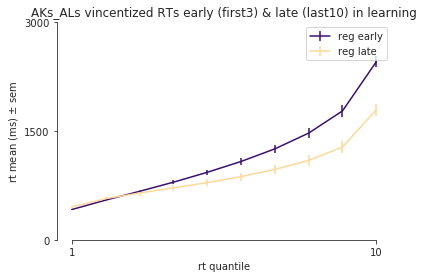

In [25]:
# compare regular early and late in learning

x1 = [i+1 for i in range(len(reg_early_vin_RTs_all_mean))]
y1 = reg_early_vin_RTs_all_mean
yerr1 = reg_early_vin_RTs_all_sem
label1 = 'reg early'
color1 = plt.cm.magma(50) #'black'

x2 = [i+1 for i in range(len(reg_late_vin_RTs_all_mean))]
y2 = reg_late_vin_RTs_all_mean
yerr2 = reg_late_vin_RTs_all_sem
label2 = 'reg late'
color2 = plt.cm.magma(235) #'gray'

# x3 = [i+1 for i in range(len(reg_early_late_diff_vin_RTs_all_mean))]
# y3 = reg_early_late_diff_vin_RTs_all_mean
# yerr3 = reg_early_late_diff_vin_RTs_all_sem
# label3 = 'reg early-late diff'
# color3 = 'black'

plt.errorbar(x = x1, y = y1, yerr = yerr1, color = color1, label = label1, alpha = 1)
plt.errorbar(x = x2, y = y2, yerr = yerr2, color = color2, label = label2, alpha = 1)
# plt.errorbar(x = x3, y = y3, yerr = yerr3, color = color3, label = label3, alpha = 0.5)
plt.yticks([0, 1500, 3000])
plt.xticks([1, 10])
plt.xlabel('rt quantile')
plt.ylabel('rt mean (ms) $\pm$ sem')
plt.title('AKs_ALs vincentized RTs early (first3) & late (last10) in learning')
plt.legend()
sns.despine(trim = True)
# #plt.savefig('AKs_ALs_vincentized_rts_early_late_in_learning.pdf')

In [26]:
# vincentize RTs
bins_ = 10

# ~~~~~~~~~~ learning versus after learning

stimB_early_vin_RTs = {}
for animal in stimB_succ_rts_first2.iterkeys():
    flat_data = [i for sublist in stimB_succ_rts_first2[animal] for i in sublist]
    stimB_early_vin_RTs[animal] = vincentize_RTs(flat_data, bins = bins_)
    
stimB_late_vin_RTs = {}
for animal in stimB_succ_rts_last2.iterkeys():
    flat_data = [i for sublist in stimB_succ_rts_last2[animal] for i in sublist]
    stimB_late_vin_RTs[animal] = vincentize_RTs(flat_data, bins = bins_)

# get mean and SEM

stimB_early_vin_RTs_all = []
for animal in stimB_early_vin_RTs.iterkeys():
    stimB_early_vin_RTs_all.append(stimB_early_vin_RTs[animal]['vin_RTs'])
#     plt.plot(stimB_early_vin_RTs[animal]['vin_RTs'], color = 'grey', alpha = 0.1)
stimB_early_vin_RTs_all_mean = np.mean(stimB_early_vin_RTs_all, axis = 0)
stimB_early_vin_RTs_all_sem = np.std(stimB_early_vin_RTs_all, axis = 0)/math.sqrt(len(stimB_early_vin_RTs_all))

stimB_late_vin_RTs_all = []
for animal in stimB_late_vin_RTs.iterkeys():
    stimB_late_vin_RTs_all.append(stimB_late_vin_RTs[animal]['vin_RTs'])
#     plt.plot(stimB_late_vin_RTs[animal]['vin_RTs'], color = 'grey', alpha = 0.1)
stimB_late_vin_RTs_all_mean = np.mean(stimB_late_vin_RTs_all, axis = 0)
stimB_late_vin_RTs_all_sem = np.std(stimB_late_vin_RTs_all, axis = 0)/math.sqrt(len(stimB_late_vin_RTs_all))

stimB_early_late_diff_vin_RTs_all = []
for animal in stimB_early_vin_RTs.iterkeys():
    stimB_early_late_diff_vin_RTs_all.append(np.subtract(stimB_early_vin_RTs[animal]['vin_RTs'], stimB_late_vin_RTs[animal]['vin_RTs']))
#     plt.plot(stimB_late_vin_RTs[animal]['vin_RTs'], color = 'grey', alpha = 0.1)
stimB_early_late_diff_vin_RTs_all_mean = np.mean(stimB_early_late_diff_vin_RTs_all, axis = 0)
stimB_early_late_diff_vin_RTs_all_sem = np.std(stimB_early_late_diff_vin_RTs_all, axis = 0)/math.sqrt(len(stimB_early_late_diff_vin_RTs_all))

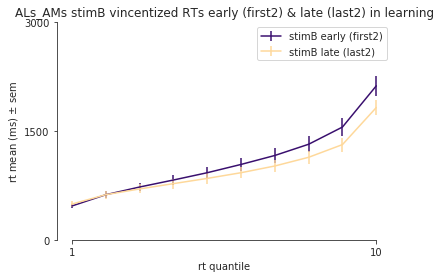

In [27]:
# compare stimB early and late in learning

x1 = [i+1 for i in range(len(stimB_early_vin_RTs_all_mean))]
y1 = stimB_early_vin_RTs_all_mean
yerr1 = stimB_early_vin_RTs_all_sem
label1 = 'stimB early (first2)'
color1 = plt.cm.magma(50) #'black'

x2 = [i+1 for i in range(len(stimB_late_vin_RTs_all_mean))]
y2 = stimB_late_vin_RTs_all_mean
yerr2 = stimB_late_vin_RTs_all_sem
label2 = 'stimB late (last2)'
color2 = plt.cm.magma(235) #'gray'

# x3 = [i+1 for i in range(len(stimB_early_late_diff_vin_RTs_all_mean))]
# y3 = stimB_early_late_diff_vin_RTs_all_mean
# yerr3 = stimB_early_late_diff_vin_RTs_all_sem
# label3 = 'stimB early-late diff'
# color3 = 'black'

plt.errorbar(x = x1, y = y1, yerr = yerr1, color = color1, label = label1, alpha = 1)
plt.errorbar(x = x2, y = y2, yerr = yerr2, color = color2, label = label2, alpha = 1)
# plt.errorbar(x = x3, y = y3, yerr = yerr3, color = color3, label = label3, alpha = 0.5)
plt.yticks([0, 1500, 3000])
plt.xticks([1, 10])
plt.xlabel('rt quantile')
plt.ylabel('rt mean (ms) $\pm$ sem')
plt.title('ALs_AMs stimB vincentized RTs early (first2) & late (last2) in learning')
plt.legend()
sns.despine(trim = True)
# #plt.savefig('ALs_AMs_stimB_vincentized_rts_early_late_in_learning.pdf')

In [28]:
# vincentize RTs
bins_ = 10

# ~~~~~~~~~~ learning versus after learning

transp_early_vin_RTs = {}
for animal in transp_succ_rts_first2.iterkeys():
    flat_data = [i for sublist in transp_succ_rts_first2[animal] for i in sublist]
    transp_early_vin_RTs[animal] = vincentize_RTs(flat_data, bins = bins_)
    
transp_late_vin_RTs = {}
for animal in transp_succ_rts_last2.iterkeys():
    flat_data = [i for sublist in transp_succ_rts_last2[animal] for i in sublist]
    transp_late_vin_RTs[animal] = vincentize_RTs(flat_data, bins = bins_)

# get mean and SEM

transp_early_vin_RTs_all = []
for animal in transp_early_vin_RTs.iterkeys():
    transp_early_vin_RTs_all.append(transp_early_vin_RTs[animal]['vin_RTs'])
#     plt.plot(transp_early_vin_RTs[animal]['vin_RTs'], color = 'grey', alpha = 0.1)
transp_early_vin_RTs_all_mean = np.mean(transp_early_vin_RTs_all, axis = 0)
transp_early_vin_RTs_all_sem = np.std(transp_early_vin_RTs_all, axis = 0)/math.sqrt(len(transp_early_vin_RTs_all))

transp_late_vin_RTs_all = []
for animal in transp_late_vin_RTs.iterkeys():
    transp_late_vin_RTs_all.append(transp_late_vin_RTs[animal]['vin_RTs'])
#     plt.plot(transp_late_vin_RTs[animal]['vin_RTs'], color = 'grey', alpha = 0.1)
transp_late_vin_RTs_all_mean = np.mean(transp_late_vin_RTs_all, axis = 0)
transp_late_vin_RTs_all_sem = np.std(transp_late_vin_RTs_all, axis = 0)/math.sqrt(len(transp_late_vin_RTs_all))

transp_early_late_diff_vin_RTs_all = []
for animal in transp_early_vin_RTs.iterkeys():
    transp_early_late_diff_vin_RTs_all.append(np.subtract(transp_early_vin_RTs[animal]['vin_RTs'], transp_late_vin_RTs[animal]['vin_RTs']))
#     plt.plot(transp_late_vin_RTs[animal]['vin_RTs'], color = 'grey', alpha = 0.1)
transp_early_late_diff_vin_RTs_all_mean = np.mean(transp_early_late_diff_vin_RTs_all, axis = 0)
transp_early_late_diff_vin_RTs_all_sem = np.std(transp_early_late_diff_vin_RTs_all, axis = 0)/math.sqrt(len(transp_early_late_diff_vin_RTs_all))

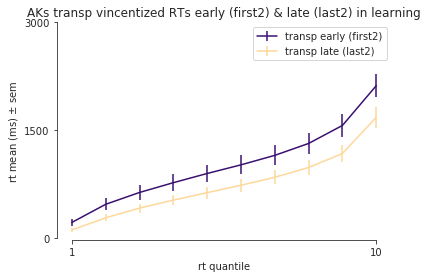

In [29]:
# compare transp early and late in learning

x1 = [i+1 for i in range(len(transp_early_vin_RTs_all_mean))]
y1 = transp_early_vin_RTs_all_mean
yerr1 = transp_early_vin_RTs_all_sem
label1 = 'transp early (first2)'
color1 = plt.cm.magma(50) #'black'

x2 = [i+1 for i in range(len(transp_late_vin_RTs_all_mean))]
y2 = transp_late_vin_RTs_all_mean
yerr2 = transp_late_vin_RTs_all_sem
label2 = 'transp late (last2)'
color2 = plt.cm.magma(235) #'gray'

# x3 = [i+1 for i in range(len(transp_early_late_diff_vin_RTs_all_mean))]
# y3 = transp_early_late_diff_vin_RTs_all_mean
# yerr3 = transp_early_late_diff_vin_RTs_all_sem
# label3 = 'transp early-late diff'
# color3 = 'black'

plt.errorbar(x = x1, y = y1, yerr = yerr1, color = color1, label = label1, alpha = 1)
plt.errorbar(x = x2, y = y2, yerr = yerr2, color = color2, label = label2, alpha = 1)
# plt.errorbar(x = x3, y = y3, yerr = yerr3, color = color3, label = label3, alpha = 0.5)
plt.yticks([0, 1500, 3000])
plt.xticks([1, 10])
plt.xlabel('rt quantile')
plt.ylabel('rt mean (ms) $\pm$ sem')
plt.title('AKs transp vincentized RTs early (first2) & late (last2) in learning')
plt.legend()
sns.despine(trim = True)
# #plt.savefig('AKs_transp_vincentized_rts_early_late_in_learning.pdf')

### OPC Plots

prepare data for OPC plotting

In [30]:
T0 = 160
Derr = 3136
Dcorr = 6370
boundary = 500
with_itis = False

reg_iti_succ_adj = adjust_itis(reg_iti_succ, Dcorr)
reg_iti_succ_adj_mean, reg_iti_succ_adj_sem, reg_iti_succ_adj_median = avg_adjusted_itis(reg_iti_succ_adj, boundary)

reg_iti_fail_adj = adjust_itis(reg_iti_fail, Derr)
reg_iti_fail_adj_mean, reg_iti_fail_adj_sem, reg_iti_fail_adj_median = avg_adjusted_itis(reg_iti_fail_adj, boundary)

reg_dt = convert_RTs_to_DTs(reg_rt_succ, reg_iti_fail_adj_mean, T0, Derr, with_itis)
reg_dt_err = calc_DT_err(reg_rt_succ_err, reg_iti_fail_adj_sem, T0, Derr, with_itis)

/home/rodrigo/miniconda3/envs/strategic/lib/python2.7/site-packages/ipykernel_launcher.py:518: RuntimeWarning: Mean of empty slice
/home/rodrigo/miniconda3/envs/strategic/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/rodrigo/miniconda3/envs/strategic/lib/python2.7/site-packages/ipykernel_launcher.py:513: RuntimeWarning: Mean of empty slice


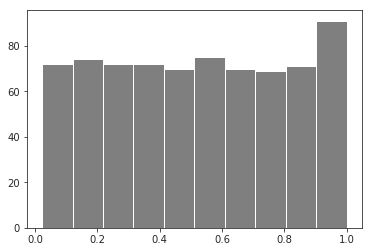

In [31]:
# mesh data

meshed_reg_rt = mesh_data(reg_rt_succ, 'none')
meshed_reg_dt = mesh_data(reg_dt, 'none')
meshed_reg_perf = mesh_data(reg_perf, 'none')
meshed_reg_pct_ignore = mesh_data(reg_pct_ignore, 'none')
meshed_reg_iti_err = mesh_data(reg_iti_fail_adj_mean, 'none')
meshed_reg_iti_corr = mesh_data(reg_iti_succ_adj_mean, 'none')
meshed_reg_iti_err_median = mesh_data(reg_iti_fail_adj_median, 'none')
meshed_reg_iti_corr_median = mesh_data(reg_iti_succ_adj_median, 'none')

meshed_reg_iti_err_raw = mesh_data(reg_iti_fail_adj, 'none')

n_bins = 10
binned_avg_reg_rt = avg_binned_data(meshed_reg_rt, n_bins)
binned_avg_reg_dt = avg_binned_data(meshed_reg_dt, n_bins)
binned_avg_reg_perf = avg_binned_data(meshed_reg_perf, n_bins)
binned_avg_reg_pct_ignore = avg_binned_data(meshed_reg_pct_ignore, n_bins)
binned_avg_reg_iti_err = avg_binned_data(meshed_reg_iti_err, n_bins)
binned_avg_reg_iti_corr = avg_binned_data(meshed_reg_iti_corr, n_bins)
binned_avg_reg_iti_err_median = avg_binned_data(meshed_reg_iti_err_median, n_bins)
binned_avg_reg_iti_corr_median = avg_binned_data(meshed_reg_iti_corr_median, n_bins)

IOError: [Errno 2] No such file or directory: '_graphs_opc_during_learning/AK_AL/t0_297ms/AKs_ALs_opc_during_learning_with_no_vol_itis_t0_295ms_10bins.pdf'

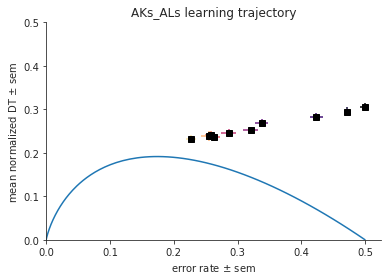

In [32]:
opc_during_learning_from_list(binned_avg_reg_perf['y_bins_mean'], binned_avg_reg_perf['y_bins_sem'], \
                              binned_avg_reg_dt['y_bins_mean'], binned_avg_reg_dt['y_bins_sem'],'AKs_ALs',\
                              '_graphs_opc_during_learning/AK_AL/t0_297ms/AKs_ALs_opc_during_learning_with_no_vol_itis_t0_295ms_10bins.pdf')

IOError: [Errno 2] No such file or directory: '_graphs_opc_during_learning/AK_AL/t0_297ms/AL8_opc_during_learning_with_no_vol_itis_t0_297ms.pdf'

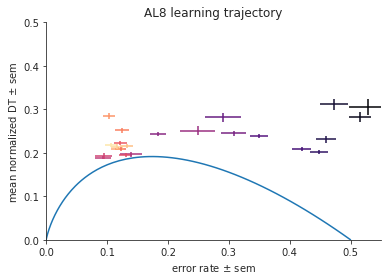

In [33]:
opc_during_learning(reg_perf, reg_perf_err, reg_dt, reg_dt_err,\
                    '_graphs_opc_during_learning/AK_AL/t0_297ms/%s_opc_during_learning_with_no_vol_itis_t0_297ms.pdf')

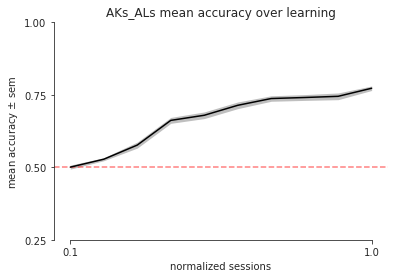

In [34]:
x = np.array(range(len(binned_avg_reg_perf['y_bins_mean'])))
y = np.array(binned_avg_reg_perf['y_bins_mean'])
yerr = np.array(binned_avg_reg_perf['y_bins_sem'])

plt.close()
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'k')
plt.axhline(0.5, color = 'red', alpha = 0.5, linestyle = '--')
plt.yticks([0.25, 0.5, 0.75, 1.0])
plt.ylim(0.25, 1)
plt.xticks([0, 9], [0.1, 1.0])
plt.xlim(-.5,9.5)
plt.ylabel('mean accuracy $\pm$ sem')
plt.xlabel('normalized sessions')
plt.title('AKs_ALs mean accuracy over learning')
sns.despine(trim = True)
# #plt.savefig()

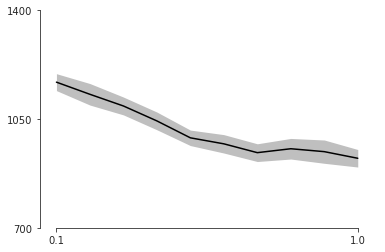

In [35]:
x = np.array(range(len(binned_avg_reg_rt['y_bins_mean'])))
y = np.array(binned_avg_reg_rt['y_bins_mean'])
yerr = np.array(binned_avg_reg_rt['y_bins_sem'])

plt.close()
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'k')
plt.yticks([700, 1050, 1400])
plt.ylim(700, 1400)
plt.xticks([0, 9], [0.1, 1.0])
plt.xlim(-.5,9.5)
sns.despine(trim = True)
##plt.savefig()

IOError: [Errno 2] No such file or directory: '_graphs_opc_during_learning/AK_AL/rt_acc/AKs_ALs_rt_er_during_learning.pdf'

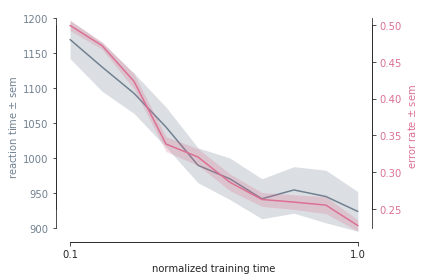

In [36]:
# from https://matplotlib.org/gallery/api/two_scales.html

# data
t = np.array(range(len(binned_avg_reg_rt['y_bins_mean'])))
data1 = np.array(binned_avg_reg_rt['y_bins_mean'])
data2 = np.array(binned_avg_reg_perf['y_bins_mean'])
data1err = np.array(binned_avg_reg_rt['y_bins_sem'])
data2err = np.array(binned_avg_reg_perf['y_bins_sem'])

fig, ax1 = plt.subplots()

color = 'slategray'
ax1.set_xlabel('normalized training time')
ax1.set_ylabel('reaction time $\pm$ sem', color=color)
# ax1.set_yticks([900, 1200])
# ax1.set_ylim(850, 1250)
ax1.plot(t, data1, color=color)
ax1.fill_between(x = t, y1 = (data1) + data1err, y2 = (data1) - data1err, color = 'slategray', alpha = 0.25, linewidth = 0)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'palevioletred'
ax2.set_ylabel('error rate $\pm$ sem', color=color)  # we already handled the x-label with ax1
# ax2.set_yticks([0.5, 0.75])
# ax2.set_ylim(0.475, 0.8)
ax2.plot(t, 1-data2, color=color)
ax2.fill_between(x = t, y1 = (1-data2) + data2err, y2 = (1-data2) - data2err, color = 'palevioletred', alpha = 0.25, linewidth = 0)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks([0,9], [0.1, 1.0])
sns.despine(right = False, trim = True)
#plt.savefig('_graphs_opc_during_learning/AK_AL/rt_acc/AKs_ALs_rt_er_during_learning.pdf')

[ 0.29935171 -0.21961968  0.88110212]
[ 0.33814501 -0.21040341  0.17788793]


Text(0.5,1,'AKs_ALs fitted exponentially fitted RT & ER')

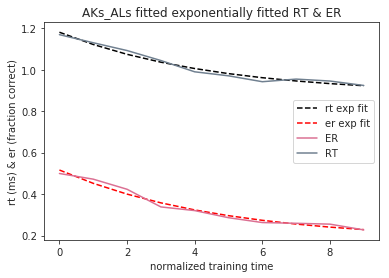

In [37]:
x = np.array(range(len(binned_avg_reg_rt['y_bins_mean'])))
y_RT = np.array(binned_avg_reg_rt['y_bins_mean'])*0.001
y_ER = 1 - np.array(binned_avg_reg_perf['y_bins_mean'])

popt, pcov = scipy.optimize.curve_fit(lambda t,a,b,c: c+a*np.exp(b*t), x, y_RT, bounds = (-1, 3))
rt_exp_fit = popt
print rt_exp_fit

popt, pcov = scipy.optimize.curve_fit(lambda t,a,b,c: c+a*np.exp(b*t), x, y_ER, bounds = (-1, 3))
er_exp_fit = popt
print er_exp_fit


rt_exp = rt_exp_fit[2] + rt_exp_fit[0]*np.exp(rt_exp_fit[1]*x)
er_exp = er_exp_fit[2] + er_exp_fit[0]*np.exp(er_exp_fit[1]*x)

plt.errorbar(x = x, y = rt_exp, label = 'rt exp fit', linestyle = '--', color = 'black')
plt.errorbar(x = x, y = er_exp, label = 'er exp fit', linestyle = '--', color = 'red')
plt.errorbar(x = x, y = y_ER, label = 'ER', color = 'palevioletred')
plt.errorbar(x = x, y = y_RT, label = 'RT', color = 'slategray')
plt.legend()
plt.xlabel('normalized training time')
plt.ylabel('rt (ms) & er (fraction correct)')
plt.title('AKs_ALs fitted exponentially fitted RT & ER')

In [38]:
x = np.array(range(len(binned_avg_stimB_rt['y_bins_mean'])))
y_RT = np.array(binned_avg_stimB_rt['y_bins_mean'])*0.001
y_ER = 1 - np.array(binned_avg_stimB_perf['y_bins_mean'])

popt, pcov = scipy.optimize.curve_fit(lambda t,a,b,c: c+a*np.exp(b*t), x, y_RT, bounds = (-1, 3))
rt_exp_fit = popt
print rt_exp_fit

popt, pcov = scipy.optimize.curve_fit(lambda t,a,b,c: c+a*np.exp(b*t), x, y_ER, bounds = (-1, 3))
er_exp_fit = popt
print er_exp_fit

rt_exp = rt_exp_fit[2] + rt_exp_fit[0]*np.exp(rt_exp_fit[1]*x)
er_exp = er_exp_fit[2] + er_exp_fit[0]*np.exp(er_exp_fit[1]*x)

plt.errorbar(x = x, y = rt_exp, label = 'rt exp fit', linestyle = '--', color = 'black')
plt.errorbar(x = x, y = er_exp, label = 'er exp fit', linestyle = '--', color = 'red')
plt.errorbar(x = x, y = y_ER, label = 'ER', color = 'palevioletred')
plt.errorbar(x = x, y = y_RT, label = 'RT', color = 'slategray')
plt.legend()
plt.xlabel('normalized training time')
plt.ylabel('rt (ms) & er (fraction correct)')
plt.title('ALs_AMs stimB fitted exponentially fitted RT & ER')

NameError: name 'binned_avg_stimB_rt' is not defined

IOError: [Errno 2] No such file or directory: '_graphs_opc_during_learning/AK_AL/rt_acc/AL14_rt_er_during_learning.pdf'

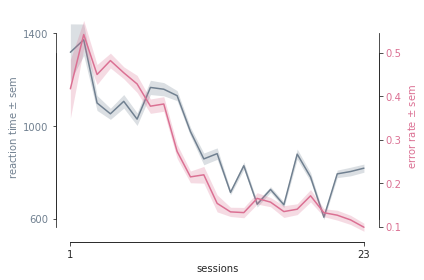

In [39]:
# from https://matplotlib.org/gallery/api/two_scales.html

# data
animal = 'AL14'
t = np.array(range(len(reg_rt_succ[animal])))
data1 = np.array(reg_rt_succ[animal])
data2 = np.array(reg_perf[animal])
data1err = np.array(reg_rt_succ_err[animal])
data2err = np.array(reg_perf_err[animal])

fig, ax1 = plt.subplots()

color = 'slategray'
ax1.set_xlabel('sessions')
ax1.set_ylabel('reaction time $\pm$ sem', color=color)
ax1.set_yticks([600,1000,1400])
ax1.set_ylim(500, 1500)
ax1.plot(t, data1, color=color)
ax1.fill_between(x = t, y1 = data1 + data1err, y2 = data1 - data1err, color = 'slategray', alpha = 0.25, linewidth = 0)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'palevioletred'
ax2.set_ylabel('error rate $\pm$ sem', color=color)  # we already handled the x-label with ax1
# ax2.set_yticks([0.5, 0.75, 1])
# ax2.set_ylim(0.4, 1)
ax2.plot(t, 1-data2, color=color)
ax2.fill_between(x = t, y1 = 1-data2 + data2err, y2 = 1-data2 - data2err, color = 'palevioletred', alpha = 0.25, linewidth = 0)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks([0,22], [1, 23])
sns.despine(right = False, trim = True)
#plt.savefig('_graphs_opc_during_learning/AK_AL/rt_acc/AL14_rt_er_during_learning.pdf')

#### OPC for dataset with 10 first trained sessions during learning

In [40]:
# ~~~~~~~~~  results_AK_AL  ~~~~~~~~~

# all sessions
data_dict = results_AK_AL
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

reg_ign_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_pct_ignore = get_relevant_data(data_dict, 'pct_ignore_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_pct_ignore_err = get_relevant_data(data_dict, 'pct_ignore_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_ign_rt_succ = get_relevant_data(data_dict,'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_ign_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_all_rts = get_relevant_data(data_dict, 'rt_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_ign_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# last 10 sessions
data_dict = results_AK_AL
all_sesh = False
sesh_to_count = 10
sesh_from_start = False

reg_ign_perf_last10 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_perf_err_last10 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_ign_rt_succ_last10 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_succ_err_last10 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_fail_last10 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_fail_err_last10 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_all_last10 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_all_err_last10 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_ign_succ_rts_last10 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_fail_rts_last10 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_ign_iti_succ_last10 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_iti_fail_last10 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_iti_all_last10 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# first 3 sessions
data_dict = results_AK_AL
all_sesh = False
sesh_to_count = 3
sesh_from_start = True

reg_ign_perf_first3 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_perf_err_first3 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_ign_rt_succ_first3 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_succ_err_first3 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_fail_first3 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_fail_err_first3 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_all_first3 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_rt_all_err_first3 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_ign_succ_rts_first3 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_fail_rts_first3 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_ign_iti_succ_first3 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_iti_fail_first3 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_ign_iti_all_first3 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [41]:
T0 = 297
Derr = 3136
Dcorr = 6370
boundary = 500
with_itis = False

reg_ign_iti_succ_adj = adjust_itis(reg_ign_iti_succ, Dcorr)
reg_ign_iti_succ_adj_mean, reg_ign_iti_succ_adj_sem, reg_ign_iti_succ_adj_median = avg_adjusted_itis(reg_ign_iti_succ_adj, boundary)

reg_ign_iti_fail_adj = adjust_itis(reg_ign_iti_fail, Derr)
reg_ign_iti_fail_adj_mean, reg_ign_iti_fail_adj_sem, reg_ign_iti_fail_adj_median = avg_adjusted_itis(reg_ign_iti_fail_adj, boundary)

reg_ign_dt = convert_RTs_to_DTs(reg_ign_rt_succ, reg_ign_iti_fail_adj_mean, T0, Derr, with_itis)
reg_ign_dt_err = calc_DT_err(reg_ign_rt_succ_err, reg_ign_iti_fail_adj_sem, T0, Derr, with_itis)

/home/rodrigo/miniconda3/envs/strategic/lib/python2.7/site-packages/ipykernel_launcher.py:518: RuntimeWarning: Mean of empty slice
/home/rodrigo/miniconda3/envs/strategic/lib/python2.7/site-packages/ipykernel_launcher.py:513: RuntimeWarning: Mean of empty slice


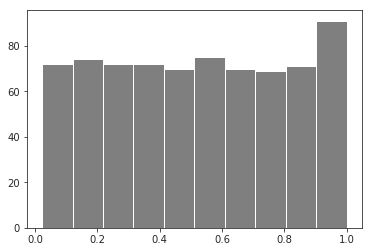

In [42]:
# mesh data

meshed_reg_ign_rt = mesh_data(reg_ign_rt_succ, 'none')
meshed_reg_ign_dt = mesh_data(reg_ign_dt, 'none')
meshed_reg_ign_perf = mesh_data(reg_ign_perf, 'none')
meshed_reg_ign_pct_ignore = mesh_data(reg_ign_pct_ignore, 'none')
meshed_reg_ign_iti_err = mesh_data(reg_ign_iti_fail_adj_mean, 'none')
meshed_reg_ign_iti_corr = mesh_data(reg_ign_iti_succ_adj_mean, 'none')
meshed_reg_ign_iti_err_median = mesh_data(reg_ign_iti_fail_adj_median, 'none')
meshed_reg_ign_iti_corr_median = mesh_data(reg_ign_iti_succ_adj_median, 'none')

meshed_reg_ign_iti_err_raw = mesh_data(reg_ign_iti_fail_adj, 'none')

n_bins = 10
binned_avg_reg_ign_rt = avg_binned_data(meshed_reg_ign_rt, n_bins)
binned_avg_reg_ign_dt = avg_binned_data(meshed_reg_ign_dt, n_bins)
binned_avg_reg_ign_perf = avg_binned_data(meshed_reg_ign_perf, n_bins)
binned_avg_reg_ign_pct_ignore = avg_binned_data(meshed_reg_ign_pct_ignore, n_bins)
binned_avg_reg_ign_iti_err = avg_binned_data(meshed_reg_ign_iti_err, n_bins)
binned_avg_reg_ign_iti_corr = avg_binned_data(meshed_reg_ign_iti_corr, n_bins)
binned_avg_reg_ign_iti_err_median = avg_binned_data(meshed_reg_ign_iti_err_median, n_bins)
binned_avg_reg_ign_iti_corr_median = avg_binned_data(meshed_reg_ign_iti_corr_median, n_bins)

IOError: [Errno 2] No such file or directory: '_graphs_opc_during_learning/AK_AL/t0_297ms/actualfirst10afterlearning/AKs_ALs_actualfirst10trained_opc_during_learning_with_no_vol_itis_t0_297ms_10bins.pdf'

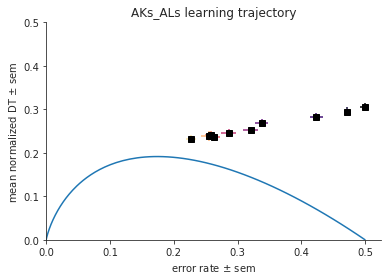

In [43]:
opc_during_learning_from_list(binned_avg_reg_perf['y_bins_mean'], binned_avg_reg_perf['y_bins_sem'], \
                              binned_avg_reg_dt['y_bins_mean'], binned_avg_reg_dt['y_bins_sem'],'AKs_ALs',\
                              '_graphs_opc_during_learning/AK_AL/t0_297ms/actualfirst10afterlearning/AKs_ALs_actualfirst10trained_opc_during_learning_with_no_vol_itis_t0_297ms_10bins.pdf')

In [44]:
# all sessions across all animals in results_AK_AL and results_AK_AL are the same 
# except for the follow two exceptions:

# AL8 has AL8_170817 in results_AK_AL because first session AL8_170804b was a half session
# AL4 has AL4_170815 in results_AK_AL because of AL4_170802c which was probably a shorter fractional session

In [45]:
# function that finds and classifies RTs for trials after correct and error trials

def post_error_or_correct_RTs(dataset_of_interest):
    postoutcome_RTs = {}
    for animal in sorted(dataset_of_interest.keys()):
        posterr_corr_RT_by_session = {}
        postcorr_corr_RT_by_session = {}
        posterr_err_RT_by_session = {}
        postcorr_err_RT_by_session = {}
        for session in sorted(dataset_of_interest[animal]['beh_outcome_by_session'].keys()):
            posterr_corr_RT = []
            postcorr_corr_RT = []
            posterr_err_RT = []
            postcorr_err_RT = []
            for i in range(len(dataset_of_interest[animal]['beh_outcome_by_session'][session])):
                if i == 0: # skip first one because looking at i and i-1
                    pass
                else:
                    past_outcome = dataset_of_interest[animal]['beh_outcome_by_session'][session][i-1]
                    curr_outcome = dataset_of_interest[animal]['beh_outcome_by_session'][session][i]
                    if curr_outcome == 'success':
                        if past_outcome == 'failure':
                            posterr_corr_RT.append(dataset_of_interest[animal]['rt_by_session'][session][i])
                        elif past_outcome == 'success':
                            postcorr_corr_RT.append(dataset_of_interest[animal]['rt_by_session'][session][i])
                        else:
                            pass
                    elif curr_outcome == 'failure':
                        if past_outcome == 'failure':
                            posterr_err_RT.append(dataset_of_interest[animal]['rt_by_session'][session][i])
                        elif past_outcome == 'success':
                            postcorr_err_RT.append(dataset_of_interest[animal]['rt_by_session'][session][i])
                        else:
                            pass
                    else:
                        pass

            posterr_corr_RT_by_session[session] = posterr_corr_RT
            postcorr_corr_RT_by_session[session] = postcorr_corr_RT
            posterr_err_RT_by_session[session] = posterr_err_RT
            postcorr_err_RT_by_session[session] = postcorr_err_RT

        postoutcome_RTs[animal] = {
            'posterr_corr_RTs': posterr_corr_RT_by_session,
            'postcorr_corr_RTs': postcorr_corr_RT_by_session,
            'posterr_err_RTs': posterr_err_RT_by_session,
            'postcorr_err_RTs': postcorr_err_RT_by_session}

    return postoutcome_RTs

In [46]:
reg_postoutcome_RTs = post_error_or_correct_RTs(results_AK_AL)

In [47]:
for animal in reg_postoutcome_RTs.keys():
    print len(reg_postoutcome_RTs[animal]['posterr_corr_RTs'])

23
21
33
22
27
22
41
19
43
22
29
33
36
32
31
31
23
26
23
21
41
22
31
38
22
24


IOError: [Errno 2] No such file or directory: '_graphs_stimpair2/posterror_RTs/by_session/AK_AL_corr_RTs_post_err_or_corr_by_session_stimpair1.pdf'

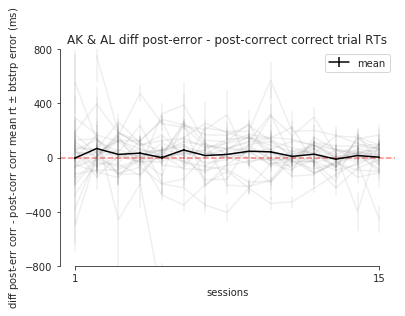

In [48]:
diff_mean_regstim_all_animals = []

for animal in sorted(reg_postoutcome_RTs.keys()):
    
    btstrp_iter = 100
    
    # ~~~~~~collecting individual animal data~~~~~~~~
    
    sessions_to_count_regstim = 15
    
    data_regstim_postcorr_corr_mean = average_data_rt(reg_postoutcome_RTs[animal]['postcorr_corr_RTs']) # dictionary
    data_regstim_postcorr_corr_err = bootstrap_error_rt(reg_postoutcome_RTs[animal]['postcorr_corr_RTs'], btstrp_iter) # dictionary
    data_regstim_posterr_corr_mean = average_data_rt(reg_postoutcome_RTs[animal]['posterr_corr_RTs']) # dictionary
    data_regstim_posterr_corr_err = bootstrap_error_rt(reg_postoutcome_RTs[animal]['posterr_corr_RTs'], btstrp_iter) # dictionary
    
    data_regstim_postcorr_corr = []
    data_regstim_posterr_corr = []
    session_mean_regstim_postcorr_corr = []
    session_err_regstim_postcorr_corr = []
    session_mean_regstim_posterr_corr = []
    session_err_regstim_posterr_corr = []
    session_diff_mean_regstim = []
    session_diff_err_regstim = []
    for session in sorted(reg_postoutcome_RTs[animal]['postcorr_corr_RTs'].keys())[:sessions_to_count_regstim]:
        # post-error correct
        data_regstim_posterr_corr.append(reg_postoutcome_RTs[animal]['posterr_corr_RTs'][session]) # capture session values in order
        session_mean_regstim_posterr_corr.append(data_regstim_posterr_corr_mean[session]) # convert to list where sessions in order
        session_err_regstim_posterr_corr.append(data_regstim_posterr_corr_err[session]) # convert to list where sessions in order
        # post-correct correct
        data_regstim_postcorr_corr.append(reg_postoutcome_RTs[animal]['postcorr_corr_RTs'][session]) # capture session values in order
        session_mean_regstim_postcorr_corr.append(data_regstim_postcorr_corr_mean[session]) # convert to list where sessions in order
        session_err_regstim_postcorr_corr.append(data_regstim_postcorr_corr_err[session])# convert to list where sessions in order
        # difference post-error correct - post-correct correct
        session_diff_mean_regstim.append(data_regstim_posterr_corr_mean[session] - data_regstim_postcorr_corr_mean[session])
        session_diff_err_regstim.append(math.sqrt(data_regstim_posterr_corr_err[session]**2 + data_regstim_postcorr_corr_err[session]**2)) # error of difference is addition in quadrature
        
    # add to list for all animals
    diff_mean_regstim_all_animals.append(session_diff_mean_regstim)
    
    # take overall means of all sessions
    mean_regstim_postcorr_corr = np.nanmean(data_regstim_postcorr_corr_mean.values())
    std_regstim_postcorr_corr = np.nanstd(data_regstim_postcorr_corr_mean.values())
    mean_regstim_posterr_corr = np.nanmean(data_regstim_posterr_corr_mean.values())
    std_regstim_posterr_corr = np.nanstd(data_regstim_posterr_corr_mean.values())
    
    # find differences between post-error correct and post-correct correct across all sessions
#     diff_mean_regstim = mean_regstim_posterr_corr - mean_regstim_postcorr_corr
# #     diff_mean_regstim_all.append(diff_mean_regstim)
#     diff_mean_regstim_err = math.sqrt(std_regstim_posterr_corr**2 + std_regstim_postcorr_corr**2) # error of difference is addition in quadrature
#     diff_mean_stimB = mean_stimB_posterr_corr - mean_stimB_postcorr_corr
# #     diff_mean_stimB_all.append(diff_mean_stimB)
#     diff_mean_stimB_err = math.sqrt(std_stimB_posterr_corr**2 + std_stimB_postcorr_corr**2) # error of difference is addition in quadrature
    
    # ~~~~~~plotting individual animal differences~~~~~~~~  
    
    x = range(len(session_mean_regstim_posterr_corr))
    y1 = session_diff_mean_regstim
    
    y1err = session_diff_err_regstim
    
    plt.errorbar(x = x, y = y1, yerr = y1err, color = 'dimgrey', alpha = 0.1)
#     if animal == 'AL14':
#         plt.errorbar(x = x, y = y1, yerr = y1err, color = 'dimgrey', alpha = 0.1)


regstimmean = np.nanmean(diff_mean_regstim_all_animals, axis = 0)
regstimerr = np.nanstd(diff_mean_regstim_all_animals, axis = 0) / len(diff_mean_regstim_all_animals)

y = regstimmean
x = range(len(y))
yerr = regstimerr

plt.errorbar(x = x, y = y, yerr = yerr, color = 'k', label = 'mean')
plt.axhline(y = 0, color = 'r', linestyle = '--', alpha = 0.5)
plt.xlabel('sessions')
plt.xticks([0, 14], [1, 15])
plt.ylabel('diff post-err corr - post-corr corr mean rt $\pm$ btstrp error (ms)')
plt.ylim(-800,800)
plt.yticks([-800, -400, 0, 400, 800])
plt.title('AK & AL diff post-error - post-correct correct trial RTs')
plt.legend()
sns.despine(trim = True)
#plt.savefig('_graphs_stimpair2/posterror_RTs/by_session/AK_AL_corr_RTs_post_err_or_corr_by_session_stimpair1.pdf')

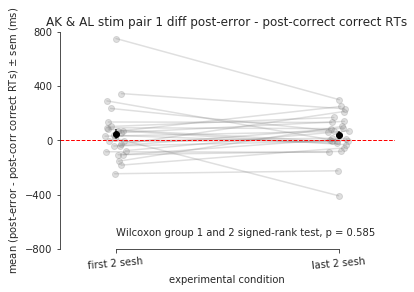

In [51]:
diff_mean_regstim_all_first2 = []
diff_mean_regstim_all_last2 = []
diff_mean_regstim_all_dict_first2 = {}
diff_mean_regstim_all_dict_last2 = {}
diff_mean_regstim_last2_minus_first2_all_dict = {}

for animal in sorted(reg_postoutcome_RTs.keys()):
    
    sessions_to_count = 2
    
    # ~~~~~~collecting individual animal data~~~~~~~~
    data_regstim_postcorr_corr_first2 = []
    data_regstim_postcorr_corr_mean_first2 = []
    data_regstim_posterr_corr_first2 = []
    data_regstim_posterr_corr_mean_first2 = []
    for session in sorted(reg_postoutcome_RTs[animal]['postcorr_corr_RTs'].keys())[:sessions_to_count]:
        data_regstim_postcorr_corr_first2.append(reg_postoutcome_RTs[animal]['postcorr_corr_RTs'][session])
        data_regstim_postcorr_corr_mean_first2.append(np.mean(reg_postoutcome_RTs[animal]['postcorr_corr_RTs'][session]))
        data_regstim_posterr_corr_first2.append(reg_postoutcome_RTs[animal]['posterr_corr_RTs'][session])
        data_regstim_posterr_corr_mean_first2.append(np.mean(reg_postoutcome_RTs[animal]['posterr_corr_RTs'][session]))

    mean_regstim_postcorr_corr_first2 = np.nanmean(data_regstim_postcorr_corr_mean_first2)
    std_regstim_postcorr_corr_first2 = np.nanstd(data_regstim_postcorr_corr_mean_first2)
    mean_regstim_posterr_corr_first2 = np.nanmean(data_regstim_posterr_corr_mean_first2)
    std_regstim_posterr_corr_first2 = np.nanstd(data_regstim_posterr_corr_mean_first2)
    
    data_regstim_postcorr_corr_last2 = []
    data_regstim_postcorr_corr_mean_last2 = []
    data_regstim_posterr_corr_last2 = []
    data_regstim_posterr_corr_mean_last2 = []
    for session in sorted(reg_postoutcome_RTs[animal]['postcorr_corr_RTs'].keys())[-sessions_to_count:]:
        data_regstim_postcorr_corr_last2.append(reg_postoutcome_RTs[animal]['postcorr_corr_RTs'][session])
        data_regstim_postcorr_corr_mean_last2.append(np.mean(reg_postoutcome_RTs[animal]['postcorr_corr_RTs'][session]))
        data_regstim_posterr_corr_last2.append(reg_postoutcome_RTs[animal]['posterr_corr_RTs'][session])
        data_regstim_posterr_corr_mean_last2.append(np.mean(reg_postoutcome_RTs[animal]['posterr_corr_RTs'][session]))

    mean_regstim_postcorr_corr_last2 = np.nanmean(data_regstim_postcorr_corr_mean_last2)
    std_regstim_postcorr_corr_last2 = np.nanstd(data_regstim_postcorr_corr_mean_last2)
    mean_regstim_posterr_corr_last2 = np.nanmean(data_regstim_posterr_corr_mean_last2)
    std_regstim_posterr_corr_last2 = np.nanstd(data_regstim_posterr_corr_mean_last2)

    
    diff_mean_regstim_first2 = mean_regstim_posterr_corr_first2 - mean_regstim_postcorr_corr_first2
    diff_mean_regstim_all_first2.append(diff_mean_regstim_first2)
    diff_mean_regstim_all_dict_first2[animal] = diff_mean_regstim_first2
    diff_mean_regstim_err_first2 = math.sqrt(std_regstim_posterr_corr_first2**2 + std_regstim_postcorr_corr_first2**2) # error of difference is addition in quadrature
    
    diff_mean_regstim_last2 = mean_regstim_posterr_corr_last2 - mean_regstim_postcorr_corr_last2
    diff_mean_regstim_all_last2.append(diff_mean_regstim_last2)
    diff_mean_regstim_all_dict_last2[animal] = diff_mean_regstim_last2
    diff_mean_regstim_err_last2 = math.sqrt(std_regstim_posterr_corr_last2**2 + std_regstim_postcorr_corr_last2**2) # error of difference is addition in quadrature
    
    diff_mean_regstim_last2_minus_first2_all_dict[animal] = diff_mean_regstim_last2 - diff_mean_regstim_first2


x_means = [0,1]
y_means = [np.mean(diff_mean_regstim_all_first2), np.mean(diff_mean_regstim_all_last2)]
y_means_err = [stats.sem(diff_mean_regstim_all_first2), stats.sem(diff_mean_regstim_all_last2)]

# plot the individual animal averages first, in gray
for i in range(len(diff_mean_regstim_all_first2)):
    jiggle = np.random.uniform(-0.05, 0.05) # create some random noise
    x = [0+jiggle, 1+jiggle] # add that noise to the dot locations so they don't exactly overlap
    y = [diff_mean_regstim_all_first2[i], diff_mean_regstim_all_last2[i]]
    plt.plot(x, y, marker = 'o', color = 'gray', linestyle = '-', alpha = 0.25)

# plot the mean of the animals' individual averages, and add the error bars
labels = ['first 2 sesh', 'last 2 sesh']

plt.errorbar(x_means, y_means, yerr = y_means_err, marker = 'o', linestyle = ' ', color = 'black')
plt.xlim(-.25, 1.25)
plt.ylim(-800, 800)
plt.yticks([-800, -400, 0, 400, 800])
plt.axhline(y = 0, linestyle = '--', color = 'r', linewidth = 1)

plt.xticks(x_means, labels, rotation=5)

# plt.ylabel('average RT (ms), mean $\pm$ sem')
plt.ylabel('mean (post-error - post-corr correct RTs) $\pm$ sem (ms)')
plt.xlabel('experimental condition')
plt.title('AK & AL stim pair 1 diff post-error - post-correct correct RTs')

# Wilcoxon rank-sum test tests whether two groups are sampled from the same distribution
# intended for independent samples
# s = 'Wilcoxon group 1 and 2 rank-sum test, p = %.3f'  % stats.ranksums(diff_mean_regstim_all, diff_mean_stimB_all)[1]

# Wilcoxon signed-rank test tests whether distribution of differences is symmetric about zero
# intended for paired samples
s = 'Wilcoxon group 1 and 2 signed-rank test, p = %.3f'  % stats.wilcoxon(diff_mean_regstim_all_first2, diff_mean_regstim_all_last2)[1]
plt.text(0, -700, s)

sns.despine(trim = True)
#plt.savefig('_graphs_stimpair2/posterror_RTs/AK_AL_diff_corr_RTs_post_err_or_corr_first2sesh_and_last2sesh_of_stimpair1.pdf')

### Ignore trials

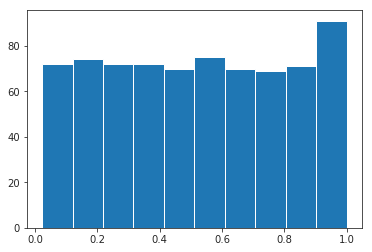

In [52]:
# all sessions
data_dict = results_AK_AL
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

reg_pct_ignore = get_relevant_data(data_dict, 'pct_ignore_by_session', all_sesh, sesh_to_count, sesh_from_start)

meshed_reg_pct_ignore = mesh_data(reg_pct_ignore, 'none')
binned_avg_reg_pct_ignore = avg_binned_data(meshed_reg_pct_ignore, n_bins)

Text(0.5,1,'AK_ALs fraction ignored trials over learning')

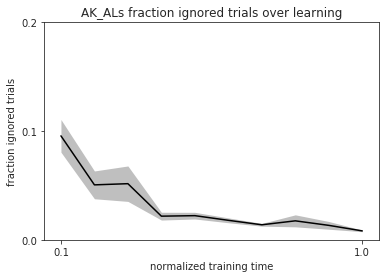

In [53]:
x = np.array(range(len(binned_avg_reg_pct_ignore['y_bins_mean'])))
y = np.array(binned_avg_reg_pct_ignore['y_bins_mean'])
yerr = np.array(binned_avg_reg_pct_ignore['y_bins_sem'])

plt.close()
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'k')
plt.yticks([0, 0.1, 0.2])
plt.ylim(0, 0.2)
plt.xticks([0, 9], [0.1, 1.0])
plt.xlim(-.5,9.5)
plt.ylabel('fraction ignored trials')
plt.xlabel('normalized training time')
plt.title('AK_ALs fraction ignored trials over learning')
#plt.savefig('AK_AL_fraction_ignored_over_learning.pdf')

In [54]:
trials = []
for animal in results_AK_AL.keys():
    trials.append(len(results_AK_AL[animal]['rt_by_trial']))
    print 'animal', len(results_AK_AL[animal]['rt_by_trial'])

print 'mean :', np.mean(trials)
print 'std :', np.std(trials)

animal 17044
animal 18674
animal 25276
animal 14888
animal 21683
animal 14628
animal 31315
animal 14656
animal 32321
animal 15936
animal 21790
animal 23123
animal 29528
animal 21270
animal 21590
animal 31841
animal 17575
animal 19788
animal 16517
animal 20012
animal 33993
animal 19937
animal 26744
animal 28809
animal 15695
animal 19301
mean : 22074.384615384617
std : 5926.614029281053


In [55]:
trials = []
for animal in results_stimB.keys():
    trials.append(len(results_stimB[animal]['rt_by_trial']))
    print 'animal', len(results_stimB[animal]['rt_by_trial'])

print 'mean :', np.mean(trials)
print 'std :', np.std(trials)

animal 10282
animal 9411
animal 10328
animal 11112
animal 12663
animal 7470
animal 9809
animal 14986
animal 10991
animal 13687
animal 12867
animal 13444
animal 13384
animal 10489
animal 12531
animal 14209
mean : 11728.9375
std : 1981.180439433458


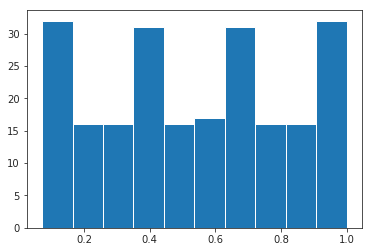

In [56]:
# all sessions
data_dict = results_stimB
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

stimB_ignore_pct_ignore = get_relevant_data(data_dict, 'pct_ignore_by_session', all_sesh, sesh_to_count, sesh_from_start)

meshed_stimB_pct_ignore = mesh_data(stimB_ignore_pct_ignore, 'none')
binned_avg_stimB_pct_ignore = avg_binned_data(meshed_stimB_pct_ignore, n_bins)

Text(0.5,1,'ALs_AMs stimB fraction ignored trials over learning')

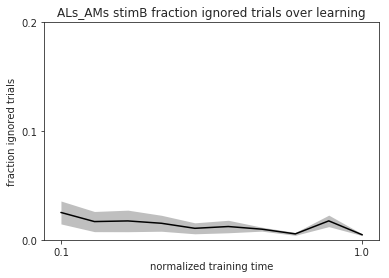

In [57]:
x = np.array(range(len(binned_avg_stimB_pct_ignore['y_bins_mean'])))
y = np.array(binned_avg_stimB_pct_ignore['y_bins_mean'])
yerr = np.array(binned_avg_stimB_pct_ignore['y_bins_sem'])

plt.close()
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'k')
plt.yticks([0, 0.1, 0.2])
plt.ylim(0, 0.2)
plt.xticks([0, 9], [0.1, 1.0])
plt.xlim(-.5,9.5)
plt.ylabel('fraction ignored trials')
plt.xlabel('normalized training time')
plt.title('ALs_AMs stimB fraction ignored trials over learning')
#plt.savefig('AL_AM_fraction_ignored_over_learning.pdf')

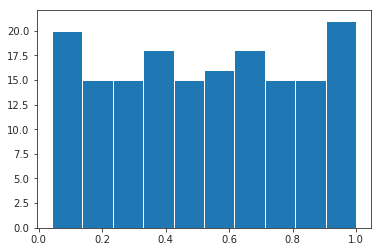

In [58]:
# all sessions
data_dict = results_AN
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

can_ignore_pct_ignore = get_relevant_data(data_dict, 'pct_ignore_by_session', all_sesh, sesh_to_count, sesh_from_start)

meshed_can_pct_ignore = mesh_data(can_ignore_pct_ignore, 'none')
binned_avg_can_pct_ignore = avg_binned_data(meshed_can_pct_ignore, n_bins)

Text(0.5,1,'ANs canonical only fraction ignored trials over learning')

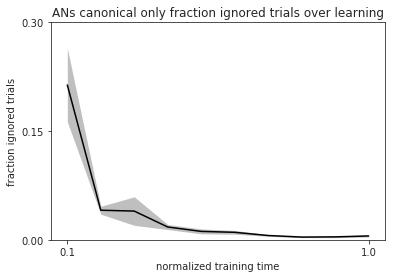

In [59]:
x = np.array(range(len(binned_avg_can_pct_ignore['y_bins_mean'])))
y = np.array(binned_avg_can_pct_ignore['y_bins_mean'])
yerr = np.array(binned_avg_can_pct_ignore['y_bins_sem'])

plt.close()
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'k')
plt.yticks([0, 0.15, 0.3])
plt.ylim(0, 0.3)
plt.xticks([0, 9], [0.1, 1.0])
plt.xlim(-.5,9.5)
plt.ylabel('fraction ignored trials')
plt.xlabel('normalized training time')
plt.title('ANs canonical only fraction ignored trials over learning')

## OPC for New Stim & Transp Stim

In [60]:
T0 = 160
Derr = 3136
Dcorr = 6370
boundary = 500
with_itis = False

stimB_iti_succ_adj = adjust_itis(stimB_iti_succ, Dcorr)
stimB_iti_succ_adj_mean, stimB_iti_succ_adj_sem, stimB_iti_succ_adj_median = avg_adjusted_itis(stimB_iti_succ_adj, boundary)

stimB_iti_fail_adj = adjust_itis(stimB_iti_fail, Derr)
stimB_iti_fail_adj_mean, stimB_iti_fail_adj_sem, stimB_iti_fail_adj_median = avg_adjusted_itis(stimB_iti_fail_adj, boundary)

stimB_dt = convert_RTs_to_DTs(stimB_rt_succ, stimB_iti_fail_adj_mean, T0, Derr, with_itis)
stimB_dt_err = calc_DT_err(stimB_rt_succ_err, stimB_iti_fail_adj_sem, T0, Derr, with_itis)

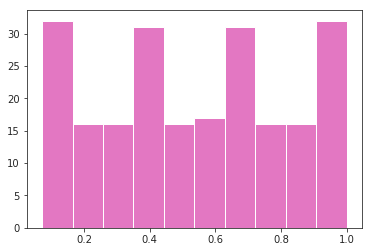

In [61]:
# mesh data

meshed_stimB_rt = mesh_data(stimB_rt_succ, 'none')
meshed_stimB_dt = mesh_data(stimB_dt, 'none')
meshed_stimB_perf = mesh_data(stimB_perf, 'none')
meshed_stimB_iti_err = mesh_data(stimB_iti_fail_adj_mean, 'none')
meshed_stimB_iti_corr = mesh_data(stimB_iti_succ_adj_mean, 'none')
meshed_stimB_iti_err_median = mesh_data(stimB_iti_fail_adj_median, 'none')
meshed_stimB_iti_corr_median = mesh_data(stimB_iti_succ_adj_median, 'none')

meshed_stimB_iti_err_raw = mesh_data(stimB_iti_fail_adj, 'none')

n_bins = 10
binned_avg_stimB_rt = avg_binned_data(meshed_stimB_rt, n_bins)
binned_avg_stimB_dt = avg_binned_data(meshed_stimB_dt, n_bins)
binned_avg_stimB_perf = avg_binned_data(meshed_stimB_perf, n_bins)
binned_avg_stimB_iti_err = avg_binned_data(meshed_stimB_iti_err, n_bins)
binned_avg_stimB_iti_corr = avg_binned_data(meshed_stimB_iti_corr, n_bins)
binned_avg_stimB_iti_err_median = avg_binned_data(meshed_stimB_iti_err_median, n_bins)
binned_avg_stimB_iti_corr_median = avg_binned_data(meshed_stimB_iti_corr_median, n_bins)

(10,)
(10,)
(10,)
(10,)


IOError: [Errno 2] No such file or directory: '_graphs_opc_during_learning/ALs_AMs_opc_during_learning_with_no_vol_itis_t0_160ms_10bins_markers.pdf'

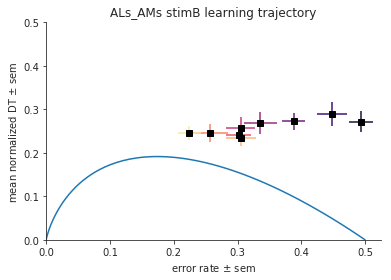

In [71]:
import pandas as pd
print(np.array(binned_avg_stimB_perf['y_bins_mean']).shape)
print(np.array(binned_avg_stimB_perf['y_bins_sem']).shape)
print(np.array(binned_avg_stimB_dt['y_bins_mean']).shape)
print(np.array(binned_avg_stimB_dt['y_bins_sem']).shape)

df = pd.DataFrame(np.array(binned_avg_stimB_perf['y_bins_mean']))
df.to_csv("process_plot_data/binned_avg_stimB_perf_y_mean.csv")

df = pd.DataFrame(np.array(binned_avg_stimB_perf['y_bins_sem']))
df.to_csv("process_plot_data/binned_avg_stimB_perf_y_sem.csv")

df = pd.DataFrame(np.array(binned_avg_stimB_dt['y_bins_mean']))
df.to_csv("process_plot_data/binned_avg_stimB_dt_y_mean.csv")

df = pd.DataFrame(np.array(binned_avg_stimB_dt['y_bins_sem']))
df.to_csv("process_plot_data/binned_avg_stimB_dt_y_sem.csv")

opc_during_learning_from_list(binned_avg_stimB_perf['y_bins_mean'], binned_avg_stimB_perf['y_bins_sem'], \
                              binned_avg_stimB_dt['y_bins_mean'], binned_avg_stimB_dt['y_bins_sem'],\
                              'ALs_AMs stimB',\
                              '_graphs_opc_during_learning/ALs_AMs_opc_during_learning_with_no_vol_itis_t0_160ms_10bins_markers.pdf')

In [63]:
T0 = 160
Derr = 3136
Dcorr = 6370
boundary = 500
with_itis = False

transp_iti_succ_adj = adjust_itis(transp_iti_succ, Dcorr)
transp_iti_succ_adj_mean, transp_iti_succ_adj_sem, transp_iti_succ_adj_median = avg_adjusted_itis(transp_iti_succ_adj, boundary)

transp_iti_fail_adj = adjust_itis(transp_iti_fail, Derr)
transp_iti_fail_adj_mean, transp_iti_fail_adj_sem, transp_iti_fail_adj_median = avg_adjusted_itis(transp_iti_fail_adj, boundary)

transp_dt = convert_RTs_to_DTs(transp_rt_succ, transp_iti_fail_adj_mean, T0, Derr, with_itis)
transp_dt_err = calc_DT_err(transp_rt_succ_err, transp_iti_fail_adj_sem, T0, Derr, with_itis)

In [64]:
# take only animals with transparency = 0.0, or 0.1 if at chance (AK2, AK9)    
condition = '0.0'

# transp_dt = {k:v for (k,v) in transp_dt.items() if condition in k or 'AK2' in k or 'AK9' in k}
# transp_dt_err = {k:v for (k,v) in transp_dt_err.items() if condition in k or 'AK2' in k or 'AK9' in k}

transp_dt = {k:v for (k,v) in transp_dt.items() if condition in k or 'AK2' in k or 'AK9' in k or 'AK10' in k}
transp_dt_err = {k:v for (k,v) in transp_dt_err.items() if condition in k or 'AK2' in k or 'AK9' in k or 'AK10' in k}

/home/rodrigo/miniconda3/envs/strategic/lib/python2.7/site-packages/ipykernel_launcher.py:693: RuntimeWarning: Mean of empty slice
/home/rodrigo/miniconda3/envs/strategic/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1330: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/rodrigo/miniconda3/envs/strategic/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


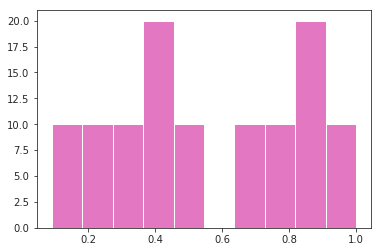

In [65]:
# mesh data

meshed_transp_rt = mesh_data(transp_rt_succ, 'none')
meshed_transp_dt = mesh_data(transp_dt, 'none')
meshed_transp_perf = mesh_data(transp_perf, 'none')
meshed_transp_iti_err = mesh_data(transp_iti_fail_adj_mean, 'none')
meshed_transp_iti_corr = mesh_data(transp_iti_succ_adj_mean, 'none')
meshed_transp_iti_err_median = mesh_data(transp_iti_fail_adj_median, 'none')
meshed_transp_iti_corr_median = mesh_data(transp_iti_succ_adj_median, 'none')

meshed_transp_iti_err_raw = mesh_data(transp_iti_fail_adj, 'none')

n_bins = 10
binned_avg_transp_rt = avg_binned_data(meshed_transp_rt, n_bins)
binned_avg_transp_dt = avg_binned_data(meshed_transp_dt, n_bins)
binned_avg_transp_perf = avg_binned_data(meshed_transp_perf, n_bins)
binned_avg_transp_iti_err = avg_binned_data(meshed_transp_iti_err, n_bins)
binned_avg_transp_iti_corr = avg_binned_data(meshed_transp_iti_corr, n_bins)
binned_avg_transp_iti_err_median = avg_binned_data(meshed_transp_iti_err_median, n_bins)
binned_avg_transp_iti_corr_median = avg_binned_data(meshed_transp_iti_corr_median, n_bins)

IOError: [Errno 2] No such file or directory: '_graphs_opc_during_learning/AKs_transp_plus_AK2_AK9_AK10_alpha_01_opc_during_learning_with_no_vol_itis_t0_160ms_10bins_markers.pdf'

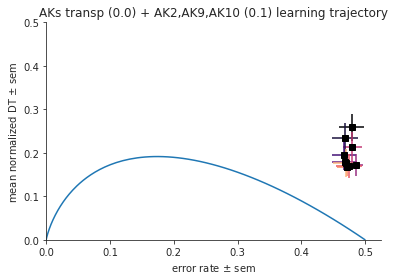

In [72]:
df = pd.DataFrame(np.array(binned_avg_transp_perf['y_bins_mean']))
df.to_csv("process_plot_data/binned_avg_transp_perf_y_mean.csv")

df = pd.DataFrame(np.array(binned_avg_transp_perf['y_bins_sem']))
df.to_csv("process_plot_data/binned_avg_transp_perf_y_sem.csv")

df = pd.DataFrame(np.array(binned_avg_transp_dt['y_bins_mean']))
df.to_csv("process_plot_data/binned_avg_transp_dt_y_mean.csv")

df = pd.DataFrame(np.array(binned_avg_transp_dt['y_bins_sem']))
df.to_csv("process_plot_data/binned_avg_transp_dt_y_sem.csv")

opc_during_learning_from_list(binned_avg_transp_perf['y_bins_mean'], binned_avg_transp_perf['y_bins_sem'], \
                              binned_avg_transp_dt['y_bins_mean'], binned_avg_transp_dt['y_bins_sem'],\
                              'AKs transp (0.0) + AK2,AK9,AK10 (0.1)',\
                              '_graphs_opc_during_learning/AKs_transp_plus_AK2_AK9_AK10_alpha_01_opc_during_learning_with_no_vol_itis_t0_160ms_10bins_markers.pdf')

In [901]:
T0 = 160*0.001 # convert to seconds
Dcorr = 6370*0.001 # convert to seconds
Derr = 3136*0.001 # convert to seconds
with_itis = False
pct_max_rr_data = 'opportunity_cost' # 'fraction_max_rr' # 'opportunity_cost'

perf_dict = reg_perf
rt_dict = reg_rt_succ
corr_iti_dict = reg_iti_succ_adj_mean
err_iti_dict = reg_iti_fail_adj_mean

reg_pct_max_rr = {}
for animal in perf_dict.keys():
    for session in range(len(perf_dict[animal])):
        try:
            reg_pct_max_rr[animal].append(percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data])
        except KeyError:
            reg_pct_max_rr[animal] = [percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data]]

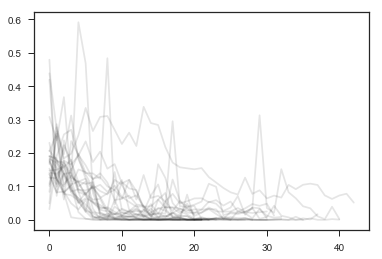

In [902]:
for animal in reg_pct_max_rr.keys():
    plt.plot(reg_pct_max_rr[animal], color = 'k', alpha = 0.1)

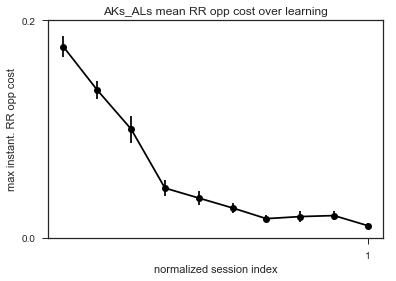

In [923]:
meshed_reg_pct_max_rr = mesh_data(reg_pct_max_rr, 'none')
n_bins = 10
binned_avg_reg_pct_max_rr = avg_binned_data(meshed_reg_pct_max_rr, n_bins)

plt.close()

x = range(len(binned_avg_reg_pct_max_rr['y_bins_mean']))
y = np.array(binned_avg_reg_pct_max_rr['y_bins_mean'])
yerr = np.array(binned_avg_reg_pct_max_rr['y_bins_sem'])

plt.errorbar(x = x, y = y, yerr = yerr, color = 'k', marker = 'o', linestyle = '-')
plt.xticks([9], [1])
plt.yticks([0, 0.2])
plt.ylabel('max instant. RR opp cost')
plt.xlabel('normalized session index')
plt.title('AKs_ALs mean RR opp cost over learning')
#plt.savefig('AKs_ALs_mean_rr_opp_cost_over_learning.pdf')

trained animals last 10

In [75]:
# iti max for averaging (e.g. up to 2000 ms)
boundary = 2000
# include itis in DT and percent max RR
with_itis = False

# iti and dt

T0 = 160
Derr = 3136
Dcorr = 6370

reg_iti_succ_last10_adj = adjust_itis(reg_iti_succ_last10, Dcorr)
reg_iti_succ_last10_adj_mean, reg_iti_succ_last10_adj_sem, reg_iti_succ_last10_adj_median = avg_adjusted_itis(reg_iti_succ_last10_adj, boundary)

reg_iti_fail_last10_adj = adjust_itis(reg_iti_fail_last10, Derr)
reg_iti_fail_last10_adj_mean, reg_iti_fail_last10_adj_sem, reg_iti_fail_last10_adj_median = avg_adjusted_itis(reg_iti_fail_last10_adj, boundary)

reg_dt_last10 = convert_RTs_to_DTs(reg_rt_succ_last10, reg_iti_fail_adj_mean, T0, Derr, with_itis)
reg_dt_err_last10 = calc_DT_err(reg_rt_succ_err_last10, reg_iti_fail_last10_adj_sem, T0, Derr, with_itis)

# percent max rr

T0 = 350*0.001 # convert to seconds
Dcorr = 6370*0.001 # convert to seconds
Derr = 3136*0.001 # convert to seconds
pct_max_rr_data = 'fraction_max_rr' # 'opportunity_cost'

perf_dict = reg_perf_last10
rt_dict = reg_rt_succ_last10
corr_iti_dict = reg_iti_succ_last10_adj_mean
err_iti_dict = reg_iti_fail_last10_adj_mean

reg_pct_max_rr_last10 = {}
for animal in perf_dict.keys():
    for session in range(len(perf_dict[animal])):
        try:
            reg_pct_max_rr_last10[animal].append(percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data])
        except KeyError:
            reg_pct_max_rr_last10[animal] = [percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data]]

In [68]:
# take average for every animal for plotting 
reg_perf_last10_avg = {key:np.mean(value) for (key,value) in reg_perf_last10.items()}
reg_perf_last10_sem = {key:stats.sem(value) for (key,value) in reg_perf_last10.items()}
reg_dt_last10_avg = {key:np.mean(value) for (key,value) in reg_dt_last10.items()}
reg_dt_last10_sem = {key:stats.sem(value) for (key,value) in reg_dt_last10.items()}
reg_pct_max_rr_last10_avg = {key:np.mean(value) for (key,value) in reg_pct_max_rr_last10.items()}

In [69]:
# get rid of AL12 because did not learn and not considered during analysis

del reg_perf_last10_avg['AL12'] # AL12 did not learn and is not considered during analysis
del reg_perf_last10_sem['AL12'] # AL12 did not learn and is not considered during analysis
del reg_dt_last10_avg['AL12'] # AL12 did not learn and is not considered during analysis
del reg_dt_last10_sem['AL12'] # AL12 did not learn and is not considered during analysis
del reg_pct_max_rr_last10_avg['AL12'] # AL12 did not learn and is not considered during analysis

KeyError: 'AL12'

In [70]:
len(reg_pct_max_rr_last10_avg.keys())

26

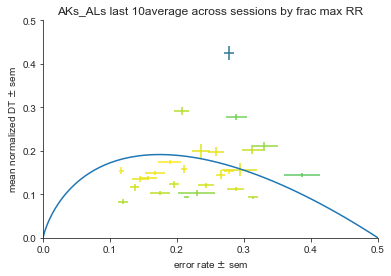

In [91]:
opc_avg_colored_by_frac_max_rr(reg_perf_last10_avg, reg_perf_last10_sem, reg_dt_last10_avg, \
                               reg_dt_last10_sem, reg_pct_max_rr_last10_avg, 'AKs_ALs last 10', \
                               '_graphs_opc_during_learning/AK_AL/t0_297ms/AKs_ALs_opc_last10_frac_max_rr_no_vol_itis_t0_350ms.pdf')

*sorted animal: 1 p = 0.004558670441689395 0.005921537024148708
(0.9627052545547485, 0.8162245154380798)
sorted animal*: 2 p = 0.09967411208814897 0.005921537024148708
(0.8872776031494141, 0.15798452496528625)
sorted animal*: 3 p = 0.07184919569026114 0.005921537024148708
(0.9220780730247498, 0.37461382150650024)
*sorted animal: 4 p = 0.001285384118726515 0.22127181567246956
(0.9525347352027893, 0.6985350847244263)
sorted animal*: 5 p = 0.05089051207706195 0.4755326595969013
(0.737963080406189, 0.0025466999504715204)
sorted animal*: 6 p = 0.05687965452047846 0.014432823938841786
(0.8420315384864807, 0.04666629061102867)
sorted animal*: 7 p = 0.12988333681646533 0.010826921277131306
(0.7536953687667847, 0.003958352375775576)
*sorted animal: 8 p = 0.007943090824637384 0.005921537024148708
(0.9486162066459656, 0.6521568894386292)
sorted animal*: 9 p = 0.08663528166214342 0.005921537024148708
(0.7898824214935303, 0.010921381413936615)
sorted animal*: 10 p = 0.3123740536589229 0.00592153702

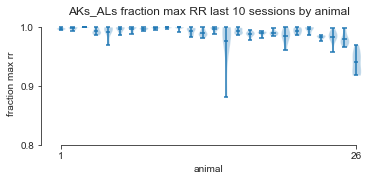

In [76]:
# make a box plot for the trained and/or naive animals
# note that it is very hard to control color, etc with plt.boxplot

d = []

for animal in reg_pct_max_rr_last10.keys():
    if animal not in ['AL12']:
        d.append(reg_pct_max_rr_last10[animal])

d = sorted(d, reverse = True)

num = 1
for a in d:
    #print 'a = ', a
    normtest = stats.shapiro(a)
    sampresult = stats.ttest_1samp(a, 0.999, axis = 0)
#     sampresultnonparametric = stats.mannwhitneyu(a, [1], alternative = 'less')
    sampresultnonparametric = stats.wilcoxon(x = np.array(a) - 0.99, correction = 'None')
    
#     sampresult = stats.wilcoxon([i-1 for i in a])
    if sampresult[1] < 0.05:
        print '*sorted animal:', num, 'p =', sampresult[1], sampresultnonparametric[1]
    else:
        print 'sorted animal*:', num, 'p =', sampresult[1], sampresultnonparametric[1]
    num += 1
    
    print normtest

sns.set_style('ticks')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.violinplot(d, [i+1 for i in range(len(d))], widths = 0.75, showmeans = True, showextrema = True)
# ax.boxplot(d, showfliers = True)
ax.set_ylim(0.80, 1.01)
ax.set_aspect(aspect=50)
ax.set_ylabel('fraction max rr')
ax.set_xlabel('animal')
ax.set_xticks([1, 26])
ax.set_yticks([0.8, 0.9, 1.0])
ax.set_title('AKs_ALs fraction max RR last 10 sessions by animal')
sns.despine(trim = True)
# fig.savefig('AK_AL_percent_max_rr_last_10_trained_sessions_no_vol_itis_t0_160ms_violinplot.pdf')


# plt.boxplot(d_trained)
# plt.boxplot(d)
# plt.ylim(0.8, 1.01)
# plt.xlabel('animal')
# plt.ylabel('percent max rr')
# plt.title('percent max rr for last 10 sessions per animal')
# #plt.savefig('percent_max_rr_last_10_trained_sessions_AK_AL.pdf')

## T0 analysis: accuracy by RT

In [84]:
boundary = 375

acc = {}
acc_err = {}
for animal in reg_succ_rts_last10.keys():
    if animal not in ['AL12']:
        comp_list_succ = [item for sublist in reg_succ_rts_last10[animal] for item in sublist]
        comp_list_fail = [item for sublist in reg_fail_rts_last10[animal] for item in sublist]

        num_succ = len([i for i in comp_list_succ if i < boundary])
        num_fail = len([i for i in comp_list_fail if i < boundary])

        list_of_avg = []
        tot = np.concatenate((np.ones(num_succ), np.zeros(num_fail)))
        for i in xrange(bootstrap_iterations):
            r = np.random.choice(tot, len(tot))
            avg = np.mean(r)
            list_of_avg.append(avg)
        mean_error = np.std(list_of_avg)

        acc[animal] = num_succ / (num_succ + num_fail)
        acc_err[animal] = mean_error

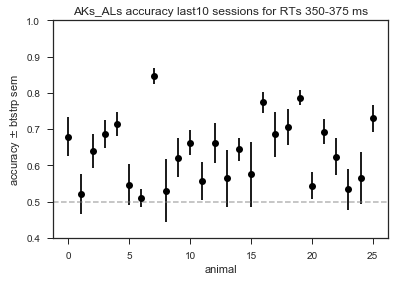

In [40]:
x = range(len(acc.values()))
y = acc.values()
yerr = acc_err.values()

plt.errorbar(x = x, y = y, yerr = yerr, color = 'k', marker = 'o', linestyle = ' ')
plt.axhline(0.5, color = 'gray', alpha = 0.5, linestyle = '--')
plt.ylim(0.4, 1.0)
plt.ylabel('accuracy $\pm$ btstrp sem')
plt.xlabel('animal')
plt.title('AKs_ALs accuracy last10 sessions for RTs 350-375 ms')
# #plt.savefig('AKs_ALs_avg_accuracy_last10_sessions_for_RTs _350-375 ms.pdf')

In [41]:
lower_boundary = 350
upper_boundary = 3500
n_bins = 63
step_size = int((upper_boundary - lower_boundary)/n_bins)


acc = {}
acc_err = {}
for animal in reg_succ_rts_last10.keys():
    if animal not in ['AL12']:
    #     print animal

        comp_list_succ = [item for sublist in reg_succ_rts_last10[animal] for item in sublist]
        comp_list_fail = [item for sublist in reg_fail_rts_last10[animal] for item in sublist]

        num_succ = []
        num_fail = []
        for n in range(n_bins):
    #         print n
            num_succ = len([i for i in comp_list_succ if (lower_boundary + n*step_size) < i < (lower_boundary + (n+1)*step_size)])
            num_fail = len([i for i in comp_list_fail if (lower_boundary + n*step_size) < i < (lower_boundary + (n+1)*step_size)])

            list_of_avg = []
            tot = np.concatenate((np.ones(num_succ), np.zeros(num_fail)))
            if len(tot) > 0:
                for i in xrange(bootstrap_iterations):
                    r = np.random.choice(tot, len(tot))
                    avg = np.mean(r)
                    list_of_avg.append(avg)
                mean_error = np.std(list_of_avg)

                try:
                    acc[animal].append(num_succ / (num_succ + num_fail))
                    acc_err[animal].append(mean_error)
                except KeyError:
                    acc[animal] = [num_succ / (num_succ + num_fail)]
                    acc_err[animal] = [mean_error]
            else:
                mean_error = float('nan')
                try:
                    acc[animal].append(float('nan'))
                    acc_err[animal].append(mean_error)
                except KeyError:
                    acc[animal] = [float('nan')]
                    acc_err[animal] = [mean_error]

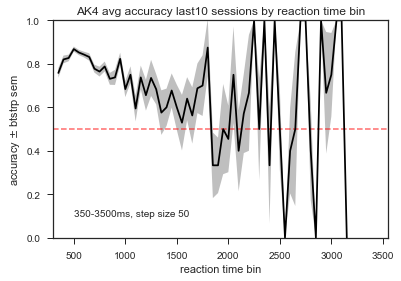

In [42]:
for animal in acc.keys():
    x = np.array(range(lower_boundary, upper_boundary, step_size))
    y = np.array(acc[animal])
    yerr = np.array(acc_err[animal])

    plt.close()
    plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
    plt.errorbar(x = x, y = y, color = 'k')
    plt.axhline(0.5, color = 'red', alpha = 0.5, linestyle = '--')
    plt.ylim(0, 1)
    plt.xlim(300, 3550)
    s = str(lower_boundary) + '-' + str(upper_boundary) + 'ms, step size ' + str(step_size)
    plt.text(500, 0.1, s)
    plt.ylabel('accuracy $\pm$ btstrp sem')
    plt.xlabel('reaction time bin')
    plt.title('%s avg accuracy last10 sessions by reaction time bin' %animal)
#     #plt.savefig('%s_avg_accuracy_last10_sessions_by_rt_bin.pdf' %animal)

In [50]:
# for animal in acc.keys():
#     x = np.array(range(lower_boundary, upper_boundary, step_size))
#     y = np.array(acc[animal])
#     yerr = np.array(acc_err[animal])
#     plt.errorbar(x = x, y = y, color = 'gray', alpha = 0.2)

acc_avg = np.nanmean(acc.values(), axis = 0)
acc_sem = np.nanstd(acc.values(), axis = 0)/math.sqrt(len(acc.values()))

x = np.array(range(lower_boundary, upper_boundary, step_size))
y = acc_avg
yerr = acc_sem

xfit = x[:3]
yfit = acc_avg[:3]
m, b1 = np.polyfit(x = xfit, y = yfit, deg = 1)
xline = [100, 650]
yline = [i*m + b1 for i in xline]

xfit = x[:4]
yfit = acc_avg[:4]
a, b2, c = np.polyfit(x = xfit, y = yfit, deg = 2)
xlinequad = range(175, 650, 5)
ylinequad = [a*i**2 + b2*i + c for i in xlinequad]

plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'k')
plt.axhline(0.5, color = 'red', alpha = 0.5, linestyle = '--')
plt.plot(xline, yline, label = 'linear')
plt.plot(xlinequad, ylinequad, label = 'quadratic')
sns.despine()
plt.legend()
plt.ylim(0, 1)
plt.xlim(0,3500)
s = str(lower_boundary) + '-' + str(upper_boundary) + 'ms, step size ' + str(step_size)
plt.text(500, 0.45, s)
plt.ylabel('accuracy $\pm$ btstrp sem')
plt.xlabel('reaction time')
plt.title('AKs_ALs avg accuracy last10 sessions by reaction time bin')
# #plt.savefig('AKs_ALs_avg_accuracy_last10_sessions_by_rt_bin_lin_quad_fits.pdf')


NameError: name 'acc' is not defined

### AKs & ALs last 10 sessions ITI plots for Figure S4

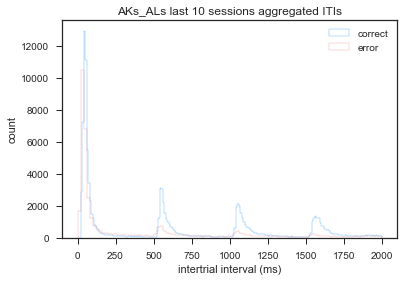

In [44]:
reg_iti_succ_last10_adj_all = []
reg_iti_fail_last10_adj_all = []
for animal in reg_iti_succ_last10_adj.keys():
    reg_iti_succ_last10_adj_all.append([item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist])
    reg_iti_fail_last10_adj_all.append([item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist])

reg_iti_succ_last10_adj_all = [item for sublist in reg_iti_succ_last10_adj_all for item in sublist]
reg_iti_fail_last10_adj_all = [item for sublist in reg_iti_fail_last10_adj_all for item in sublist]

plt.hist(reg_iti_succ_last10_adj_all, range = (0,2000), bins = 200, histtype = 'step', color = 'dodgerblue', label = 'correct')
plt.hist(reg_iti_fail_last10_adj_all, range = (0,2000), bins = 100, histtype = 'step', color = 'lightcoral', label = 'error')
plt.legend()
plt.xlabel('intertrial interval (ms)')
plt.ylabel('count')
plt.title('AKs_ALs last 10 sessions aggregated ITIs')
# #plt.savefig('AKs_ALs_last10_itis_corr_err.pdf')

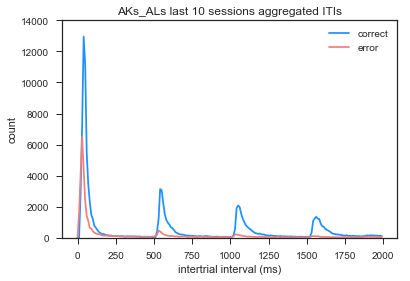

In [45]:
# plot histogram with plt.plot function to make aesthetically nicer

n_bins = 200
normed = False
range_ = (0,2000)

x1 = reg_iti_succ_last10_adj_all
x2 = reg_iti_fail_last10_adj_all

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
plt.plot(bins1[:-1], hist1, color = 'dodgerblue', label = 'correct')

hist2, bins2 = np.histogram(x2, bins = n_bins, normed = normed, range = range_)
plt.plot(bins2[:-1], hist2, color = 'lightcoral', label = 'error')

plt.legend()
plt.ylim(0, 14000)
plt.xlabel('intertrial interval (ms)')
plt.ylabel('count')
plt.title('AKs_ALs last 10 sessions aggregated ITIs')
# #plt.savefig('AKs_ALs_last10_itis_corr_err_neat.pdf')

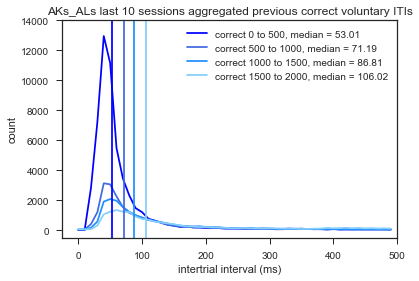

In [46]:
n_bins = 50
normed = False
range_ = (0,500)
alpha = 1

x1 = [i for i in reg_iti_succ_last10_adj_all if 0 < i < 500]
x2 = [i-500 for i in reg_iti_succ_last10_adj_all if 500 < i < 1000]
x3 = [i-1000 for i in reg_iti_succ_last10_adj_all if 1000 < i < 1500]
x4 = [i-1500 for i in reg_iti_succ_last10_adj_all if 1500 < i < 2000]


label1 = 'correct 0 to 500, median = %.2f' %np.median(x1)
label2 = 'correct 500 to 1000, median = %.2f' %np.median(x2)
label3 = 'correct 1000 to 1500, median = %.2f' %np.median(x3)
label4 = 'correct 1500 to 2000, median = %.2f' %np.median(x4)

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
plt.plot(bins1[:-1], hist1, color = 'blue', label = label1, alpha = alpha)
hist2, bins2 = np.histogram(x2, bins = n_bins, normed = normed, range = range_)
plt.plot(bins2[:-1], hist2, color = 'royalblue', label = label2, alpha = alpha)
hist3, bins3 = np.histogram(x3, bins = n_bins, normed = normed, range = range_)
plt.plot(bins3[:-1], hist3, color = 'dodgerblue', label = label3, alpha = alpha)
hist4, bins4 = np.histogram(x4, bins = n_bins, normed = normed, range = range_)
plt.plot(bins4[:-1], hist4, color = 'lightskyblue', label = label4, alpha = alpha)
plt.legend()

plt.axvline(np.median(x1), color = 'blue')
plt.axvline(np.median(x2), color = 'royalblue')
plt.axvline(np.median(x3), color = 'dodgerblue')
plt.axvline(np.median(x4), color = 'lightskyblue')

plt.xlim(-25,500)
plt.ylim(-500, 14000)
plt.xlabel('intertrial interval (ms)')
plt.ylabel('count')
plt.title('AKs_ALs last 10 sessions aggregated previous correct voluntary ITIs')
# #plt.savefig('AKs_ALs_last10_aggregated_prev_corr_vol_itis.pdf')

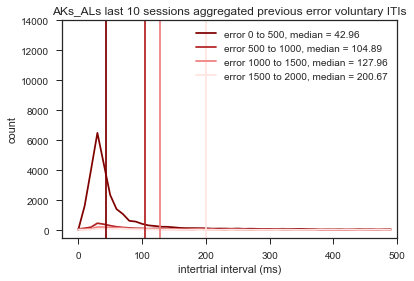

In [47]:
n_bins = 50
normed = False
range_ = (0,500)
alpha = 1

x1 = [i for i in reg_iti_fail_last10_adj_all if 0 < i < 500]
x2 = [i-500 for i in reg_iti_fail_last10_adj_all if 500 < i < 1000]
x3 = [i-1000 for i in reg_iti_fail_last10_adj_all if 1000 < i < 1500]
x4 = [i-1500 for i in reg_iti_fail_last10_adj_all if 1500 < i < 2000]


label1 = 'error 0 to 500, median = %.2f' %np.median(x1)
label2 = 'error 500 to 1000, median = %.2f' %np.median(x2)
label3 = 'error 1000 to 1500, median = %.2f' %np.median(x3)
label4 = 'error 1500 to 2000, median = %.2f' %np.median(x4)

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
plt.plot(bins1[:-1], hist1, color = 'maroon', label = label1, alpha = alpha)
hist2, bins2 = np.histogram(x2, bins = n_bins, normed = normed, range = range_)
plt.plot(bins2[:-1], hist2, color = 'firebrick', label = label2, alpha = alpha)
hist3, bins3 = np.histogram(x3, bins = n_bins, normed = normed, range = range_)
plt.plot(bins3[:-1], hist3, color = 'lightcoral', label = label3, alpha = alpha)
hist4, bins4 = np.histogram(x4, bins = n_bins, normed = normed, range = range_)
plt.plot(bins4[:-1], hist4, color = 'mistyrose', label = label4, alpha = alpha)
plt.legend()

plt.axvline(np.median(x1), color = 'maroon')
plt.axvline(np.median(x2), color = 'firebrick')
plt.axvline(np.median(x3), color = 'lightcoral')
plt.axvline(np.median(x4), color = 'mistyrose')

plt.xlim(-25,500)
plt.ylim(-500, 14000)
plt.xlabel('intertrial interval (ms)')
plt.ylabel('count')
plt.title('AKs_ALs last 10 sessions aggregated previous error voluntary ITIs')
# #plt.savefig('AKs_ALs_last10_aggregated_prev_error_vol_itis.pdf')

In [234]:
# calculate mean of session means across last10 sessions by animal

reg_iti_fail_last10_adj_mean_mean = []
reg_iti_fail_last10_adj_mean_sem = []
reg_iti_succ_last10_adj_mean_mean = []
reg_iti_succ_last10_adj_mean_sem = []
for animal in sorted(reg_iti_fail_last10_adj_mean.keys()):
    reg_iti_fail_last10_adj_mean_mean.append(np.mean(reg_iti_fail_last10_adj_mean[animal]))
    reg_iti_fail_last10_adj_mean_sem.append(stats.sem(reg_iti_fail_last10_adj_mean[animal]))
    reg_iti_succ_last10_adj_mean_mean.append(np.mean(reg_iti_succ_last10_adj_mean[animal]))
    reg_iti_succ_last10_adj_mean_sem.append(stats.sem(reg_iti_succ_last10_adj_mean[animal]))
    
# calculate median by animal across last10 sessions

boundary = 2000

reg_iti_fail_last10_adj_median_all = []
reg_iti_succ_last10_adj_median_all = []
for animal in sorted(reg_iti_fail_last10_adj.keys()):
    flat_list = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist if item < boundary]
    reg_iti_fail_last10_adj_median_all.append(np.median(flat_list))
    flat_list = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist if item < boundary]
    reg_iti_succ_last10_adj_median_all.append(np.median(flat_list))
    
# calculate proportion of voluntary intertrial intervals below a boundary

boundary = 2000

reg_iti_fail_last10_adj_prop_below_all = []
reg_iti_succ_last10_adj_prop_below_all = []
for animal in sorted(reg_iti_fail_last10_adj.keys()):
    flat_list_below = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist if item < boundary]
    flat_list_all = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist]
    reg_iti_fail_last10_adj_prop_below_all.append(len(flat_list_below)/len(flat_list_all))
    flat_list_below = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist if item < boundary]
    flat_list_all = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist]
    reg_iti_succ_last10_adj_prop_below_all.append(len(flat_list_below)/len(flat_list_all))

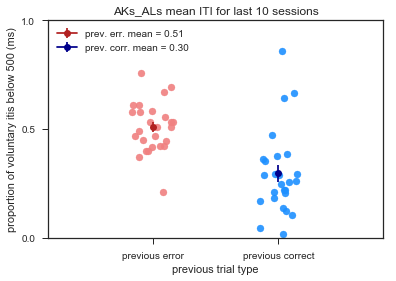

In [230]:
#plot mean of session means but by previous trial type not by animal

plt.scatter(np.random.rand(1,26)+1, reg_iti_fail_last10_adj_prop_below_all, color = 'lightcoral', alpha = 0.9)
plt.scatter(np.random.rand(1,26)+4, reg_iti_succ_last10_adj_prop_below_all, color = 'dodgerblue', alpha = 0.9)

x1 = [1.5]
y1 = [np.mean(reg_iti_fail_last10_adj_prop_below_all)]
yerr1 = [stats.sem(reg_iti_fail_last10_adj_prop_below_all)]
label1 = 'prev. err. mean = %.2f' %y1[0]

x2 = [4.5]
y2 = [np.mean(reg_iti_succ_last10_adj_prop_below_all)]
yerr2 = [stats.sem(reg_iti_succ_last10_adj_prop_below_all)]
label2 = 'prev. corr. mean = %.2f' %y2[0]

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'firebrick', label = label1)
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'darkblue', label = label2)


plt.legend()
plt.xlim(-1,7)
plt.ylim(0,1)
plt.xticks([1.5, 4.5], ['previous error', 'previous correct'])
plt.yticks([0, 0.5, 1.0])
plt.xlabel('previous trial type')
plt.ylabel('proportion of voluntary itis below 500 (ms)')
plt.title('AKs_ALs mean ITI for last 10 sessions')
# #plt.savefig('AKs_ALs_last10_prop_below_2000ms_vol_itis_corr_err_neat.pdf')

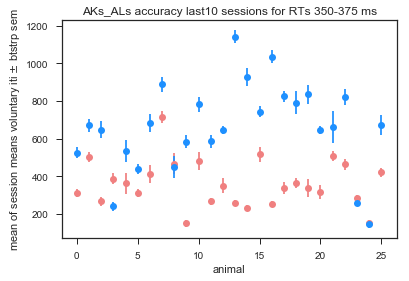

In [50]:
# plot mean of sessions means per animal

x1 = range(len(reg_iti_fail_last10_adj_mean_mean))
y1 = reg_iti_fail_last10_adj_mean_mean
yerr1 = reg_iti_fail_last10_adj_mean_sem

x2 = range(len(reg_iti_succ_last10_adj_mean_mean))
y2 = reg_iti_succ_last10_adj_mean_mean
yerr2 = reg_iti_succ_last10_adj_mean_sem

plt.errorbar(x = x1, y = y1, yerr = yerr1, color = 'lightcoral', marker = 'o', linestyle = ' ')
plt.errorbar(x = x2, y = y2, yerr = yerr2, color = 'dodgerblue', marker = 'o', linestyle = ' ')
# plt.axhline(0.5, color = 'gray', alpha = 0.5, linestyle = '--')
# plt.ylim(0.4, 1.0)
plt.ylabel('mean of session means voluntary iti $\pm$ btstrp sem')
plt.xlabel('animal')
plt.title('AKs_ALs accuracy last10 sessions for RTs 350-375 ms')
# #plt.savefig('AKs_ALs_avg_accuracy_last10_sessions_for_RTs _350-375 ms.pdf')

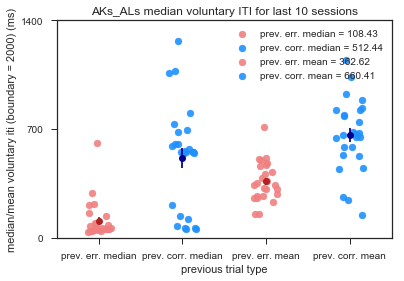

In [241]:
#plot mean & median of session means but by previous trial type not by animal

alpha = 0.9

x1 = [1.5]
y1 = [np.mean(reg_iti_fail_last10_adj_median_all)]
yerr1 = [stats.sem(reg_iti_fail_last10_adj_median_all)]
label1 = 'prev. err. median = %.2f' %y1[0]

x2 = [4.5]
y2 = [np.mean(reg_iti_succ_last10_adj_median_all)]
yerr2 = [stats.sem(reg_iti_succ_last10_adj_median_all)]
label2 = 'prev. corr. median = %.2f' %y2[0]

x3 = [7.5]
y3 = [np.mean(reg_iti_fail_last10_adj_mean_mean)]
yerr3 = [stats.sem(reg_iti_fail_last10_adj_mean_mean)]
label3 = 'prev. err. mean = %.2f' %y3[0]

x4 = [10.5]
y4 = [np.mean(reg_iti_succ_last10_adj_mean_mean)]
yerr4 = [stats.sem(reg_iti_succ_last10_adj_mean_mean)]
label4 = 'prev. corr. mean = %.2f' %y4[0]

plt.scatter(np.random.rand(1,26)+1, reg_iti_fail_last10_adj_median_all, marker = 'o', color = 'lightcoral', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,26)+4, reg_iti_succ_last10_adj_median_all, marker = 'o', color = 'dodgerblue', alpha = alpha, label = label2)
plt.scatter(np.random.rand(1,26)+7, reg_iti_fail_last10_adj_mean_mean, marker = 'o',  color = 'lightcoral', alpha = alpha, label = label3)
plt.scatter(np.random.rand(1,26)+10, reg_iti_succ_last10_adj_mean_mean, marker = 'o', color = 'dodgerblue', alpha = alpha, label = label4)


plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'firebrick')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'darkblue')
plt.errorbar(x = x3, y = y3, yerr = yerr3, marker = 'o', color = 'firebrick')
plt.errorbar(x = x4, y = y4, yerr = yerr4, marker = 'o', color = 'darkblue')

plt.legend()
plt.xlim(0,12)
plt.ylim(0,1400)
plt.xticks([1.5, 4.5, 7.5, 10.5], ['prev. err. median', 'prev. corr. median', 'prev. err. mean', 'prev. corr. mean'])
plt.yticks([0, 700, 1400])
plt.xlabel('previous trial type')
plt.ylabel('median/mean voluntary iti (boundary = 2000) (ms)')
plt.title('AKs_ALs median voluntary ITI for last 10 sessions')
# #plt.savefig('AKs_ALs_last10_median_mean_itis_corr_err_neat.pdf')

In [242]:
# calculate median by animal across last10 sessions with different boundaries

boundary = 2000

reg_iti_fail_last10_adj_median_all_2000 = []
reg_iti_succ_last10_adj_median_all_2000 = []
for animal in sorted(reg_iti_fail_last10_adj.keys()):
    flat_list = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist if item < boundary]
    reg_iti_fail_last10_adj_median_all_2000.append(np.median(flat_list))
    flat_list = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist if item < boundary]
    reg_iti_succ_last10_adj_median_all_2000.append(np.median(flat_list))
    
boundary = 1000

reg_iti_fail_last10_adj_median_all_1000 = []
reg_iti_succ_last10_adj_median_all_1000 = []
for animal in sorted(reg_iti_fail_last10_adj.keys()):
    flat_list = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist if item < boundary]
    reg_iti_fail_last10_adj_median_all_1000.append(np.median(flat_list))
    flat_list = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist if item < boundary]
    reg_iti_succ_last10_adj_median_all_1000.append(np.median(flat_list))
    
boundary = 500

reg_iti_fail_last10_adj_median_all_500 = []
reg_iti_succ_last10_adj_median_all_500 = []
for animal in sorted(reg_iti_fail_last10_adj.keys()):
    flat_list = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist if item < boundary]
    reg_iti_fail_last10_adj_median_all_500.append(np.median(flat_list))
    flat_list = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist if item < boundary]
    reg_iti_succ_last10_adj_median_all_500.append(np.median(flat_list))

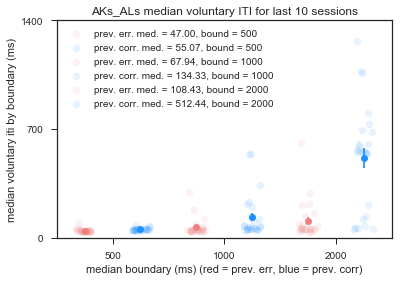

In [271]:
#plot mean & median of session means but by previous trial type not by animal

alpha = 0.1

x1 = [1.5]
y1 = [np.mean(reg_iti_fail_last10_adj_median_all_500)]
yerr1 = [stats.sem(reg_iti_fail_last10_adj_median_all_500)]
label1 = 'prev. err. med. = %.2f, bound = 500' %y1[0]

x2 = [4.5]
y2 = [np.mean(reg_iti_succ_last10_adj_median_all_500)]
yerr2 = [stats.sem(reg_iti_succ_last10_adj_median_all_500)]
label2 = 'prev. corr. med. = %.2f, bound = 500' %y2[0]

x3 = [7.5]
y3 = [np.mean(reg_iti_fail_last10_adj_median_all_1000)]
yerr3 = [stats.sem(reg_iti_fail_last10_adj_median_all_1000)]
label3 = 'prev. err. med. = %.2f, bound = 1000' %y3[0]

x4 = [10.5]
y4 = [np.mean(reg_iti_succ_last10_adj_median_all_1000)]
yerr4 = [stats.sem(reg_iti_succ_last10_adj_median_all_1000)]
label4 = 'prev. corr. med. = %.2f, bound = 1000' %y4[0]

x5 = [13.5]
y5 = [np.mean(reg_iti_fail_last10_adj_median_all_2000)]
yerr5 = [stats.sem(reg_iti_fail_last10_adj_median_all_2000)]
label5 = 'prev. err. med. = %.2f, bound = 2000' %y5[0]

x6 = [16.5]
y6 = [np.mean(reg_iti_succ_last10_adj_median_all_2000)]
yerr6 = [stats.sem(reg_iti_succ_last10_adj_median_all_2000)]
label6 = 'prev. corr. med. = %.2f, bound = 2000' %y6[0]

plt.scatter(np.random.rand(1,26)+1, reg_iti_fail_last10_adj_median_all_500, marker = 'o', color = 'lightcoral', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,26)+4, reg_iti_succ_last10_adj_median_all_500, marker = 'o', color = 'dodgerblue', alpha = alpha, label = label2)
plt.scatter(np.random.rand(1,26)+7, reg_iti_fail_last10_adj_median_all_1000, marker = 'o',  color = 'lightcoral', alpha = alpha, label = label3)
plt.scatter(np.random.rand(1,26)+10, reg_iti_succ_last10_adj_median_all_1000, marker = 'o', color = 'dodgerblue', alpha = alpha, label = label4)
plt.scatter(np.random.rand(1,26)+13, reg_iti_fail_last10_adj_median_all_2000, marker = 'o',  color = 'lightcoral', alpha = alpha, label = label5)
plt.scatter(np.random.rand(1,26)+16, reg_iti_succ_last10_adj_median_all_2000, marker = 'o', color = 'dodgerblue', alpha = alpha, label = label6)

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'lightcoral')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'dodgerblue')
plt.errorbar(x = x3, y = y3, yerr = yerr3, marker = 'o', color = 'lightcoral')
plt.errorbar(x = x4, y = y4, yerr = yerr4, marker = 'o', color = 'dodgerblue')
plt.errorbar(x = x5, y = y5, yerr = yerr5, marker = 'o', color = 'lightcoral')
plt.errorbar(x = x6, y = y6, yerr = yerr6, marker = 'o', color = 'dodgerblue')

plt.legend()
plt.xlim(0,18)
plt.ylim(0,1400)
# plt.xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5], ['prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.'])
plt.xticks([3, 9, 15], [500, 1000, 2000])
plt.yticks([0, 700, 1400])
plt.xlabel('median boundary (ms) (red = prev. err, blue = prev. corr)')
plt.ylabel('median voluntary iti by boundary (ms)')
plt.title('AKs_ALs median voluntary ITI for last 10 sessions')
#plt.savefig('AKs_ALs_last10_median_itis_corr_err_boundary_500_1000_2000_neat.pdf')

In [248]:
# calculate proportion of voluntary intertrial intervals below a boundary

boundary = 500

reg_iti_fail_last10_adj_prop_below_all_500 = []
reg_iti_succ_last10_adj_prop_below_all_500 = []
for animal in sorted(reg_iti_fail_last10_adj.keys()):
    flat_list_below = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist if item < boundary]
    flat_list_all = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist]
    reg_iti_fail_last10_adj_prop_below_all_500.append(len(flat_list_below)/len(flat_list_all))
    flat_list_below = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist if item < boundary]
    flat_list_all = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist]
    reg_iti_succ_last10_adj_prop_below_all_500.append(len(flat_list_below)/len(flat_list_all))
    
boundary = 1000

reg_iti_fail_last10_adj_prop_below_all_1000 = []
reg_iti_succ_last10_adj_prop_below_all_1000 = []
for animal in sorted(reg_iti_fail_last10_adj.keys()):
    flat_list_below = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist if item < boundary]
    flat_list_all = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist]
    reg_iti_fail_last10_adj_prop_below_all_1000.append(len(flat_list_below)/len(flat_list_all))
    flat_list_below = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist if item < boundary]
    flat_list_all = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist]
    reg_iti_succ_last10_adj_prop_below_all_1000.append(len(flat_list_below)/len(flat_list_all))
    
boundary = 2000

reg_iti_fail_last10_adj_prop_below_all_2000 = []
reg_iti_succ_last10_adj_prop_below_all_2000 = []
for animal in sorted(reg_iti_fail_last10_adj.keys()):
    flat_list_below = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist if item < boundary]
    flat_list_all = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist]
    reg_iti_fail_last10_adj_prop_below_all_2000.append(len(flat_list_below)/len(flat_list_all))
    flat_list_below = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist if item < boundary]
    flat_list_all = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist]
    reg_iti_succ_last10_adj_prop_below_all_2000.append(len(flat_list_below)/len(flat_list_all))

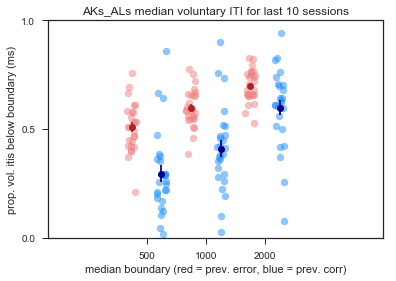

In [266]:
#plot mean & median of session means but by previous trial type not by animal

alpha = 0.5

x1 = [1.5]
y1 = [np.mean(reg_iti_fail_last10_adj_prop_below_all_500)]
yerr1 = [stats.sem(reg_iti_fail_last10_adj_prop_below_all_500)]
label1 = 'prev. err. prop. below = %.2f, bound = 500' %y1[0]

x2 = [4.5]
y2 = [np.mean(reg_iti_succ_last10_adj_prop_below_all_500)]
yerr2 = [stats.sem(reg_iti_succ_last10_adj_prop_below_all_500)]
label2 = 'prev. corr. prop. below = %.2f, bound = 500' %y2[0]

x3 = [7.5]
y3 = [np.mean(reg_iti_fail_last10_adj_prop_below_all_1000)]
yerr3 = [stats.sem(reg_iti_fail_last10_adj_prop_below_all_1000)]
label3 = 'prev. err. prop. below = %.2f, bound = 1000' %y3[0]

x4 = [10.5]
y4 = [np.mean(reg_iti_succ_last10_adj_prop_below_all_1000)]
yerr4 = [stats.sem(reg_iti_succ_last10_adj_prop_below_all_1000)]
label4 = 'prev. corr. prop. below = %.2f, bound = 1000' %y4[0]

x5 = [13.5]
y5 = [np.mean(reg_iti_fail_last10_adj_prop_below_all_2000)]
yerr5 = [stats.sem(reg_iti_fail_last10_adj_prop_below_all_2000)]
label5 = 'prev. err. prop. below = %.2f, bound = 2000' %y5[0]

x6 = [16.5]
y6 = [np.mean(reg_iti_succ_last10_adj_prop_below_all_2000)]
yerr6 = [stats.sem(reg_iti_succ_last10_adj_prop_below_all_2000)]
label6 = 'prev. corr. prop. below. = %.2f, bound = 2000' %y6[0]

plt.scatter(np.random.rand(1,26)+1, reg_iti_fail_last10_adj_prop_below_all_500, marker = 'o', color = 'lightcoral', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,26)+4, reg_iti_succ_last10_adj_prop_below_all_500, marker = 'o', color = 'dodgerblue', alpha = alpha, label = label2)
plt.scatter(np.random.rand(1,26)+7, reg_iti_fail_last10_adj_prop_below_all_1000, marker = 'o',  color = 'lightcoral', alpha = alpha, label = label3)
plt.scatter(np.random.rand(1,26)+10, reg_iti_succ_last10_adj_prop_below_all_1000, marker = 'o', color = 'dodgerblue', alpha = alpha, label = label4)
plt.scatter(np.random.rand(1,26)+13, reg_iti_fail_last10_adj_prop_below_all_2000, marker = 'o',  color = 'lightcoral', alpha = alpha, label = label5)
plt.scatter(np.random.rand(1,26)+16, reg_iti_succ_last10_adj_prop_below_all_2000, marker = 'o', color = 'dodgerblue', alpha = alpha, label = label6)

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'firebrick')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'darkblue')
plt.errorbar(x = x3, y = y3, yerr = yerr3, marker = 'o', color = 'firebrick')
plt.errorbar(x = x4, y = y4, yerr = yerr4, marker = 'o', color = 'darkblue')
plt.errorbar(x = x5, y = y5, yerr = yerr5, marker = 'o', color = 'firebrick')
plt.errorbar(x = x6, y = y6, yerr = yerr6, marker = 'o', color = 'darkblue')

# plt.legend()
# plt.xlim(-1,7)
# plt.ylim(0,1)
# plt.xticks([1.5, 4.5], ['previous error', 'previous correct'])
# plt.yticks([0, 0.5, 1.0])
# plt.xlabel('previous trial type')
# plt.ylabel('proportion of voluntary itis below 500 (ms)')
# plt.title('AKs_ALs mean ITI for last 10 sessions')
# # #plt.savefig('AKs_ALs_last10_prop_below_2000ms_vol_itis_corr_err_neat.pdf')

# plt.legend()
plt.xlim(-7,27)
plt.ylim(0,1)
# plt.xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5], ['prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.'])
plt.xticks([3, 9, 15], [500, 1000, 2000])
plt.yticks([0, 0.5, 1.0])
plt.xlabel('median boundary (red = prev. error, blue = prev. corr)')
plt.ylabel('prop. vol. itis below boundary (ms)')
plt.title('AKs_ALs median voluntary ITI for last 10 sessions')
# #plt.savefig('AKs_ALs_last10_vol_itis_prop_below_500_1000_2000ms_corr_err_neat.pdf')

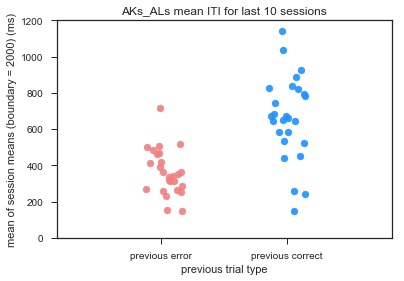

In [52]:
#plot mean of session means but by previous trial type not by animal

plt.scatter(np.random.rand(1,26)+1, reg_iti_fail_last10_adj_mean_mean, color = 'lightcoral', alpha = 0.9)
plt.scatter(np.random.rand(1,26)+4, reg_iti_succ_last10_adj_mean_mean, color = 'dodgerblue', alpha = 0.9)
plt.xlim(-1,7)
plt.ylim(0,1200)
plt.xticks([1.5, 4.5], ['previous error', 'previous correct'])
plt.xlabel('previous trial type')
plt.ylabel('mean of session means (boundary = 2000) (ms)')
plt.title('AKs_ALs mean ITI for last 10 sessions')
# #plt.savefig('AKs_ALs_last10_mean_itis_corr_err_neat.pdf')

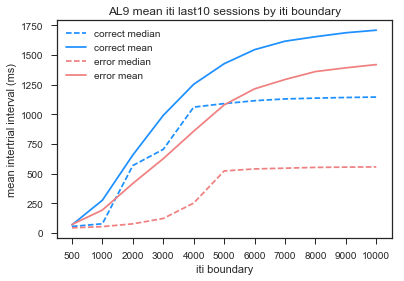

In [53]:
# see change in ITI mean and median as function of boundary

animal = 'AL9'

iti_data_succ = [item for sublist in reg_iti_succ_last10_adj[animal] for item in sublist]
iti_data_fail = [item for sublist in reg_iti_fail_last10_adj[animal] for item in sublist]

iti_data_succ_medians = []
iti_data_succ_means = []
iti_data_fail_medians = []
iti_data_fail_means = []
for lim in [500,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]:
    iti_data_succ_medians.append(np.median([i for i in iti_data_succ if i < lim]))
    iti_data_succ_means.append(np.mean([i for i in iti_data_succ if i < lim]))
    iti_data_fail_medians.append(np.median([i for i in iti_data_fail if i < lim]))
    iti_data_fail_means.append(np.mean([i for i in iti_data_fail if i < lim]))

plt.plot(iti_data_succ_medians, color = 'dodgerblue', linestyle = '--', label = 'correct median')
plt.plot(iti_data_succ_means, color = 'dodgerblue', linestyle = '-', label = 'correct mean')
plt.plot(iti_data_fail_medians, color = 'lightcoral', linestyle = '--', label = 'error median')
plt.plot(iti_data_fail_means, color = 'lightcoral', linestyle = '-', label = 'error mean')
plt.legend()
plt.ylabel('mean intertrial interval (ms)')
plt.xlabel('iti boundary')
plt.xticks(range(11), ['500','1000','2000','3000','4000','5000','6000','7000','8000','9000','10000'])
plt.title('%s mean iti last10 sessions by iti boundary' %animal)

In [54]:
nominrt_succ_rts

upper_boundary = 300
lower_boundary = 0

acc = {}
acc_err = {}
for animal in nominrt_succ_rts.keys():
    comp_list_succ = [item for sublist in nominrt_succ_rts[animal] for item in sublist]
    comp_list_fail = [item for sublist in nominrt_fail_rts[animal] for item in sublist]
    
    num_succ = len([i for i in comp_list_succ if lower_boundary < i < upper_boundary])
    num_fail = len([i for i in comp_list_fail if lower_boundary < i < upper_boundary])
    
    list_of_avg = []
    tot = np.concatenate((np.ones(num_succ), np.zeros(num_fail)))
    for i in xrange(bootstrap_iterations):
        r = np.random.choice(tot, len(tot))
        avg = np.mean(r)
        list_of_avg.append(avg)
    mean_error = np.std(list_of_avg)
    
    acc[animal] = num_succ / (num_succ + num_fail)
    acc_err[animal] = mean_error

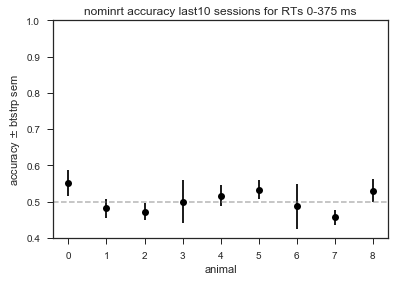

In [55]:
x = range(len(acc.values()))
y = acc.values()
yerr = acc_err.values()

plt.errorbar(x = x, y = y, yerr = yerr, color = 'k', marker = 'o', linestyle = ' ')
plt.axhline(0.5, color = 'gray', alpha = 0.5, linestyle = '--')
plt.ylim(0.4, 1.0)
plt.ylabel('accuracy $\pm$ btstrp sem')
plt.xlabel('animal')
plt.title('nominrt accuracy last10 sessions for RTs 0-375 ms')

In [56]:
lower_boundary = 0
upper_boundary = 3500
n_bins = 70
step_size = int((upper_boundary - lower_boundary)/n_bins)


acc = {}
acc_err = {}
for animal in nominrt_succ_rts.keys():
#     print animal
    
    comp_list_succ = [item for sublist in nominrt_succ_rts[animal] for item in sublist]
    comp_list_fail = [item for sublist in nominrt_fail_rts[animal] for item in sublist]
    
    num_succ = []
    num_fail = []
    for n in range(n_bins):
#         print n
        num_succ = len([i for i in comp_list_succ if (lower_boundary + n*step_size) < i < (lower_boundary + (n+1)*step_size)])
        num_fail = len([i for i in comp_list_fail if (lower_boundary + n*step_size) < i < (lower_boundary + (n+1)*step_size)])

        list_of_avg = []
        tot = np.concatenate((np.ones(num_succ), np.zeros(num_fail)))
        if len(tot) > 0:
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(tot, len(tot))
                avg = np.mean(r)
                list_of_avg.append(avg)
            mean_error = np.std(list_of_avg)
            
            try:
                acc[animal].append(num_succ / (num_succ + num_fail))
                acc_err[animal].append(mean_error)
            except KeyError:
                acc[animal] = [num_succ / (num_succ + num_fail)]
                acc_err[animal] = [mean_error]
        else:
            mean_error = float('nan')
            try:
                acc[animal].append(float('nan'))
                acc_err[animal].append(mean_error)
            except KeyError:
                acc[animal] = [float('nan')]
                acc_err[animal] = [mean_error]

/Users/javier/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/javier/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


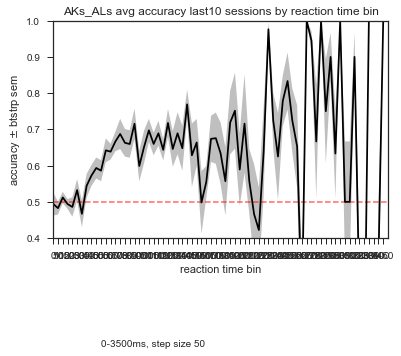

In [57]:
acc_avg = np.nanmean(acc.values(), axis = 0)
acc_sem = np.nanstd(acc.values(), axis = 0)/math.sqrt(len(acc.values()))

x = np.array(range(lower_boundary, upper_boundary, step_size))
y = acc_avg
yerr = acc_sem

plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'k')
plt.axhline(0.5, color = 'red', alpha = 0.5, linestyle = '--')
plt.ylim(0.4, 1)
plt.xlim(0,3500)
plt.xticks(xrange(0, 3500,50))
s = str(lower_boundary) + '-' + str(upper_boundary) + 'ms, step size ' + str(step_size)
plt.text(500, 0.1, s)
plt.ylabel('accuracy $\pm$ btstrp sem')
plt.xlabel('reaction time bin')
plt.title('AKs_ALs avg accuracy last10 sessions by reaction time bin')
# #plt.savefig('AKs_ALs_nominrt_avg_accuracy_last10_sessions_by_rt_bin.pdf')

### ITI and T0 Sensitivy Analyses

In [353]:
dcorr = 6.370 
derr = 3.136

# ~~~~~~modify tnot here for plotting~~~~~~
tnot = 0.35
    
min_iti = 0
max_iti = 2
step_iti = 0.1
i_t_i = np.arange(min_iti, max_iti + step_iti, step_iti)

x = np.asarray([(i+1)/len(binned_avg_reg_perf['y_bins_mean']) for i in range(len(binned_avg_reg_perf['y_bins_mean']))]) # normalized sessions
y = i_t_i 
X, Y = np.meshgrid(x, y)

binned_frac_max_rr = {}
for i in range(len(x)):
    norm_sesh = x[i]
    perf_sesh = binned_avg_reg_perf['y_bins_mean'][i]
    rt_sesh = binned_avg_reg_rt['y_bins_mean'][i]*0.001
#     iti_err = binned_avg_iti_err['y_bins_mean']
#     iti_corr = binned_avg_iti_corr['y_bins_mean']
    for j in range(len(y)):
        iti = y[j]
        binned_frac_max_rr[(iti, norm_sesh)] = percent_max_rr_iti(rt_sesh, perf_sesh, tnot, dcorr, derr, iti, iti, with_itis = True)['fraction_max_rr']
    
binned_frac_max_rr_list = []
for key in sorted(binned_frac_max_rr.keys()):
    binned_frac_max_rr_list.append(binned_frac_max_rr[key])

two_d_plot = np.reshape(np.asarray(binned_frac_max_rr_list), (len(y), len(x)))

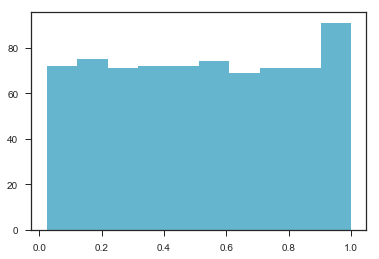

In [300]:
# calculate median by animal across last10 sessions with different boundaries

Dcorr = 6.370
Derr = 3.136

boundary = 500

reg_iti_succ_adj_500 = adjust_itis(reg_iti_succ, Dcorr)
reg_iti_succ_adj_mean_500, reg_iti_succ_adj_sem_500, reg_iti_succ_adj_median_500 = avg_adjusted_itis(reg_iti_succ_adj, boundary)
reg_iti_fail_adj_500 = adjust_itis(reg_iti_fail, Derr)
reg_iti_fail_adj_mean_500, reg_iti_fail_adj_sem_500, reg_iti_fail_adj_median_500 = avg_adjusted_itis(reg_iti_fail_adj, boundary)

boundary = 1000

reg_iti_succ_adj_1000 = adjust_itis(reg_iti_succ, Dcorr)
reg_iti_succ_adj_mean_1000, reg_iti_succ_adj_sem_1000, reg_iti_succ_adj_median_1000 = avg_adjusted_itis(reg_iti_succ_adj, boundary)
reg_iti_fail_adj_1000 = adjust_itis(reg_iti_fail, Derr)
reg_iti_fail_adj_mean_1000, reg_iti_fail_adj_sem_1000, reg_iti_fail_adj_median_1000 = avg_adjusted_itis(reg_iti_fail_adj, boundary)
    
boundary = 2000

reg_iti_succ_adj_2000 = adjust_itis(reg_iti_succ, Dcorr)
reg_iti_succ_adj_mean_2000, reg_iti_succ_adj_sem_2000, reg_iti_succ_adj_median_2000 = avg_adjusted_itis(reg_iti_succ_adj, boundary)
reg_iti_fail_adj_2000 = adjust_itis(reg_iti_fail, Derr)
reg_iti_fail_adj_mean_2000, reg_iti_fail_adj_sem_2000, reg_iti_fail_adj_median_2000 = avg_adjusted_itis(reg_iti_fail_adj, boundary)


# mesh data
meshed_reg_iti_err_median_500 = mesh_data(reg_iti_fail_adj_median_500, 'none')
meshed_reg_iti_corr_median_500 = mesh_data(reg_iti_succ_adj_median_500, 'none')
meshed_reg_iti_err_median_1000 = mesh_data(reg_iti_fail_adj_median_1000, 'none')
meshed_reg_iti_corr_median_1000 = mesh_data(reg_iti_succ_adj_median_1000, 'none')
meshed_reg_iti_err_median_2000 = mesh_data(reg_iti_fail_adj_median_2000, 'none')
meshed_reg_iti_corr_median_2000 = mesh_data(reg_iti_succ_adj_median_2000, 'none')

n_bins = 10
binned_avg_reg_iti_err_median_500 = avg_binned_data(meshed_reg_iti_err_median_500, n_bins)
binned_avg_reg_iti_corr_median_500 = avg_binned_data(meshed_reg_iti_corr_median_500, n_bins)
binned_avg_reg_iti_err_median_1000 = avg_binned_data(meshed_reg_iti_err_median_1000, n_bins)
binned_avg_reg_iti_corr_median_1000 = avg_binned_data(meshed_reg_iti_corr_median_1000, n_bins)
binned_avg_reg_iti_err_median_2000 = avg_binned_data(meshed_reg_iti_err_median_2000, n_bins)
binned_avg_reg_iti_corr_median_2000 = avg_binned_data(meshed_reg_iti_corr_median_2000, n_bins)

# get weighted average of voluntary itis with the error rate

binned_avg_reg_weighted_iti_median_500 = []
binned_avg_reg_weighted_iti_median_1000 = []
binned_avg_reg_weighted_iti_median_2000 = []
for i in range(len(binned_avg_reg_perf)+1):
    weighted_val = binned_avg_reg_iti_err_median_500['y_bins_mean'][i]*(1 - binned_avg_reg_perf['y_bins_mean'][i]) + binned_avg_reg_iti_corr_median_500['y_bins_mean'][i]*binned_avg_reg_perf['y_bins_mean'][i]
    binned_avg_reg_weighted_iti_median_500.append(weighted_val)
    
    weighted_val = binned_avg_reg_iti_err_median_1000['y_bins_mean'][i]*(1 - binned_avg_reg_perf['y_bins_mean'][i]) + binned_avg_reg_iti_corr_median_1000['y_bins_mean'][i]*binned_avg_reg_perf['y_bins_mean'][i]
    binned_avg_reg_weighted_iti_median_1000.append(weighted_val)
    
    weighted_val = binned_avg_reg_iti_err_median_2000['y_bins_mean'][i]*(1 - binned_avg_reg_perf['y_bins_mean'][i]) + binned_avg_reg_iti_corr_median_2000['y_bins_mean'][i]*binned_avg_reg_perf['y_bins_mean'][i]
    binned_avg_reg_weighted_iti_median_2000.append(weighted_val)

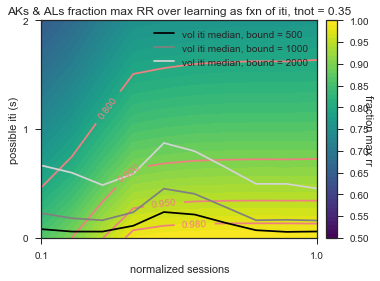

In [354]:
plt.close()
# plt.figure(1)
# plt.figure(figsize = (10,6))

#     plt.subplot(111)
levels = np.linspace(0.5, 1.0, 51) # to create smooth contour spacing
plt.contourf(X, Y, two_d_plot, levels = levels, cmap = 'viridis') # filled contour plot with data
ticks = np.linspace(0.5, 1.0, 11)
cbar = plt.colorbar(ticks = ticks, pad = 0.025)
cbar.set_label('fraction max rr', rotation = '270')
#     plt.subplot(111)
levels2 = [0.80, 0.90, 0.95, 0.98] #np.linspace(0.9, 1.0, 3) # to create contour line at 0.95
ninetyfive = plt.contour(X, Y, two_d_plot, levels = levels2, colors = 'lightcoral') # contour line at 0.95
plt.clabel(ninetyfive, levels2)

# plt.plot(x, [i*0.001 for i in binned_avg_reg_iti_err['y_bins_mean']], label = 'empirical failure iti mean', color = 'firebrick')
# plt.plot(x, [i*0.001 for i in binned_avg_reg_iti_err_median['y_bins_mean']], label = 'empirical failure iti median', color = 'lightcoral')
# plt.plot(x, [i*0.001 for i in binned_avg_reg_iti_corr['y_bins_mean']], label = 'empirical success iti mean', color = 'darkblue')
# plt.plot(x, [i*0.001 for i in binned_avg_reg_iti_corr_median['y_bins_mean']], label = 'empirical success iti median', color = 'dodgerblue')

plt.plot(x, [i*0.001 for i in binned_avg_reg_weighted_iti_median_500], label = 'vol iti median, bound = 500', color = 'k')
plt.plot(x, [i*0.001 for i in binned_avg_reg_weighted_iti_median_1000], label = 'vol iti median, bound = 1000', color = 'grey')
plt.plot(x, [i*0.001 for i in binned_avg_reg_weighted_iti_median_2000], label = 'vol iti median, bound = 2000', color = 'lightgray')


# plt.plot(x, [i*0.001 for i in binned_avg_reg_iti_all['y_bins_mean']], label = 'empirical all_trials iti')
plt.legend()

plt.xticks([0.1, 1.0])
plt.yticks([0, 1, 2])

plt.xlabel('normalized sessions')
plt.ylabel('possible iti (s)')
plt.title('AKs & ALs fraction max RR over learning as fxn of iti, tnot = %.2f' %tnot)
#plt.savefig('AKs_ALs_fraction_max_rr_over_binned_learning_as_fx_iti_weighted_vol_itis_tnot=%.2f_updated_Drsi.pdf' %tnot)

In [274]:
dcorr = 6.370 
derr = 3.136

# ~~~~~~modify tnot here for plotting~~~~~~
min_tnot = 0.16
max_tnot = 0.35
step_tnot = 0.01
t_n_o_t = np.arange(min_tnot, max_tnot + step_tnot, step_tnot)
    
# min_iti = 0
# max_iti = 2
# step_iti = 0.1
# i_t_i = np.arange(min_iti, max_iti + step_iti, step_iti)

x = np.asarray([(i+1)/len(binned_avg_reg_perf['y_bins_mean']) for i in range(len(binned_avg_reg_perf['y_bins_mean']))]) # normalized sessions
y = t_n_o_t 
X, Y = np.meshgrid(x, y)

binned_frac_max_rr = {}
for i in range(len(x)):
    norm_sesh = x[i]
    perf_sesh = binned_avg_reg_perf['y_bins_mean'][i]
    rt_sesh = binned_avg_reg_rt['y_bins_mean'][i]*0.001
    # mean ITIs
#     iti_err = binned_avg_reg_iti_err['y_bins_median'][i]
#     iti_corr = binned_avg_reg_iti_corr['y_bins_median'][i] 
    # median ITIs
    iti_err_sesh = binned_avg_reg_iti_err_median['y_bins_mean'][i]*0.001
    iti_corr_sesh = binned_avg_reg_iti_corr_median['y_bins_mean'][i]*0.001
    
    for j in range(len(y)):
        tnot = y[j]
        binned_frac_max_rr[(tnot, norm_sesh)] = percent_max_rr_iti(rt_sesh, perf_sesh, tnot, dcorr, derr, iti_corr_sesh, iti_err_sesh, with_itis = True)['fraction_max_rr']
    
binned_frac_max_rr_list = []
for key in sorted(binned_frac_max_rr.keys()):
    binned_frac_max_rr_list.append(binned_frac_max_rr[key])

two_d_plot = np.reshape(np.asarray(binned_frac_max_rr_list), (len(y), len(x)))

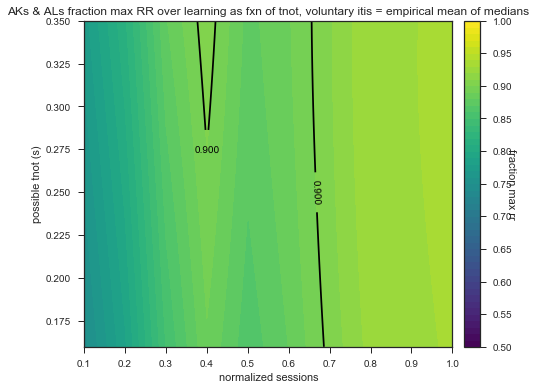

In [275]:
plt.close()
plt.figure(1)
plt.figure(figsize = (8,6))

#     plt.subplot(111)
levels = np.linspace(0.5, 1.0, 51) # to create smooth contour spacing
plt.contourf(X, Y, two_d_plot, levels = levels, cmap = 'viridis') # filled contour plot with data
ticks = np.linspace(0.5, 1.0, 11)
cbar = plt.colorbar(ticks = ticks, pad = 0.025)
cbar.set_label('fraction max rr', rotation = '270')
#     plt.subplot(111)

levels2 = [0.90, 0.95, 0.975] #np.linspace(0.9, 1.0, 3) # to create contour line at 0.95
ninetyfive = plt.contour(X, Y, two_d_plot, levels = levels2, colors = 'k') # contour line at 0.95
plt.clabel(ninetyfive, levels2)

# plt.plot(x, [i*0.001 for i in binned_avg_reg_iti_err['y_bins_mean']], label = 'empirical failure iti mean', color = 'firebrick')
# plt.plot(x, [i*0.001 for i in binned_avg_reg_iti_err_median['y_bins_mean']], label = 'empirical failure iti median', color = 'lightcoral')
# plt.plot(x, [i*0.001 for i in binned_avg_reg_iti_corr['y_bins_mean']], label = 'empirical success iti mean', color = 'darkblue')
# plt.plot(x, [i*0.001 for i in binned_avg_reg_iti_corr_median['y_bins_mean']], label = 'empirical success iti median', color = 'dodgerblue')
# plt.plot(x, [i*0.001 for i in binned_avg_reg_iti_all['y_bins_mean']], label = 'empirical all_trials iti')
plt.legend()
plt.xlabel('normalized sessions')
plt.ylabel('possible tnot (s)')
plt.title('AKs & ALs fraction max RR over learning as fxn of tnot, voluntary itis = empirical mean of medians')
# #plt.savefig('AKs_ALs_fraction_max_rr_over_binned_learning_as_fx_tnot_empirical_vol_itis_updated_Drsi.pdf')

In [276]:
# extract performance and reaction time data from results_AK_AL

perf = {}
rt = {}
perf_err = {}
rt_err = {}

for animal in results_AK_AL.keys():
    if animal not in ['AL12']:
        for session in sorted(results_AK_AL[animal]['pct_correct_by_session'].keys()):
            try:
                perf[animal].append(results_AK_AL[animal]['pct_correct_by_session'][session])
                rt[animal].append(results_AK_AL[animal]['avg_rt_success_by_session'][session]*0.001)
                perf_err[animal].append(results_AK_AL[animal]['pct_correct_bootstrap_error_by_session'][session])
                rt_err[animal].append(results_AK_AL[animal]['rt_success_bootstrap_error_by_session'][session]*0.001)
            except KeyError:
                perf[animal] = [results_AK_AL[animal]['pct_correct_by_session'][session]]
                rt[animal] = [results_AK_AL[animal]['avg_rt_success_by_session'][session]*0.001]
                perf_err[animal] = [results_AK_AL[animal]['pct_correct_bootstrap_error_by_session'][session]]
                rt_err[animal] = [results_AK_AL[animal]['rt_success_bootstrap_error_by_session'][session]*0.001]
        
        iti_error = reg_iti_fail_adj_median
        iti_corr = reg_iti_succ_adj_median
#         iti_error = reg_iti_fail_adj_mean
#         iti_corr = reg_iti_corr_adj_mean 

#### changing t0 over fixed voluntary itis (or no voluntary itis)

In [277]:
## WARNING: this cell takes a long time to run

# calculate percent max reward rate with performance and reaction time data
# calculate for a range of t0  

min_t0 = 0.16
max_t0 = 0.35
step_t0 = 0.01
t_not = np.linspace(min_t0, max_t0, int(round((max_t0 - min_t0)/step_t0))+1) # (max_t0-min_t0) must be a multiple of step_t0 for this formula to work

t0_fraction_max_rr = {}
for t0 in t_not:
    fraction_max_rr = {}
    for animal in reg_perf.keys():
        for i in range(len(reg_perf[animal])):
            try:
                fraction_max_rr[animal].append(percent_max_rr_iti(rt = rt[animal][i], perf = perf[animal][i], t0 = t0)['fraction_max_rr'])
            except KeyError:
                fraction_max_rr[animal] = [percent_max_rr_iti(rt = rt[animal][i], perf = perf[animal][i], t0 = t0)['fraction_max_rr']]
    t0_fraction_max_rr[t0] = fraction_max_rr
    
t0_fraction_max_rr_err = {}
for t0 in t_not:
    fraction_max_rr_err = {}
    for animal in perf.keys():
            for i in range(len(perf[animal])):
                topright = (rt[animal][i] + rt_err[animal][i], max(0.501, perf[animal][i] - perf_err[animal][i]))
                bottleft = (rt[animal][i] - rt_err[animal][i], max(0.501, perf[animal][i] + perf_err[animal][i]))
                topright_frac_max_err = percent_max_rr_iti(topright[0], topright[1], t0)['fraction_max_rr']
                bottleft_frac_max_err = percent_max_rr_iti(bottleft[0], bottleft[1], t0)['fraction_max_rr']
                topright_err = abs(fraction_max_rr[animal][i] - topright_frac_max_err)
                bottleft_err = abs(bottleft_frac_max_err - fraction_max_rr[animal][i])                    
                try:
                    fraction_max_rr_err[animal].append((topright_err, bottleft_err))
                except KeyError:
                    fraction_max_rr_err[animal] = [(topright_err, bottleft_err)]
    t0_fraction_max_rr_err[t0] = fraction_max_rr_err
    
# if using voluntary ITIs

# t0_fraction_max_rr = {}
# for t0 in t_not:
#     fraction_max_rr = {}
#     for animal in reg_perf.keys():
#         for i in range(len(reg_perf[animal])):
#             try:
#                 fraction_max_rr[animal].append(percent_max_rr_iti(rt = rt[animal][i], perf = perf[animal][i], t0 = t0, dcorr = dcorr, derr = derr, corr_iti = iti_corr[animal][i]*0.001, err_iti = iti_error[animal][i]*0.001, with_itis = True)['fraction_max_rr'])
#             except KeyError:
#                 fraction_max_rr[animal] = [percent_max_rr_iti(rt = rt[animal][i], perf = perf[animal][i], t0 = t0, dcorr = dcorr, derr = derr, corr_iti = iti_corr[animal][i]*0.001, err_iti = iti_error[animal][i]*0.001, with_itis = True)['fraction_max_rr']]
#     t0_fraction_max_rr[t0] = fraction_max_rr    
    
# t0_fraction_max_rr_err = {}
# for t0 in t_not:
#     fraction_max_rr_err = {}
#     for animal in perf.keys():
#             for i in range(len(perf[animal])):
#                 topright = (rt[animal][i] + rt_err[animal][i], max(0.501, perf[animal][i] - perf_err[animal][i]))
#                 bottleft = (rt[animal][i] - rt_err[animal][i], max(0.501, perf[animal][i] + perf_err[animal][i]))
#                 topright_frac_max_err = percent_max_rr_iti(topright[0], topright[1], t0)['fraction_max_rr']
#                 bottleft_frac_max_err = percent_max_rr_iti(bottleft[0], bottleft[1], t0)['fraction_max_rr']
#                 topright_err = abs(fraction_max_rr[animal][i] - topright_frac_max_err)
#                 bottleft_err = abs(bottleft_frac_max_err - fraction_max_rr[animal][i])                    
#                 try:
#                     fraction_max_rr_err[animal].append((topright_err, bottleft_err))
#                 except KeyError:
#                     fraction_max_rr_err[animal] = [(topright_err, bottleft_err)]
#     t0_fraction_max_rr_err[t0] = fraction_max_rr_err
                
# print t0_fraction_max_rr_err

# calculate the average and standard deviation of percent max reward rate
# do so for trained animals (last 10 sessions) and naive animals (first 5 sessions)

t0_trained_avg_max_rr = {}
t0_trained_std_max_rr = {}
t0_naive_avg_max_rr = {}
t0_naive_std_max_rr = {}

for t0 in t_not:
    trained_avg_max_rr = {}
    trained_std_max_rr = {}
    naive_avg_max_rr = {}
    naive_std_max_rr = {}
    for animal in t0_fraction_max_rr[t0].keys():
        trained_avg_max_rr[animal] = np.mean(t0_fraction_max_rr[t0][animal][-10:]) # last ten sessions
        trained_std_max_rr[animal] = np.std(t0_fraction_max_rr[t0][animal][-10:]) # last ten sessions
        naive_avg_max_rr[animal] = np.mean(t0_fraction_max_rr[t0][animal][:5]) # first five sessions
        naive_std_max_rr[animal] = np.std(t0_fraction_max_rr[t0][animal][:5]) # first five sessions
    t0_trained_avg_max_rr[t0] = trained_avg_max_rr
    t0_trained_std_max_rr[t0] = trained_std_max_rr
    t0_naive_avg_max_rr[t0] = naive_avg_max_rr
    t0_naive_std_max_rr[t0] = naive_std_max_rr 

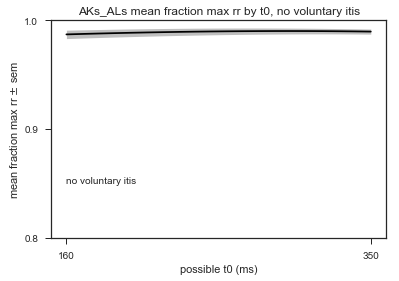

In [278]:
sorted_t0 = sorted(t0_trained_avg_max_rr) # sorted keys

t0_all_trained_avg_max_rr = []
t0_all_trained_avg_max_rr_err = []
for t0 in sorted_t0:
    t0_all_trained_avg_max_rr.append(np.mean(t0_trained_avg_max_rr[t0].values()))
    t0_all_trained_avg_max_rr_err.append(np.std(t0_trained_avg_max_rr[t0].values())/math.sqrt(len(t0_trained_avg_max_rr[t0].values())))
    
y = np.array(t0_all_trained_avg_max_rr)
yerr = np.array(t0_all_trained_avg_max_rr_err)
x = np.array(range(len(y)))

xticklabels = [int(round(i*1000)) for i in sorted_t0]

# plt.errorbar(x = x, y = y, yerr = yerr)
plt.errorbar(x = x, y = y, color = 'k')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
plt.xlabel('possible t0 (ms)')
plt.ylabel('mean fraction max rr $\pm$ sem')
plt.ylim(0.8, 1)

s = 'no voluntary itis' #, median, boundary = 1000 ms'
plt.text(0, 0.85, s)

plt.yticks([0.8, 0.9, 1])
plt.xticks([0, 19], [160, 350])
# plt.xticks(x, xticklabels)
plt.title('AKs_ALs mean fraction max rr by t0, no voluntary itis')
# #plt.savefig('AKs_ALs_mean_fraction_max_rr_for_diff_t0s_no_vol_itis.pdf')#_by_animal_median_boundary_1000.pdf')

#### changing voluntary itis over fixed t0

In [364]:
## WARNING: this cell takes a long time to run

# calculate percent max reward rate with performance and reaction time data
# calculate for a range of voluntary itis  

dcorr = 6.370
derr = 3.136
t0 = 0.16

min_iti = 0
max_iti = 2
step_iti = 0.2
i_t_i = np.linspace(min_iti, max_iti, int(round((max_iti - min_iti)/step_iti))+1) # (max_iti-min_iti) must be a multiple of step_t0 for this formula to work

iti_fraction_max_rr = {}
for iti in i_t_i:
    fraction_max_rr = {}
    for animal in reg_perf.keys():
        for i in range(len(reg_perf[animal])):
            try:
                fraction_max_rr[animal].append(percent_max_rr_iti(rt = rt[animal][i], perf = perf[animal][i], t0 = t0, dcorr = dcorr, derr = derr, corr_iti = iti, err_iti = iti, with_itis = True)['fraction_max_rr'])
            except KeyError:
                fraction_max_rr[animal] = [percent_max_rr_iti(rt = rt[animal][i], perf = perf[animal][i], t0 = t0, dcorr = dcorr, derr = derr, corr_iti = iti, err_iti = iti, with_itis = True)['fraction_max_rr']]
    iti_fraction_max_rr[iti] = fraction_max_rr

    
iti_fraction_max_rr_err = {}
for iti in i_t_i:
    fraction_max_rr_err = {}
    for animal in perf.keys():
            for i in range(len(perf[animal])):
                topright = (rt[animal][i] + rt_err[animal][i], max(0.501, perf[animal][i] - perf_err[animal][i]))
                bottleft = (rt[animal][i] - rt_err[animal][i], max(0.501, perf[animal][i] + perf_err[animal][i]))
                topright_frac_max_err = percent_max_rr_iti(rt = topright[0], perf = topright[1], t0 = t0, dcorr = dcorr, derr = derr, corr_iti = iti, err_iti = iti, with_itis = True)['fraction_max_rr']
                bottleft_frac_max_err = percent_max_rr_iti(rt = bottleft[0], perf = bottleft[1], t0 = t0, dcorr = dcorr, derr = derr, corr_iti = iti, err_iti = iti, with_itis = True)['fraction_max_rr']
                topright_err = abs(fraction_max_rr[animal][i] - topright_frac_max_err)
                bottleft_err = abs(bottleft_frac_max_err - fraction_max_rr[animal][i])

#                 def percent_max_rr_iti(rt, perf, t0 = 0.350, dcorr = 6.370, derr = 3.136, corr_iti = 0, err_iti = 0, with_itis = False):         
                    
                try:
                    fraction_max_rr_err[animal].append((topright_err, bottleft_err))
                except KeyError:
                    fraction_max_rr_err[animal] = [(topright_err, bottleft_err)]
    iti_fraction_max_rr_err[iti] = fraction_max_rr_err
                
# print t0_fraction_max_rr_err

# calculate the average and standard deviation of percent max reward rate
# do so for trained animals (last 10 sessions) and naive animals (first 5 sessions)

iti_trained_avg_max_rr = {}
iti_trained_std_max_rr = {}
iti_naive_avg_max_rr = {}
iti_naive_std_max_rr = {}

for iti in i_t_i:
    trained_avg_max_rr = {}
    trained_std_max_rr = {}
    naive_avg_max_rr = {}
    naive_std_max_rr = {}
    for animal in iti_fraction_max_rr[iti].keys():
        trained_avg_max_rr[animal] = np.mean(iti_fraction_max_rr[iti][animal][-10:]) # last ten sessions
        trained_std_max_rr[animal] = np.std(iti_fraction_max_rr[iti][animal][-10:]) # last ten sessions
        naive_avg_max_rr[animal] = np.mean(iti_fraction_max_rr[iti][animal][:5]) # first five sessions
        naive_std_max_rr[animal] = np.std(iti_fraction_max_rr[iti][animal][:5]) # first five sessions
    iti_trained_avg_max_rr[iti] = trained_avg_max_rr
    iti_trained_std_max_rr[iti] = trained_std_max_rr
    iti_naive_avg_max_rr[iti] = naive_avg_max_rr
    iti_naive_std_max_rr[iti] = naive_std_max_rr 

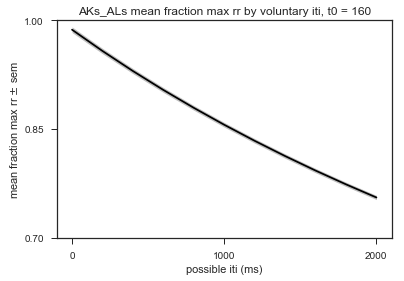

In [365]:
sorted_iti = sorted(iti_trained_avg_max_rr) # sorted keys

iti_all_trained_avg_max_rr = []
iti_all_trained_avg_max_rr_err = []
for iti in sorted_iti:
    iti_all_trained_avg_max_rr.append(np.mean(iti_trained_avg_max_rr[iti].values()))
    iti_all_trained_avg_max_rr_err.append(np.std(iti_trained_avg_max_rr[iti].values())/math.sqrt(len(iti_trained_avg_max_rr[iti].values())))
    
y = np.array(iti_all_trained_avg_max_rr)
yerr = np.array(iti_all_trained_avg_max_rr_err)
x = np.array(range(len(y)))



# plt.errorbar(x = x, y = y, yerr = yerr)
plt.errorbar(x = x, y = y, color = 'k')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
plt.xlabel('possible iti (ms)')
plt.ylabel('mean fraction max rr $\pm$ sem')
plt.ylim(0.7, 1)
plt.yticks([0.7, 0.85, 1])

plt.xticks([0, 5, 10], [0, 1000, 2000])
# xticklabels = [int(round(i*1000)) for i in sorted_iti]
# plt.xticks(x, xticklabels)

plt.title('AKs_ALs mean fraction max rr by voluntary iti, t0 = %d' %(t0*1000))
#plt.savefig('AKs_ALs_mean_fraction_max_rr_for_diff_vol_itis_up_to_2000_t0 = %d.pdf' %(t0*1000))

#### Same analysis with AN cohort (canonical only)

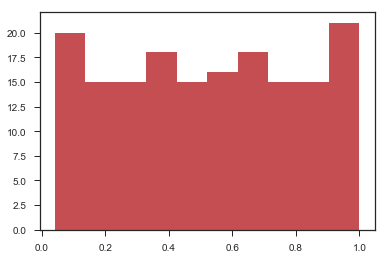

In [690]:
T0 = 160
Derr = 3136
Dcorr = 6370
boundary = 500
with_itis = True

can_iti_succ_adj = adjust_itis(can_iti_succ, Dcorr)
can_iti_succ_adj_mean, can_iti_succ_adj_sem, can_iti_succ_adj_median = avg_adjusted_itis(can_iti_succ_adj, boundary)

can_iti_fail_adj = adjust_itis(can_iti_fail, Derr)
can_iti_fail_adj_mean, can_iti_fail_adj_sem, can_iti_fail_adj_median = avg_adjusted_itis(can_iti_fail_adj, boundary)

# can_dt = convert_RTs_to_DTs(can_rt_succ, can_iti_fail_adj_mean, T0, Derr, with_itis)
can_dt = convert_RTs_to_DTs(can_rt_succ, can_iti_fail_adj_median, T0, Derr, with_itis) # use median iti_fail_adj
can_dt_err = calc_DT_err(can_rt_succ_err, can_iti_fail_adj_sem, T0, Derr, with_itis)

# mesh data

meshed_can_rt = mesh_data(can_rt_succ, 'none')
meshed_can_rt_err = mesh_data(can_rt_succ_err, 'none')
meshed_can_dt = mesh_data(can_dt, 'none')
meshed_can_perf = mesh_data(can_perf, 'none')
meshed_can_perf_err = mesh_data(can_perf_err, 'none')
meshed_can_iti_err = mesh_data(can_iti_fail_adj_mean, 'none')
meshed_can_iti_corr = mesh_data(can_iti_succ_adj_mean, 'none')
meshed_can_iti_err_median = mesh_data(can_iti_fail_adj_median, 'none')
meshed_can_iti_corr_median = mesh_data(can_iti_succ_adj_median, 'none')


n_bins = 10
binned_avg_can_rt = avg_binned_data(meshed_can_rt, n_bins)
binned_avg_can_rt_err = avg_binned_data(meshed_can_rt_err, n_bins)
binned_avg_can_dt = avg_binned_data(meshed_can_dt, n_bins)
binned_avg_can_perf = avg_binned_data(meshed_can_perf, n_bins)
binned_avg_can_perf_err = avg_binned_data(meshed_can_perf_err, n_bins)
binned_avg_can_iti_err = avg_binned_data(meshed_can_iti_err, n_bins)
binned_avg_can_iti_corr = avg_binned_data(meshed_can_iti_corr, n_bins)
binned_avg_can_iti_err_median = avg_binned_data(meshed_can_iti_err_median, n_bins)
binned_avg_can_iti_corr_median = avg_binned_data(meshed_can_iti_corr_median, n_bins)


# itis with different boundaries

boundary = 500

can_iti_succ_adj_mean_500, can_iti_succ_adj_sem_500, can_iti_succ_adj_median_500 = avg_adjusted_itis(can_iti_succ_adj, boundary)
can_iti_fail_adj_mean_500, can_iti_fail_adj_sem_500, can_iti_fail_adj_median_500 = avg_adjusted_itis(can_iti_fail_adj, boundary)
meshed_can_iti_err_500 = mesh_data(can_iti_fail_adj_mean_500, 'none')
meshed_can_iti_corr_500 = mesh_data(can_iti_succ_adj_mean_500, 'none')
meshed_can_iti_err_median_500 = mesh_data(can_iti_fail_adj_median_500, 'none')
meshed_can_iti_corr_median_500 = mesh_data(can_iti_succ_adj_median_500, 'none')
binned_avg_can_iti_err_500 = avg_binned_data(meshed_can_iti_err_500, n_bins)
binned_avg_can_iti_corr_500 = avg_binned_data(meshed_can_iti_corr_500, n_bins)
binned_avg_can_iti_err_median_500 = avg_binned_data(meshed_can_iti_err_median_500, n_bins)
binned_avg_can_iti_corr_median_500 = avg_binned_data(meshed_can_iti_corr_median_500, n_bins)

boundary = 1000

can_iti_succ_adj_mean_1000, can_iti_succ_adj_sem_1000, can_iti_succ_adj_median_1000 = avg_adjusted_itis(can_iti_succ_adj, boundary)
can_iti_fail_adj_mean_1000, can_iti_fail_adj_sem_1000, can_iti_fail_adj_median_1000 = avg_adjusted_itis(can_iti_fail_adj, boundary)
meshed_can_iti_err_1000 = mesh_data(can_iti_fail_adj_mean_1000, 'none')
meshed_can_iti_corr_1000 = mesh_data(can_iti_succ_adj_mean_1000, 'none')
meshed_can_iti_err_median_1000 = mesh_data(can_iti_fail_adj_median_1000, 'none')
meshed_can_iti_corr_median_1000 = mesh_data(can_iti_succ_adj_median_1000, 'none')
binned_avg_can_iti_err_1000 = avg_binned_data(meshed_can_iti_err_1000, n_bins)
binned_avg_can_iti_corr_1000 = avg_binned_data(meshed_can_iti_corr_1000, n_bins)
binned_avg_can_iti_err_median_1000 = avg_binned_data(meshed_can_iti_err_median_1000, n_bins)
binned_avg_can_iti_corr_median_1000 = avg_binned_data(meshed_can_iti_corr_median_1000, n_bins)

boundary = 2000

can_iti_succ_adj_mean_2000, can_iti_succ_adj_sem_2000, can_iti_succ_adj_median_2000 = avg_adjusted_itis(can_iti_succ_adj, boundary)
can_iti_fail_adj_mean_2000, can_iti_fail_adj_sem_2000, can_iti_fail_adj_median_2000 = avg_adjusted_itis(can_iti_fail_adj, boundary)
meshed_can_iti_err_2000 = mesh_data(can_iti_fail_adj_mean_2000, 'none')
meshed_can_iti_corr_2000 = mesh_data(can_iti_succ_adj_mean_2000, 'none')
meshed_can_iti_err_median_2000 = mesh_data(can_iti_fail_adj_median_2000, 'none')
meshed_can_iti_corr_median_2000 = mesh_data(can_iti_succ_adj_median_2000, 'none')
binned_avg_can_iti_err_2000 = avg_binned_data(meshed_can_iti_err, n_bins)
binned_avg_can_iti_corr_2000 = avg_binned_data(meshed_can_iti_corr_2000, n_bins)
binned_avg_can_iti_err_median_2000 = avg_binned_data(meshed_can_iti_err_median_2000, n_bins)
binned_avg_can_iti_corr_median_2000 = avg_binned_data(meshed_can_iti_corr_median_2000, n_bins)

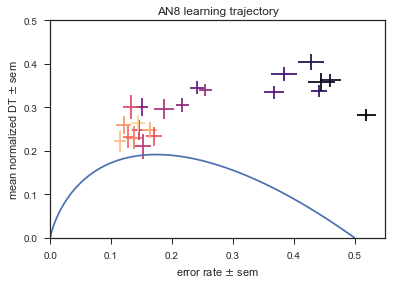

In [401]:
opc_during_learning(can_perf, can_perf_err, can_dt, can_dt_err, '_graphs_opc_during_learning/%s_opc_during_learning_t0_350ms_with_iti_median_by_session_0_to_500ms.pdf')

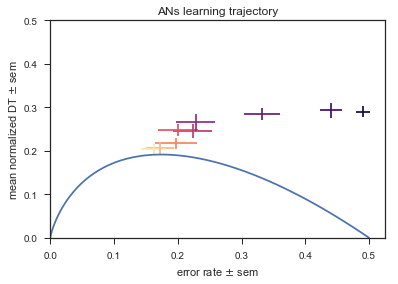

In [696]:
opc_during_learning_from_list(binned_avg_can_perf['y_bins_mean'], binned_avg_can_perf['y_bins_sem'], binned_avg_can_dt['y_bins_mean'], binned_avg_can_dt['y_bins_sem'],'ANs','_graphs_opc_during_learning/ANs_opc_during_learning_with_iti_median_by_session_0_to_2000ms_t0_160ms_10bins.pdf')

trained animals

In [771]:
# ~~~~~~~~~~~~iti and dt~~~~~~~~~~~~~~~~

T0 = 160
Derr = 3136
Dcorr = 6370
boundary = 500 # iti max for averaging (e.g. up to 2000 ms)
with_itis = True # include itis in DT and percent max RR

# last 2 sessions

can_iti_succ_last2_adj = adjust_itis(can_iti_succ_last2, Dcorr)
can_iti_succ_last2_adj_mean, can_iti_succ_last2_adj_sem, can_iti_succ_last2_adj_median = avg_adjusted_itis(can_iti_succ_last2_adj, boundary)

can_iti_fail_last2_adj = adjust_itis(can_iti_fail_last2, Derr)
can_iti_fail_last2_adj_mean, can_iti_fail_last2_adj_sem, can_iti_fail_last2_adj_median = avg_adjusted_itis(can_iti_fail_last2_adj, boundary)

can_dt_last2 = convert_RTs_to_DTs(can_rt_succ_last2, can_iti_fail_last2_adj_median, T0, Derr, with_itis)
can_dt_err_last2 = calc_DT_err(can_rt_succ_err_last2, can_iti_fail_last2_adj_sem, T0, Derr, with_itis)

# last 5 sessions

can_iti_succ_last5_adj = adjust_itis(can_iti_succ_last5, Dcorr)
can_iti_succ_last5_adj_mean, can_iti_succ_last5_adj_sem, can_iti_succ_last5_adj_median = avg_adjusted_itis(can_iti_succ_last5_adj, boundary)

can_iti_fail_last5_adj = adjust_itis(can_iti_fail_last5, Derr)
can_iti_fail_last5_adj_mean, can_iti_fail_last5_adj_sem, can_iti_fail_last5_adj_median = avg_adjusted_itis(can_iti_fail_last5_adj, boundary)

can_dt_last5 = convert_RTs_to_DTs(can_rt_succ_last5, can_iti_fail_last5_adj_median, T0, Derr, with_itis)
can_dt_err_last5 = calc_DT_err(can_rt_succ_err_last5, can_iti_fail_last5_adj_sem, T0, Derr, with_itis)

# last 10 sessions

can_iti_succ_last10_adj = adjust_itis(can_iti_succ_last10, Dcorr)
can_iti_succ_last10_adj_mean, can_iti_succ_last10_adj_sem, can_iti_succ_last10_adj_median = avg_adjusted_itis(can_iti_succ_last10_adj, boundary)

can_iti_fail_last10_adj = adjust_itis(can_iti_fail_last10, Derr)
can_iti_fail_last10_adj_mean, can_iti_fail_last10_adj_sem, can_iti_fail_last10_adj_median = avg_adjusted_itis(can_iti_fail_last10_adj, boundary)

can_dt_last10 = convert_RTs_to_DTs(can_rt_succ_last10, can_iti_fail_last10_adj_median, T0, Derr, with_itis)
can_dt_err_last10 = calc_DT_err(can_rt_succ_err_last10, can_iti_fail_last10_adj_sem, T0, Derr, with_itis)

# ~~~~~~~~~~~~~~~percent max rr~~~~~~~~~~~~~

T0 = 160*0.001 # convert to seconds
Dcorr = 6370*0.001 # convert to seconds
Derr = 3136*0.001 # convert to seconds
pct_max_rr_data = 'fraction_max_rr' # 'opportunity_cost'

# last 2 sessions
perf_dict = can_perf_last2
rt_dict = can_rt_succ_last2
corr_iti_dict = can_iti_succ_last2_adj_mean
err_iti_dict = can_iti_fail_last2_adj_mean

can_pct_max_rr_last2 = {}
for animal in perf_dict.keys():
    for session in range(len(perf_dict[animal])):
        try:
            can_pct_max_rr_last2[animal].append(percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data])
        except KeyError:
            can_pct_max_rr_last2[animal] = [percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data]]

# last 5 sessions
perf_dict = can_perf_last5
rt_dict = can_rt_succ_last5
corr_iti_dict = can_iti_succ_last5_adj_mean
err_iti_dict = can_iti_fail_last5_adj_mean

can_pct_max_rr_last5 = {}
for animal in perf_dict.keys():
    for session in range(len(perf_dict[animal])):
        try:
            can_pct_max_rr_last5[animal].append(percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data])
        except KeyError:
            can_pct_max_rr_last5[animal] = [percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data]]

# last 10 sessions
perf_dict = can_perf_last10
rt_dict = can_rt_succ_last10
corr_iti_dict = can_iti_succ_last10_adj_mean
err_iti_dict = can_iti_fail_last10_adj_mean

can_pct_max_rr_last10 = {}
for animal in perf_dict.keys():
    for session in range(len(perf_dict[animal])):
        try:
            can_pct_max_rr_last10[animal].append(percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data])
        except KeyError:
            can_pct_max_rr_last10[animal] = [percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data]]


# ~~~~~~~~~take average for every animal after learning for plotting~~~~~~~~~~~ 

# last 2 sessions
can_perf_last2_avg = {key:np.nanmean(value) for (key,value) in can_perf_last2.items()}
can_perf_last2_sem = {key:stats.sem(value) for (key,value) in can_perf_last2.items()}
can_dt_last2_avg = {key:np.nanmean(value) for (key,value) in can_dt_last2.items()}
can_dt_last2_sem = {key:stats.sem(value) for (key,value) in can_dt_last2.items()}
can_pct_max_rr_last2_avg = {key:np.nanmean(value) for (key,value) in can_pct_max_rr_last2.items()}

# last 5 sessions
can_perf_last5_avg = {key:np.nanmean(value) for (key,value) in can_perf_last5.items()}
can_perf_last5_sem = {key:stats.sem(value) for (key,value) in can_perf_last5.items()}
can_dt_last5_avg = {key:np.nanmean(value) for (key,value) in can_dt_last5.items()}
can_dt_last5_sem = {key:stats.sem(value) for (key,value) in can_dt_last5.items()}
can_pct_max_rr_last5_avg = {key:np.nanmean(value) for (key,value) in can_pct_max_rr_last5.items()}

# last 10 sessions
can_perf_last10_avg = {key:np.nanmean(value) for (key,value) in can_perf_last10.items()}
can_perf_last10_sem = {key:stats.sem(value) for (key,value) in can_perf_last10.items()}
can_dt_last10_avg = {key:np.nanmean(value) for (key,value) in can_dt_last10.items()}
can_dt_last10_sem = {key:stats.sem(value) for (key,value) in can_dt_last10.items()}
can_pct_max_rr_last10_avg = {key:np.nanmean(value) for (key,value) in can_pct_max_rr_last10.items()}

In [772]:
# get rid of AN5 because completed training in 7 sessions, so can't plot average of last 5

del can_perf_last5_avg['AN5'] # AN5 completed training in 7 sessions, so can't plot average of last 5
del can_perf_last5_sem['AN5'] # AN5 completed training in 7 sessions, so can't plot average of last 5
del can_dt_last5_avg['AN5'] # AN5 completed training in 7 sessions, so can't plot average of last 5
del can_dt_last5_sem['AN5'] # AN5 completed training in 7 sessions, so can't plot average of last 5
del can_pct_max_rr_last5_avg['AN5'] # AN5 completed training in 7 sessions, so can't plot average of last 5

del can_perf_last10_avg['AN5'] # AN5 completed training in 7 sessions, so can't plot average of last 5
del can_perf_last10_sem['AN5'] # AN5 completed training in 7 sessions, so can't plot average of last 5
del can_dt_last10_avg['AN5'] # AN5 completed training in 7 sessions, so can't plot average of last 5
del can_dt_last10_sem['AN5'] # AN5 completed training in 7 sessions, so can't plot average of last 5
del can_pct_max_rr_last10_avg['AN5'] # AN5 completed training in 7 sessions, so can't plot average of last 5

# replace with average of AN5 from last 2 sessions

can_perf_last5_avg.update({'AN5': can_perf_last2_avg['AN5']})
can_perf_last5_sem.update({'AN5': can_perf_last2_sem['AN5']})
can_dt_last5_avg.update({'AN5': can_dt_last2_avg['AN5']})
can_dt_last5_sem.update({'AN5': can_dt_last2_sem['AN5']})
can_pct_max_rr_last5_avg.update({'AN5': can_pct_max_rr_last2_avg['AN5']})

can_perf_last10_avg.update({'AN5': can_perf_last2_avg['AN5']})
can_perf_last10_sem.update({'AN5': can_perf_last2_sem['AN5']})
can_dt_last10_avg.update({'AN5': can_dt_last2_avg['AN5']})
can_dt_last10_sem.update({'AN5': can_dt_last2_sem['AN5']})
can_pct_max_rr_last10_avg.update({'AN5': can_pct_max_rr_last2_avg['AN5']})

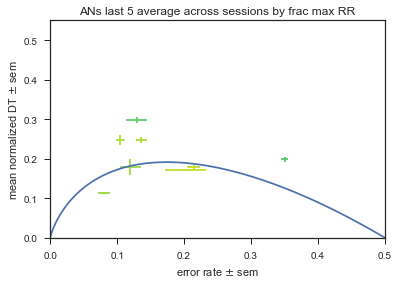

In [773]:
opc_avg_colored_by_frac_max_rr(can_perf_last5_avg, can_perf_last5_sem, can_dt_last5_avg, can_dt_last5_sem, can_pct_max_rr_last5_avg, 'ANs last 5 ', '_graphs_opc_during_learning/ANs_opc_frac_max_rr_vol_iti_bound_500ms_last5_test.pdf')

In [776]:
stats.norm.cdf(1.96)

0.97500210485177952

In [777]:
stats.norm.sf(1.96)

0.024997895148220435

In [782]:
stats.norm.isf(0.02499)

1.9601351140675658

In [ ]:
fig, ax = plt.subplots(1,1)
mean, var, skew, kurt = stats.expon.stats(moments='mvsk')
x = np.linspace(stats.expon.ppf(0.01), stats.expon.ppf(0.99), 100)
ax.plot(x, stats.expon.pdf(x), 'r-', lw=5, alpha = 0.6, label = 'expon pdf')

rv = stats.expon()

(array([ 1.36104696,  1.30143907,  1.34117766,  0.98353029,  0.64575221,
         0.69542545,  0.57620966,  0.41725527,  0.44705922,  0.27817018,
         0.19869299,  0.25830088,  0.11921579,  0.16888904,  0.20862764,
         0.11921579,  0.17882369,  0.10928114,  0.06954255,  0.0596079 ,
         0.04967325,  0.0596079 ,  0.0397386 ,  0.0198693 ,  0.0198693 ,
         0.02980395,  0.02980395,  0.0397386 ,  0.0198693 ,  0.        ,
         0.        ,  0.0198693 ,  0.00993465,  0.00993465,  0.        ,
         0.00993465,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00993465,  0.00993465,  0.00993465,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00993465]),
 array([  2.02143058e-04,   1.00859948e-01,   2.01517754e-01,
          3.02175559e-01,   4.02833364e-01,   5.03491169e-01,
          6.04148974e-01,   7.04806780e-01,   8.05464585e-01,
          9.06122390e-01,   1.00678020e+00,   1.10743800e+00,
          1.20809581

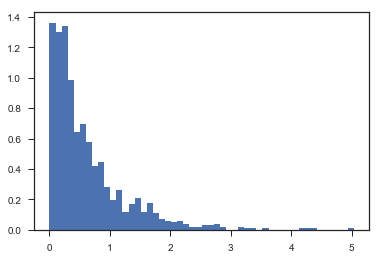

In [793]:
r = stats.expon.rvs(loc=0, scale=0.6, size=1000)
plt.hist(r, normed = True, bins = 50)

In [823]:
stats.expon.pdf(0, 0, 1)

1.0

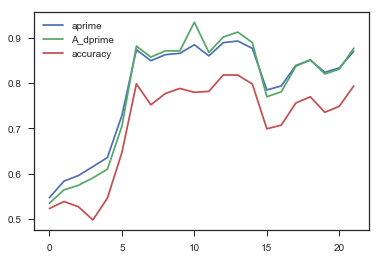

In [881]:
hrfa_by_animal = {}
for animal in results_AK_AL_hrfa.keys():
    d = results_AK_AL_hrfa[animal]['hitrate_falsealarms_by_session']
    hitrate = []
    falsealarm = []
    aprime = []
    dprime = []
    for session in sorted(d.keys()):
        hr = d[session][0]['hit_rate_signal_stim']
        fa = d[session][0]['falsealarm_rate_noise_stim']
        hitrate.append(hr)
        falsealarm.append(fa)
        
        if hr == 0:
            hr = 0.0001
        if fa == 0:
            fa = 0.0001
        
        if hr >= fa:
            a_p = 0.5 + ((hr - fa)*(1 + hr - fa))/(4*hr*(1-fa))
        else: 
            a_p = 0.5 + ((fa - hr)*(1 + fa - hr))/(4*fa*(1-hr))
            
        d_p = stats.norm.isf(1-hr) - stats.norm.isf(1-fa)
        
        aprime.append(a_p)
        dprime.append(d_p)
        
        
        
    hrfa_by_animal[animal] = {'hr':hr, 'fa': fa, 'aprime': aprime, 'dprime': dprime}


plt.close()
plt.plot(hrfa_by_animal['AK12']['aprime'], label = 'aprime')
# plt.plot(hrfa_by_animal['AK12']['dprime'], label = 'dprime')
plt.plot([stats.norm.cdf(i/math.sqrt(2)) for i in hrfa_by_animal['AK12']['dprime']], label = 'A_dprime')
plt.plot(reg_perf['AK12'], label = 'accuracy')
plt.legend()

In [858]:
results_AK_AL_hrfa['AK1']['hitrate_falsealarms_by_session']

{'AK1_170531.mwk': {0: {'falsealarm_rate_noise_stim': 0.4883720930232558,
   'falsealarms_noise_stim': 231,
   'hit_rate_signal_stim': 0.4875444839857651,
   'hits_signal_stim': 137,
   'total_noise_stim': 473,
   'total_signal_stim': 281},
  1: {'falsealarm_rate_noise_stim': 0.5124555160142349,
   'falsealarms_noise_stim': 144,
   'hit_rate_signal_stim': 0.5116279069767442,
   'hits_signal_stim': 242,
   'total_noise_stim': 281,
   'total_signal_stim': 473}},
 'AK1_170606.mwk': {0: {'falsealarm_rate_noise_stim': 0.42105263157894735,
   'falsealarms_noise_stim': 72,
   'hit_rate_signal_stim': 0.4258064516129032,
   'hits_signal_stim': 66,
   'total_noise_stim': 171,
   'total_signal_stim': 155},
  1: {'falsealarm_rate_noise_stim': 0.5741935483870968,
   'falsealarms_noise_stim': 89,
   'hit_rate_signal_stim': 0.5789473684210527,
   'hits_signal_stim': 99,
   'total_noise_stim': 155,
   'total_signal_stim': 171}},
 'AK1_170607.mwk': {0: {'falsealarm_rate_noise_stim': 0.3275862068965517,

In [842]:
len([i for i in results_AK_AL_hrfa['AK4']['beh_outcome_by_session']['AK4_170527.mwk'] if i == 'success'])

60

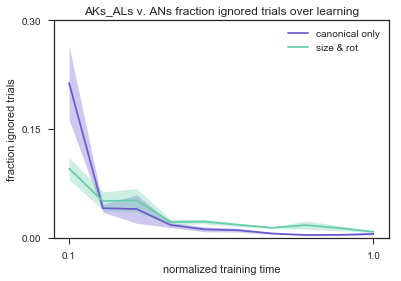

In [435]:
x = np.array(range(len(binned_avg_can_pct_ignore['y_bins_mean'])))
y = np.array(binned_avg_can_pct_ignore['y_bins_mean'])
yerr = np.array(binned_avg_can_pct_ignore['y_bins_sem'])

plt.close()
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'slateblue', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'slateblue', label = 'canonical only')

x = np.array(range(len(binned_avg_reg_pct_ignore['y_bins_mean'])))
y = np.array(binned_avg_reg_pct_ignore['y_bins_mean'])
yerr = np.array(binned_avg_reg_pct_ignore['y_bins_sem'])

plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'mediumaquamarine', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'mediumaquamarine', label = 'size & rot')

plt.xlabel('normalized training time')
plt.ylabel('fraction ignored trials')
plt.ylim(0, 0.3)
plt.xticks([0, 9], [0.1, 1.0])
plt.yticks([0, 0.15, 0.3])
plt.legend()
plt.title('AKs_ALs v. ANs fraction ignored trials over learning')
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_fractiontrialsignored_over_learning.pdf')

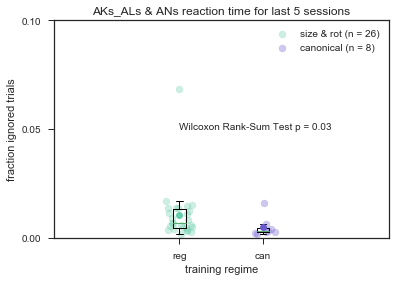

In [450]:
#plot mean of session means of reaction time by training regime

can_pct_ignore_last5_avg = []
can_pct_ignore_last5_sem = []
for animal in can_ignore_pct_ignore.keys():
    can_pct_ignore_last5_avg.append(np.mean(can_ignore_pct_ignore[animal][-5:]))
    can_pct_ignore_last5_sem.append(stats.sem(can_ignore_pct_ignore[animal][-5:]))
    
reg_pct_ignore_last5_avg = []
reg_pct_ignore_last5_sem = []
for animal in reg_pct_ignore.keys():
    reg_pct_ignore_last5_avg.append(np.mean(reg_pct_ignore[animal][-5:]))
    reg_pct_ignore_last5_sem.append(stats.sem(reg_pct_ignore[animal][-5:]))


alpha = 0.33

x1 = [1.5]
y1 = [np.mean(reg_pct_ignore_last5_avg)]
yerr1 = [stats.sem(can_pct_ignore_last5_sem)]
label1 = 'size & rot (n = 26)'

x2 = [4.5]
y2 = [np.mean(can_pct_ignore_last5_avg)]
yerr2 = [stats.sem(can_pct_ignore_last5_sem)]
label2 = 'canonical (n = 8)' 

plt.boxplot((reg_pct_ignore_last5_avg, can_pct_ignore_last5_avg), positions = (1.5, 4.5))

plt.scatter(np.random.rand(1,len(reg_pct_ignore_last5_avg))+1, reg_pct_ignore_last5_avg, marker = 'o', color = 'mediumaquamarine', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,len(can_pct_ignore_last5_avg))+4, can_pct_ignore_last5_avg, marker = 'o', color = 'slateblue', alpha = alpha, label = label2)

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'mediumaquamarine')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'slateblue')

plt.legend()
plt.xlim(-3,9)
plt.ylim(0,0.1)
plt.xticks([1.5, 4.5], ['reg', 'can'])
plt.yticks([0, 0.05, 0.1])
s = 'Wilcoxon Rank-Sum Test p = %.2f' %scipy.stats.ranksums(reg_rt_last5_avg, can_rt_last5_avg)[1]
plt.text(1.5, 0.05, s)
plt.xlabel('training regime')
plt.ylabel('fraction ignored trials')
plt.title('AKs_ALs & ANs reaction time for last 5 sessions')
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_fractiontrialsignored_last5_sessions.pdf')

In [445]:
reg_rt_last5_avg

[0.0068853375586408281,
 0.014897266922793386,
 0.014594020281637182,
 0.0033412460573946589,
 0.0015650094481973308,
 0.0026009857966695971,
 0.0049212678879266402,
 0.0067929382495635401,
 0.016729762247259007,
 0.0092905512326550196,
 0.011425687536340089,
 0.0037782864782778336,
 0.010811679377951331,
 0.013537636207895345,
 0.012281084830536313,
 0.005162354914863455,
 0.0079757490929771892,
 0.0057116332713153068,
 0.0044107400754990504,
 0.013698296862957943,
 0.0054103867038270206,
 0.013761925771787092,
 0.0037992645578110744,
 0.0031266592249397673,
 0.0056776508650987524,
 0.068197200037780376]

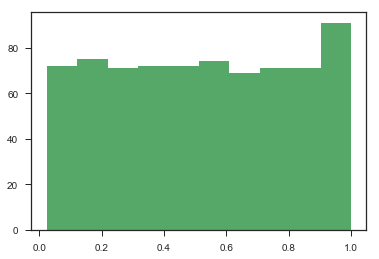

In [660]:
can_totaltrials = {}
can_succtrials = {}
can_failtrials = {}
for animal in can_all_rts:
    can_totaltrials[animal] = [len(i) for i in can_all_rts[animal]]
    can_succtrials[animal] = [len(i) for i in can_succ_rts[animal]]
    can_failtrials[animal] = [len(i) for i in can_fail_rts[animal]]
    
reg_totaltrials = {}
reg_succtrials = {}
reg_failtrials = {}
for animal in reg_all_rts:
    reg_totaltrials[animal] = [len(i) for i in reg_all_rts[animal]]
    reg_succtrials[animal] = [len(i) for i in reg_succ_rts[animal]]
    reg_failtrials[animal] = [len(i) for i in reg_fail_rts[animal]]
    
n_bins = 10
meshed_can_totaltrials = mesh_data(can_totaltrials, 'none')
binned_avg_can_totaltrials = avg_binned_data(meshed_can_totaltrials, n_bins)

meshed_reg_totaltrials = mesh_data(reg_totaltrials, 'none')
binned_avg_reg_totaltrials = avg_binned_data(meshed_reg_totaltrials, n_bins)

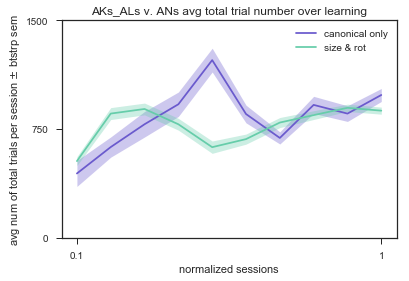

In [672]:
x = np.array(range(len(binned_avg_can_totaltrials['y_bins_mean'])))
y = np.array(binned_avg_can_totaltrials['y_bins_mean'])
yerr = np.array(binned_avg_can_totaltrials['y_bins_sem'])

plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'slateblue', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'slateblue', label = 'canonical only')

x = np.array(range(len(binned_avg_reg_totaltrials['y_bins_mean'])))
y = np.array(binned_avg_reg_totaltrials['y_bins_mean'])
yerr = np.array(binned_avg_reg_totaltrials['y_bins_sem'])

plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'mediumaquamarine', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'mediumaquamarine', label = 'size & rot')
# plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
# plt.errorbar(x = x, y = y, color = 'k', label = 'size & rot')

plt.xlabel('normalized sessions')
plt.ylabel('avg num of total trials per session $\pm$ btstrp sem')
plt.ylim(0,1500)
plt.xticks([0, 9], [0.1, 1])
plt.yticks([0, 750, 1500])
plt.legend()
plt.title('AKs_ALs v. ANs avg total trial number over learning')
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_totaltrialnum_over_learning.pdf')

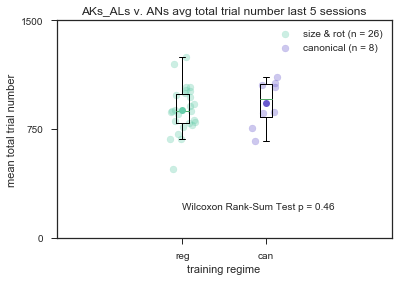

In [674]:
#plot mean of session means of reaction time by training regime

can_totaltrials_last5_avg = []
can_totaltrials_last5_sem = []
for animal in can_totaltrials.keys():
    can_totaltrials_last5_avg.append(np.mean(can_totaltrials[animal][-5:]))
    can_totaltrials_last5_sem.append(stats.sem(can_totaltrials[animal][-5:]))
    
reg_totaltrials_last5_avg = []
reg_totaltrials_last5_sem = []
for animal in reg_totaltrials.keys():
    reg_totaltrials_last5_avg.append(np.mean(reg_totaltrials[animal][-5:]))
    reg_totaltrials_last5_sem.append(stats.sem(reg_totaltrials[animal][-5:]))


alpha = 0.33

x1 = [1.5]
y1 = [np.mean(reg_totaltrials_last5_avg)]
yerr1 = [stats.sem(can_totaltrials_last5_sem)]
label1 = 'size & rot (n = 26)'

x2 = [4.5]
y2 = [np.mean(can_totaltrials_last5_avg)]
yerr2 = [stats.sem(can_totaltrials_last5_sem)]
label2 = 'canonical (n = 8)' 

plt.boxplot((reg_totaltrials_last5_avg, can_totaltrials_last5_avg), positions = (1.5, 4.5))

plt.scatter(np.random.rand(1,len(reg_totaltrials_last5_avg))+1, reg_totaltrials_last5_avg, marker = 'o', color = 'mediumaquamarine', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,len(can_totaltrials_last5_avg))+4, can_totaltrials_last5_avg, marker = 'o', color = 'slateblue', alpha = alpha, label = label2)

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'mediumaquamarine')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'slateblue')

plt.legend()
plt.xlim(-3,9)
plt.ylim(0,1500)
# plt.xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5], ['prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.'])
plt.xticks([1.5, 4.5], ['reg', 'can'])
plt.yticks([0, 750, 1500])
s = 'Wilcoxon Rank-Sum Test p = %.2f' %scipy.stats.ranksums(reg_totaltrials_last5_avg, can_totaltrials_last5_avg)[1]
plt.text(1.5, 200, s)
plt.xlabel('training regime')
plt.ylabel('mean total trial number')
plt.title('AKs_ALs v. ANs avg total trial number last 5 sessions')
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_totaltrialnum_last5_sessions.pdf')

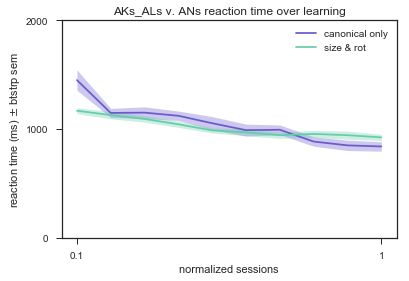

In [647]:
x = np.array(range(len(binned_avg_can_rt['y_bins_mean'])))
y = np.array(binned_avg_can_rt['y_bins_mean'])
yerr = np.array(binned_avg_can_rt['y_bins_sem'])

plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'slateblue', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'slateblue', label = 'canonical only')

x = np.array(range(len(binned_avg_reg_rt['y_bins_mean'])))
y = np.array(binned_avg_reg_rt['y_bins_mean'])
yerr = np.array(binned_avg_reg_rt['y_bins_sem'])

plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'mediumaquamarine', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'mediumaquamarine', label = 'size & rot')
# plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.5, linewidth = 0)
# plt.errorbar(x = x, y = y, color = 'k', label = 'size & rot')

plt.xlabel('normalized sessions')
plt.ylabel('reaction time (ms) $\pm$ btstrp sem')
plt.ylim(0,2000)
plt.xticks([0, 9], [0.1, 1])
plt.yticks([0, 1000, 2000])
plt.title('AKs_ALs v. ANs reaction time over learning')
plt.legend()
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_rt_over_learning.pdf')

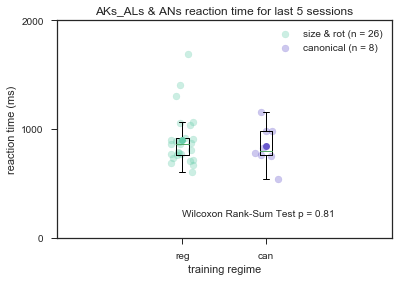

In [643]:
#plot mean of session means of reaction time by training regime

can_rt_last5_avg = []
can_rt_last5_sem = []
for animal in can_rt_succ.keys():
    can_rt_last5_avg.append(np.mean(can_rt_succ[animal][-5:]))
    can_rt_last5_sem.append(stats.sem(can_rt_succ[animal][-5:]))
    
reg_rt_last5_avg = []
reg_rt_last5_sem = []
for animal in reg_rt_succ.keys():
    reg_rt_last5_avg.append(np.mean(reg_rt_succ[animal][-5:]))
    reg_rt_last5_sem.append(stats.sem(reg_rt_succ[animal][-5:]))


alpha = 0.33

x1 = [1.5]
y1 = [np.mean(reg_rt_last5_avg)]
yerr1 = [stats.sem(can_rt_last5_sem)]
label1 = 'size & rot (n = 26)'

x2 = [4.5]
y2 = [np.mean(can_rt_last5_avg)]
yerr2 = [stats.sem(can_rt_last5_sem)]
label2 = 'canonical (n = 8)' 

plt.boxplot((reg_rt_last5_avg, can_rt_last5_avg), positions = (1.5, 4.5))

plt.scatter(np.random.rand(1,len(reg_rt_last5_avg))+1, reg_rt_last5_avg, marker = 'o', color = 'mediumaquamarine', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,len(can_rt_last5_avg))+4, can_rt_last5_avg, marker = 'o', color = 'slateblue', alpha = alpha, label = label2)

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'mediumaquamarine')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'slateblue')

plt.legend()
plt.xlim(-3,9)
plt.ylim(0,2000)
# plt.xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5], ['prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.'])
plt.xticks([1.5, 4.5], ['reg', 'can'])
plt.yticks([0, 1000, 2000])
s = 'Wilcoxon Rank-Sum Test p = %.2f' %scipy.stats.ranksums(reg_rt_last5_avg, can_rt_last5_avg)[1]
plt.text(1.5, 200, s)
plt.xlabel('training regime')
plt.ylabel('reaction time (ms)')
plt.title('AKs_ALs & ANs reaction time for last 5 sessions')
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_rt_last5_sessions.pdf')

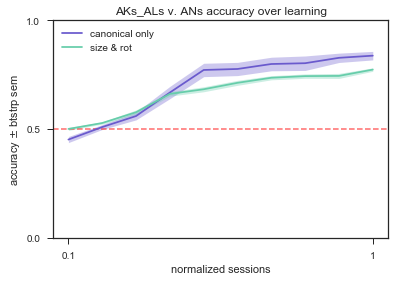

In [599]:
x = np.array(range(len(binned_avg_can_perf['y_bins_mean'])))
y = np.array(binned_avg_can_perf['y_bins_mean'])
yerr = np.array(binned_avg_can_perf['y_bins_sem'])

plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'slateblue', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'slateblue', label = 'canonical only')

x = np.array(range(len(binned_avg_reg_perf['y_bins_mean'])))
y = np.array(binned_avg_reg_perf['y_bins_mean'])
yerr = np.array(binned_avg_reg_perf['y_bins_sem'])

plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'mediumaquamarine', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'mediumaquamarine', label = 'size & rot')

plt.xlabel('normalized sessions')
plt.ylabel('accuracy $\pm$ btstrp sem')
plt.axhline(0.5, color = 'red', alpha = 0.5, linestyle = '--')
plt.ylim(0, 1.0)
plt.xticks([0, 9], [0.1, 1])
plt.yticks([0, 0.5, 1])
plt.title('AKs_ALs v. ANs accuracy over learning')
plt.legend()
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_accuracy_over_learning.pdf')

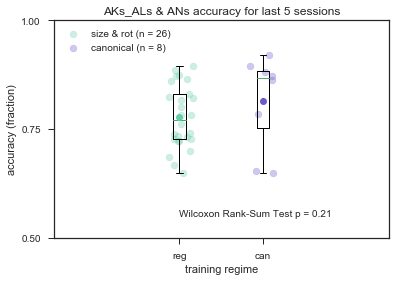

In [604]:
#plot mean of session means of accuracy by training regime

can_perf_last5_avg = []
can_perf_last5_sem = []
for animal in can_perf.keys():
    can_perf_last5_avg.append(np.mean(can_perf[animal][-5:]))
    can_perf_last5_sem.append(stats.sem(can_perf[animal][-5:]))
    
reg_perf_last5_avg = []
reg_perf_last5_sem = []
for animal in reg_perf.keys():
    reg_perf_last5_avg.append(np.mean(reg_perf[animal][-5:]))
    reg_perf_last5_sem.append(stats.sem(reg_perf[animal][-5:]))


alpha = 0.33

x1 = [1.5]
y1 = [np.mean(reg_perf_last5_avg)]
yerr1 = [stats.sem(can_perf_last5_sem)]
label1 = 'size & rot (n = 26)'

x2 = [4.5]
y2 = [np.mean(can_perf_last5_avg)]
yerr2 = [stats.sem(can_perf_last5_sem)]
label2 = 'canonical (n = 8)' 

plt.boxplot((reg_perf_last5_avg, can_perf_last5_avg), positions = (1.5, 4.5))

plt.scatter(np.random.rand(1,len(reg_perf_last5_avg))+1, reg_perf_last5_avg, marker = 'o', color = 'mediumaquamarine', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,len(can_perf_last5_avg))+4, can_perf_last5_avg, marker = 'o', color = 'slateblue', alpha = alpha, label = label2)

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'mediumaquamarine')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'slateblue')

plt.legend()
plt.xlim(-3,9)
plt.ylim(0.5,1)
# plt.xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5], ['prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.'])
plt.xticks([1.5, 4.5], ['reg', 'can'])
plt.yticks([0.5, 0.75, 1])
s = 'Wilcoxon Rank-Sum Test p = %.2f' %scipy.stats.ranksums(reg_perf_last5_avg, can_perf_last5_avg)[1]
plt.text(1.5, 0.55, s)
plt.xlabel('training regime')
plt.ylabel('accuracy (fraction)')
plt.title('AKs_ALs & ANs accuracy for last 5 sessions')
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_accuracy_last5_sessions.pdf')

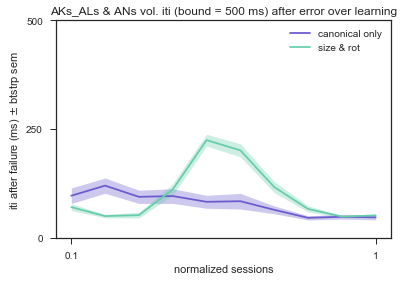

In [677]:
# boundary = 500

x = np.array(range(len(binned_avg_can_iti_err_median_500['y_bins_mean'])))
y = np.array(binned_avg_can_iti_err_median_500['y_bins_mean'])
yerr = np.array(binned_avg_can_iti_err_median_500['y_bins_sem'])

plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'slateblue', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'slateblue', label = 'canonical only', alpha = 1)

x = np.array(range(len(binned_avg_reg_iti_err_median_500['y_bins_mean'])))
y = np.array(binned_avg_reg_iti_err_median_500['y_bins_mean'])
yerr = np.array(binned_avg_reg_iti_err_median_500['y_bins_sem'])

plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'mediumaquamarine', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'mediumaquamarine', label = 'size & rot', alpha = 1)

# boundary = 1000

# x = np.array(range(len(binned_avg_can_iti_err_median_1000['y_bins_mean'])))
# y = np.array(binned_avg_can_iti_err_median_1000['y_bins_mean'])
# yerr = np.array(binned_avg_can_iti_err_median_1000['y_bins_sem'])

# plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'slateblue', alpha = 0.15, linewidth = 0)
# plt.errorbar(x = x, y = y, color = 'slateblue', label = 'canonical only', alpha = 0.66)

# x = np.array(range(len(binned_avg_reg_iti_err_median_1000['y_bins_mean'])))
# y = np.array(binned_avg_reg_iti_err_median_1000['y_bins_mean'])
# yerr = np.array(binned_avg_reg_iti_err_median_1000['y_bins_sem'])

# plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'mediumaquamarine', alpha = 0.15, linewidth = 0)
# plt.errorbar(x = x, y = y, color = 'mediumaquamarine', label = 'size & rot', alpha = 0.66)

# boundary = 2000

# x = np.array(range(len(binned_avg_can_iti_err_median_2000['y_bins_mean'])))
# y = np.array(binned_avg_can_iti_err_median_2000['y_bins_mean'])
# yerr = np.array(binned_avg_can_iti_err_median_2000['y_bins_sem'])

# plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'slateblue', alpha = 0.03, linewidth = 0)
# plt.errorbar(x = x, y = y, color = 'slateblue', label = 'canonical only', alpha = 0.33)

# x = np.array(range(len(binned_avg_reg_iti_err_median_2000['y_bins_mean'])))
# y = np.array(binned_avg_reg_iti_err_median_2000['y_bins_mean'])
# yerr = np.array(binned_avg_reg_iti_err_median_2000['y_bins_sem'])

# plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'mediumaquamarine', alpha = 0.03, linewidth = 0)
# plt.errorbar(x = x, y = y, color = 'mediumaquamarine', label = 'size & rot', alpha = 0.33)

plt.xlabel('normalized sessions')
plt.ylabel('iti after failure (ms) $\pm$ btstrp sem')
plt.ylim(0, 500)
plt.yticks([0, 250, 500])
plt.xticks([0, 9], [0.1, 1])
plt.legend()
plt.title('AKs_ALs & ANs vol. iti (bound = 500 ms) after error over learning')
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_vol_iti_bound_500ms_over_learning.pdf')

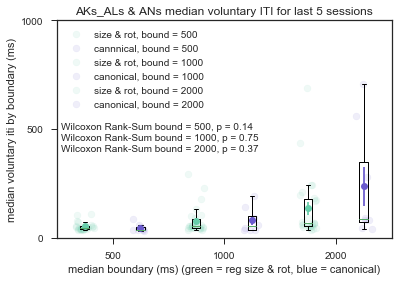

In [569]:
#plot mean & median of session means but by previous trial type not by animal

alpha = 0.1

can_iti_last5_avg_500 = []; can_iti_last5_sem_500 = []
can_iti_last5_avg_1000 = []; can_iti_last5_sem_1000 = []
can_iti_last5_avg_2000 = []; can_iti_last5_sem_2000 = []
for animal in can_iti_fail_adj_median_500.keys():
    can_iti_last5_avg_500.append(np.mean(can_iti_fail_adj_median_500[animal][-5:]))
    can_iti_last5_sem_500.append(stats.sem(can_iti_fail_adj_median_500[animal][-5:]))
    can_iti_last5_avg_1000.append(np.mean(can_iti_fail_adj_median_1000[animal][-5:]))
    can_iti_last5_sem_1000.append(stats.sem(can_iti_fail_adj_median_1000[animal][-5:]))
    can_iti_last5_avg_2000.append(np.mean(can_iti_fail_adj_median_2000[animal][-5:]))
    can_iti_last5_sem_2000.append(stats.sem(can_iti_fail_adj_median_2000[animal][-5:]))
    
reg_iti_last5_avg_500 = []; reg_iti_last5_sem_500 = []
reg_iti_last5_avg_1000 = []; reg_iti_last5_sem_1000 = []
reg_iti_last5_avg_2000 = []; reg_iti_last5_sem_2000 = []
for animal in reg_iti_fail_adj_median_500.keys():
    reg_iti_last5_avg_500.append(np.mean(reg_iti_fail_adj_median_500[animal][-5:]))
    reg_iti_last5_sem_500.append(stats.sem(reg_iti_fail_adj_median_500[animal][-5:]))
    reg_iti_last5_avg_1000.append(np.mean(reg_iti_fail_adj_median_1000[animal][-5:]))
    reg_iti_last5_sem_1000.append(stats.sem(reg_iti_fail_adj_median_1000[animal][-5:]))
    reg_iti_last5_avg_2000.append(np.mean(reg_iti_fail_adj_median_2000[animal][-5:]))
    reg_iti_last5_sem_2000.append(stats.sem(reg_iti_fail_adj_median_2000[animal][-5:]))

x1 = [1.5]
y1 = [np.mean(reg_iti_last5_avg_500)]
yerr1 = [stats.sem(reg_iti_last5_avg_500)]
label1 = 'size & rot, bound = 500'

x2 = [4.5]
y2 = [np.mean(can_iti_last5_avg_500)]
yerr2 = [stats.sem(can_iti_last5_avg_500)]
label2 = 'cannnical, bound = 500'

x3 = [7.5]
y3 = [np.mean(reg_iti_last5_avg_1000)]
yerr3 = [stats.sem(reg_iti_last5_avg_1000)]
label3 = 'size & rot, bound = 1000'

x4 = [10.5]
y4 = [np.mean(can_iti_last5_avg_1000)]
yerr4 = [stats.sem(can_iti_last5_avg_1000)]
label4 = 'canonical, bound = 1000'

x5 = [13.5]
y5 = [np.mean(reg_iti_last5_avg_2000)]
yerr5 = [stats.sem(reg_iti_last5_avg_2000)]
label5 = 'size & rot, bound = 2000'

x6 = [16.5]
y6 = [np.mean(can_iti_last5_avg_2000)]
yerr6 = [stats.sem(can_iti_last5_avg_2000)]
label6 = 'canonical, bound = 2000'

plt.scatter(np.random.rand(1,26)+1, reg_iti_last5_avg_500, marker = 'o', color = 'mediumaquamarine', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,8)+4, can_iti_last5_avg_500, marker = 'o', color = 'slateblue', alpha = alpha, label = label2)
plt.scatter(np.random.rand(1,26)+7, reg_iti_last5_avg_1000, marker = 'o',  color = 'mediumaquamarine', alpha = alpha, label = label3)
plt.scatter(np.random.rand(1,8)+10, can_iti_last5_avg_1000, marker = 'o', color = 'slateblue', alpha = alpha, label = label4)
plt.scatter(np.random.rand(1,26)+13, reg_iti_last5_avg_2000, marker = 'o',  color = 'mediumaquamarine', alpha = alpha, label = label5)
plt.scatter(np.random.rand(1,8)+16, can_iti_last5_avg_2000, marker = 'o', color = 'slateblue', alpha = alpha, label = label6)

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'mediumaquamarine')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'slateblue')
plt.errorbar(x = x3, y = y3, yerr = yerr3, marker = 'o', color = 'mediumaquamarine')
plt.errorbar(x = x4, y = y4, yerr = yerr4, marker = 'o', color = 'slateblue')
plt.errorbar(x = x5, y = y5, yerr = yerr5, marker = 'o', color = 'mediumaquamarine')
plt.errorbar(x = x6, y = y6, yerr = yerr6, marker = 'o', color = 'slateblue')

plt.boxplot((reg_iti_last5_avg_500, can_iti_last5_avg_500), positions = (1.5, 4.5))
plt.boxplot((reg_iti_last5_avg_1000, can_iti_last5_avg_1000), positions = (7.5, 10.5))
plt.boxplot((reg_iti_last5_avg_2000, can_iti_last5_avg_2000), positions = (13.5, 16.5))


plt.legend()

s = 'Wilcoxon Rank-Sum bound = 500, p = %.2f' %scipy.stats.ranksums(reg_iti_last5_avg_500, can_iti_last5_avg_500)[1]
plt.text(0.25, 500, s)
s = 'Wilcoxon Rank-Sum bound = 1000, p = %.2f' %scipy.stats.ranksums(reg_iti_last5_avg_1000, can_iti_last5_avg_1000)[1]
plt.text(0.25, 450, s)
s = 'Wilcoxon Rank-Sum bound = 2000, p = %.2f' %scipy.stats.ranksums(reg_iti_last5_avg_2000, can_iti_last5_avg_2000)[1]
plt.text(0.25, 400, s)

plt.xlim(0,18)
plt.ylim(0,1000)
plt.xticks([3, 9, 15], [500, 1000, 2000])
plt.yticks([0, 500, 1000])
plt.xlabel('median boundary (ms) (green = reg size & rot, blue = canonical)')
plt.ylabel('median voluntary iti by boundary (ms)')
plt.title('AKs_ALs & ANs median voluntary ITI for last 5 sessions')
# #plt.savefig('AKs_ALs_last10_median_itis_corr_err_boundary_500_1000_2000_neat.pdf')

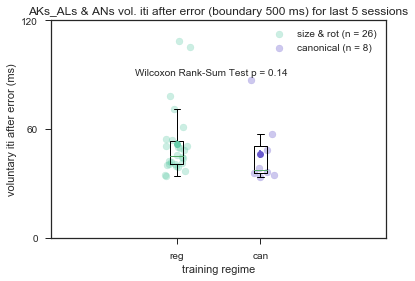

In [623]:
#plot mean of session means of accuracy by training regime

can_iti_last5_avg = []
can_iti_last5_sem = []
for animal in can_iti_fail_adj_median_500.keys():
    can_iti_last5_avg.append(np.mean(can_iti_fail_adj_median_500[animal][-5:]))
    can_iti_last5_sem.append(stats.sem(can_iti_fail_adj_median_500[animal][-5:]))
    
reg_iti_last5_avg = []
reg_iti_last5_sem = []
for animal in reg_iti_fail_adj_median_500.keys():
    reg_iti_last5_avg.append(np.mean(reg_iti_fail_adj_median_500[animal][-5:]))
    reg_iti_last5_sem.append(stats.sem(reg_iti_fail_adj_median_500[animal][-5:]))

alpha = 0.33

x1 = [1.5]
y1 = [np.mean(reg_iti_last5_avg)]
yerr1 = [stats.sem(can_iti_last5_sem)]
label1 = 'size & rot (n = 26)'

x2 = [4.5]
y2 = [np.mean(can_iti_last5_avg)]
yerr2 = [stats.sem(can_iti_last5_sem)]
label2 = 'canonical (n = 8)' 

plt.boxplot((reg_iti_last5_avg, can_iti_last5_avg), positions = (1.5, 4.5))

plt.scatter(np.random.rand(1,len(reg_iti_last5_avg))+1, reg_iti_last5_avg, marker = 'o', color = 'mediumaquamarine', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,len(can_iti_last5_avg))+4, can_iti_last5_avg, marker = 'o', color = 'slateblue', alpha = alpha, label = label2)

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'mediumaquamarine')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'slateblue')

plt.legend()
plt.xlim(-3,9)
plt.ylim(0, 120)
# plt.xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5], ['prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.'])
plt.xticks([1.5, 4.5], ['reg', 'can'])
plt.yticks([0, 60, 120])
s = 'Wilcoxon Rank-Sum Test p = %.2f' %scipy.stats.ranksums(reg_iti_last5_avg, can_iti_last5_avg)[1]
plt.text(0, 90, s)
plt.xlabel('training regime')
plt.ylabel('voluntary iti after error (ms)')
plt.title('AKs_ALs & ANs vol. iti after error (boundary 500 ms) for last 5 sessions')
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_vol_iti_bound_500ms_last5_sessions.pdf')

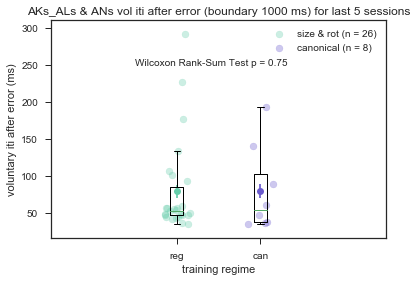

In [622]:
#plot mean of session means of accuracy by training regime

can_iti_last5_avg = []
can_iti_last5_sem = []
for animal in can_iti_fail_adj_median_1000.keys():
    can_iti_last5_avg.append(np.mean(can_iti_fail_adj_median_1000[animal][-5:]))
    can_iti_last5_sem.append(stats.sem(can_iti_fail_adj_median_1000[animal][-5:]))
    
reg_iti_last5_avg = []
reg_iti_last5_sem = []
for animal in reg_iti_fail_adj_median_1000.keys():
    reg_iti_last5_avg.append(np.mean(reg_iti_fail_adj_median_1000[animal][-5:]))
    reg_iti_last5_sem.append(stats.sem(reg_iti_fail_adj_median_1000[animal][-5:]))


alpha = 0.33

x1 = [1.5]
y1 = [np.mean(reg_iti_last5_avg)]
yerr1 = [stats.sem(can_iti_last5_sem)]
label1 = 'size & rot (n = 26)'

x2 = [4.5]
y2 = [np.mean(can_iti_last5_avg)]
yerr2 = [stats.sem(can_iti_last5_sem)]
label2 = 'canonical (n = 8)' 

plt.boxplot((reg_iti_last5_avg, can_iti_last5_avg), positions = (1.5, 4.5))

plt.scatter(np.random.rand(1,len(reg_iti_last5_avg))+1, reg_iti_last5_avg, marker = 'o', color = 'mediumaquamarine', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,len(can_iti_last5_avg))+4, can_iti_last5_avg, marker = 'o', color = 'slateblue', alpha = alpha, label = label2)

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'mediumaquamarine')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'slateblue')

plt.legend()
plt.xlim(-3,9)
# plt.ylim(0.5,1)
# plt.xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5], ['prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.'])
plt.xticks([1.5, 4.5], ['reg', 'can'])
# plt.yticks([0, 500, 1000])
s = 'Wilcoxon Rank-Sum Test p = %.2f' %scipy.stats.ranksums(reg_iti_last5_avg, can_iti_last5_avg)[1]
plt.text(0, 250, s)
plt.xlabel('training regime')
plt.ylabel('voluntary iti after error (ms)')
plt.title('AKs_ALs & ANs vol iti after error (boundary 1000 ms) for last 5 sessions')
# #plt.savefig('AKs_ALs_last10_median_itis_corr_err_boundary_500_1000_2000_neat.pdf')

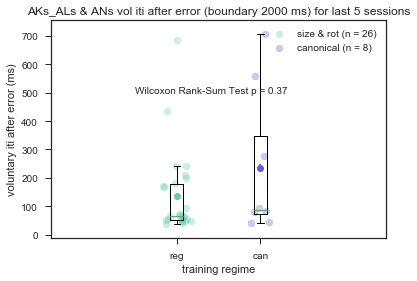

In [559]:
#plot mean of session means of accuracy by training regime

can_iti_last5_avg = []
can_iti_last5_sem = []
for animal in can_iti_fail_adj_median_2000.keys():
    can_iti_last5_avg.append(np.mean(can_iti_fail_adj_median_2000[animal][-5:]))
    can_iti_last5_sem.append(stats.sem(can_iti_fail_adj_median_2000[animal][-5:]))
    
reg_iti_last5_avg = []
reg_iti_last5_sem = []
for animal in reg_iti_fail_adj_median_2000.keys():
    reg_iti_last5_avg.append(np.mean(reg_iti_fail_adj_median_2000[animal][-5:]))
    reg_iti_last5_sem.append(stats.sem(reg_iti_fail_adj_median_2000[animal][-5:]))


alpha = 0.33

x1 = [1.5]
y1 = [np.mean(reg_iti_last5_avg)]
yerr1 = [stats.sem(can_iti_last5_sem)]
label1 = 'size & rot (n = 26)'

x2 = [4.5]
y2 = [np.mean(can_iti_last5_avg)]
yerr2 = [stats.sem(can_iti_last5_sem)]
label2 = 'canonical (n = 8)' 

plt.boxplot((reg_iti_last5_avg, can_iti_last5_avg), positions = (1.5, 4.5))

plt.scatter(np.random.rand(1,len(reg_iti_last5_avg))+1, reg_iti_last5_avg, marker = 'o', color = 'mediumaquamarine', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,len(can_iti_last5_avg))+4, can_iti_last5_avg, marker = 'o', color = 'slateblue', alpha = alpha, label = label2)

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'mediumaquamarine')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'slateblue')

plt.legend()
plt.xlim(-3,9)
# plt.ylim(0.5,1)
# plt.xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5], ['prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.'])
plt.xticks([1.5, 4.5], ['reg', 'can'])
# plt.yticks([0, 500, 1000])
s = 'Wilcoxon Rank-Sum Test p = %.2f' %scipy.stats.ranksums(reg_iti_last5_avg, can_iti_last5_avg)[1]
plt.text(0, 500, s)
plt.xlabel('training regime')
plt.ylabel('voluntary iti after error (ms)')
plt.title('AKs_ALs & ANs vol iti after error (boundary 2000 ms) for last 5 sessions')
# #plt.savefig('AKs_ALs_last10_median_itis_corr_err_boundary_500_1000_2000_neat.pdf')

In [571]:
T0 = 350*0.001 # convert to seconds
Dcorr = 6370*0.001 # convert to seconds
Derr = 3136*0.001 # convert to seconds
with_itis = False
pct_max_rr_data = 'fraction_max_rr' # 'opportunity_cost'  

perf_dict = reg_perf
rt_dict = reg_rt_succ
corr_iti_dict = reg_iti_succ_adj_mean
err_iti_dict = reg_iti_fail_adj_mean

reg_pct_max_rr = {}
for animal in perf_dict.keys():
    for session in range(len(perf_dict[animal])):
        try:
            reg_pct_max_rr[animal].append(percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data])
        except KeyError:
            reg_pct_max_rr[animal] = [percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data]]


perf_dict = can_perf
rt_dict = can_rt_succ
corr_iti_dict = can_iti_succ_adj_mean
err_iti_dict = can_iti_fail_adj_mean

can_pct_max_rr = {}
for animal in perf_dict.keys():
    for session in range(len(perf_dict[animal])):
        try:
            can_pct_max_rr[animal].append(percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data])
        except KeyError:
            can_pct_max_rr[animal] = [percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data]] 
            
reg_pct_max_rr_last5_all = []
can_pct_max_rr_last5_all = []
for animal in reg_pct_max_rr.keys():
    reg_pct_max_rr_last5_all.append(reg_pct_max_rr[animal][-5:])
for animal in can_pct_max_rr.keys():
    can_pct_max_rr_last5_all.append(can_pct_max_rr[animal][-5:])

reg_pct_max_rr_last5_all_avg = np.mean(reg_pct_max_rr_last5_all, axis = 1)
reg_pct_max_rr_last5_all_sem = stats.sem(reg_pct_max_rr_last5_all, axis = 1)
can_pct_max_rr_last5_all_avg = np.mean(can_pct_max_rr_last5_all, axis = 1)
can_pct_max_rr_last5_all_sem = stats.sem(can_pct_max_rr_last5_all, axis = 1)

# reg_pct_max_rr_all = reg_pct_max_rr.values()
# can_pct_max_rr_all = can_pct_max_rr.values()

# reg_pct_max_rr_all_avg = np.mean(reg_pct_max_rr_all, axis = 0)
# reg_pct_max_rr_all_sem = stats.sem(reg_pct_max_rr_all, axis = 0)
# can_pct_max_rr_all_avg = np.mean(can_pct_max_rr_all, axis = 0)
# can_pct_max_rr_all_sem = stats.sem(can_pct_max_rr_all, axis = 0)

In [680]:
# calculate fraction max reward rate for regular training and canonical only training

dcorr = 6.37
derr = 3.136
t0 = 0.16
with_itis = True

reg_fraction_max_rr = []
rt = np.array(binned_avg_reg_rt['y_bins_mean'])*0.001
perf = np.array(binned_avg_reg_perf['y_bins_mean'])
corr_iti = np.array(binned_avg_reg_iti_corr_median_500['y_bins_mean'])*0.001
err_iti = np.array(binned_avg_reg_iti_err_median_500['y_bins_mean'])*0.001
for i in range(len(perf)):
    reg_fraction_max_rr.append(percent_max_rr_iti(rt = rt[i], perf = perf[i], t0 = t0, dcorr = dcorr, derr = derr, corr_iti = corr_iti[i], err_iti = err_iti[i], with_itis = with_itis)['fraction_max_rr']) 

reg_fraction_max_rr_err = []
for i in range(len(perf)):
    topright = (rt[i] + rt_err[i], max(0.501, perf[i] - perf_err[i]))
    bottleft = (rt[i] - rt_err[i], max(0.501, perf[i] + perf_err[i]))
    topright_frac_max_err = percent_max_rr_iti(topright[0], topright[1], t0)['fraction_max_rr']
    bottleft_frac_max_err = percent_max_rr_iti(bottleft[0], bottleft[1], t0)['fraction_max_rr']
    topright_err = abs(reg_fraction_max_rr[i] - topright_frac_max_err)
    bottleft_err = abs(bottleft_frac_max_err - reg_fraction_max_rr[i])                    
    
    reg_fraction_max_rr_err.append((topright_err, bottleft_err))
    
can_fraction_max_rr = []
rt = np.array(binned_avg_can_rt['y_bins_mean'])*0.001
rt_err = np.array(binned_avg_can_rt_err['y_bins_mean'])*0.001
perf = np.array(binned_avg_can_perf['y_bins_mean'])
perf_err = np.array(binned_avg_can_perf_err['y_bins_mean'])
corr_iti = np.array(binned_avg_can_iti_corr_median_500['y_bins_mean'])*0.001
err_iti = np.array(binned_avg_can_iti_err_median_500['y_bins_mean'])*0.001
for i in range(len(perf)):
    can_fraction_max_rr.append(percent_max_rr_iti(rt = rt[i], perf = perf[i], t0 = t0, dcorr = dcorr, derr = derr, corr_iti = corr_iti[i], err_iti = err_iti[i], with_itis = with_itis)['fraction_max_rr'])

can_fraction_max_rr_err = []
for i in range(len(perf)):
    topright = (rt[i] + rt_err[i], max(0.501, perf[i] - perf_err[i]))
    bottleft = (rt[i] - rt_err[i], max(0.501, perf[i] + perf_err[i]))
    topright_frac_max_err = percent_max_rr_iti(topright[0], topright[1], t0)['fraction_max_rr']
    bottleft_frac_max_err = percent_max_rr_iti(bottleft[0], bottleft[1], t0)['fraction_max_rr']
    topright_err = abs(can_fraction_max_rr[i] - topright_frac_max_err)
    bottleft_err = abs(bottleft_frac_max_err - can_fraction_max_rr[i])                    
    
    can_fraction_max_rr_err.append((topright_err, bottleft_err))

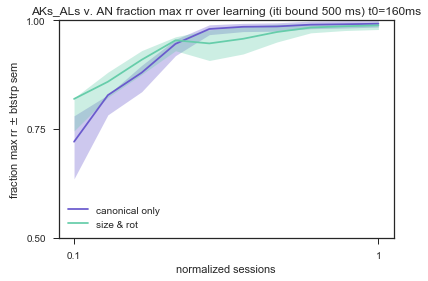

In [686]:
x = np.array(range(len(can_fraction_max_rr)))
y = np.array(can_fraction_max_rr)
yerr = np.array(can_fraction_max_rr_err)

plt.fill_between(x = x, y1 = y + yerr[:,0], y2 = y - yerr[:,1], color = 'slateblue', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'slateblue', label = 'canonical only')

x = np.array(range(len(reg_fraction_max_rr)))
y = np.array(reg_fraction_max_rr)
yerr = np.array(reg_fraction_max_rr_err)

plt.fill_between(x = x, y1 = y + yerr[:,0], y2 = y - yerr[:,1], color = 'mediumaquamarine', alpha = 0.33, linewidth = 0)
plt.errorbar(x = x, y = y, color = 'mediumaquamarine', label = 'size & rot')

plt.legend()
plt.ylim(0.5, 1)
plt.yticks([0.5, 0.75, 1])
plt.xticks([0,9], [0.1, 1])
plt.xlabel('normalized sessions')
plt.ylabel('fraction max rr $\pm$ btstrp sem')
plt.title('AKs_ALs v. AN fraction max rr over learning (iti bound 500 ms) t0=160ms')
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_frac_max_rr_bound_500ms_over_learning.pdf')

In [ ]:
T0 = 350*0.001 # convert to seconds
Dcorr = 6370*0.001 # convert to seconds
Derr = 3136*0.001 # convert to seconds
with_itis = False
pct_max_rr_data = 'fraction_max_rr' # 'opportunity_cost'  

perf_dict = reg_perf
rt_dict = reg_rt_succ
corr_iti_dict = reg_iti_succ_adj_mean
err_iti_dict = reg_iti_fail_adj_mean

reg_pct_max_rr = {}
for animal in perf_dict.keys():
    for session in range(len(perf_dict[animal])):
        try:
            reg_pct_max_rr[animal].append(percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data])
        except KeyError:
            reg_pct_max_rr[animal] = [percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data]]


perf_dict = can_perf
rt_dict = can_rt_succ
corr_iti_dict = can_iti_succ_adj_mean
err_iti_dict = can_iti_fail_adj_mean

can_pct_max_rr = {}
for animal in perf_dict.keys():
    for session in range(len(perf_dict[animal])):
        try:
            can_pct_max_rr[animal].append(percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data])
        except KeyError:
            can_pct_max_rr[animal] = [percent_max_rr_iti(rt_dict[animal][session]*0.001, perf_dict[animal][session], T0, Dcorr, Derr, corr_iti_dict[animal][session]*0.001, err_iti_dict[animal][session]*0.001, with_itis)[pct_max_rr_data]] 
            
reg_pct_max_rr_last5_all = []
can_pct_max_rr_last5_all = []
for animal in reg_pct_max_rr.keys():
    reg_pct_max_rr_last5_all.append(reg_pct_max_rr[animal][-5:])
for animal in can_pct_max_rr.keys():
    can_pct_max_rr_last5_all.append(can_pct_max_rr[animal][-5:])

reg_pct_max_rr_last5_all_avg = np.mean(reg_pct_max_rr_last5_all, axis = 1)
reg_pct_max_rr_last5_all_sem = stats.sem(reg_pct_max_rr_last5_all, axis = 1)
can_pct_max_rr_last5_all_avg = np.mean(can_pct_max_rr_last5_all, axis = 1)
can_pct_max_rr_last5_all_sem = stats.sem(can_pct_max_rr_last5_all, axis = 1)

# reg_pct_max_rr_all = reg_pct_max_rr.values()
# can_pct_max_rr_all = can_pct_max_rr.values()

# reg_pct_max_rr_all_avg = np.mean(reg_pct_max_rr_all, axis = 0)
# reg_pct_max_rr_all_sem = stats.sem(reg_pct_max_rr_all, axis = 0)
# can_pct_max_rr_all_avg = np.mean(can_pct_max_rr_all, axis = 0)
# can_pct_max_rr_all_sem = stats.sem(can_pct_max_rr_all, axis = 0)

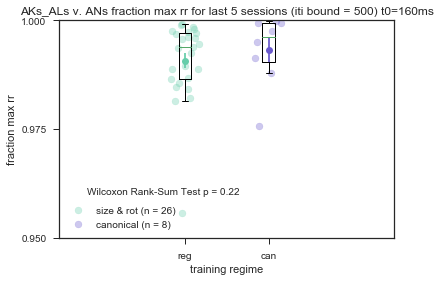

In [685]:
#plot mean of session means of accuracy by training regime

alpha = 0.33

x1 = [1.5]
y1 = [np.mean(reg_pct_max_rr_last5_all_avg)]
yerr1 = [stats.sem(reg_pct_max_rr_last5_all_avg)]
label1 = 'size & rot (n = 26)'

x2 = [4.5]
y2 = [np.mean(can_pct_max_rr_last5_all_avg)]
yerr2 = [stats.sem(can_pct_max_rr_last5_all_avg)]
label2 = 'canonical (n = 8)' 

plt.boxplot((reg_pct_max_rr_last5_all_avg, can_pct_max_rr_last5_all_avg), positions = (1.5, 4.5))

plt.scatter(np.random.rand(1,len(reg_pct_max_rr_last5_all_avg))+1, reg_pct_max_rr_last5_all_avg, marker = 'o', color = 'mediumaquamarine', alpha = alpha, label = label1)
plt.scatter(np.random.rand(1,len(can_pct_max_rr_last5_all_avg))+4, can_pct_max_rr_last5_all_avg, marker = 'o', color = 'slateblue', alpha = alpha, label = label2)

plt.errorbar(x = x1, y = y1, yerr = yerr1, marker = 'o', color = 'mediumaquamarine')
plt.errorbar(x = x2, y = y2, yerr = yerr2, marker = 'o', color = 'slateblue')

plt.legend()
plt.xlim(-3,9)
plt.ylim(0.95,1)
# plt.xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5], ['prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.', 'prev. err.', 'prev. corr.'])
plt.xticks([1.5, 4.5], ['reg', 'can'])
plt.yticks([0.95, 0.975, 1])
s = 'Wilcoxon Rank-Sum Test p = %.2f' %scipy.stats.ranksums(reg_pct_max_rr_last5_all_avg, can_pct_max_rr_last5_all_avg)[1]
plt.text(-2, 0.96, s)
plt.xlabel('training regime')
plt.ylabel('fraction max rr')
plt.title('AKs_ALs v. ANs fraction max rr for last 5 sessions (iti bound = 500) t0=160ms')
#plt.savefig('_graphs_AN/AN_versus_AK_AL/AK_AL_v_AN_frac_max_rr_bound_500ms_last5_sessions.pdf')

In [73]:
# # extract performance, reaction time and iti data from results_AK_AL and adjusted_itis_by_animal_by_session

# perf = {}
# rt = {}
# perf_err = {}
# rt_err = {}
# iti_corr = {}
# iti_err = {}
# iti_all = {}

# mean_of_all_itis = False # if true, average across all itis, even very long ones. if false, average from 0 to boundary
# boundary = 2000 # boundary up to which the itis will be averaged

# for animal in results_AK_AL.keys():
#     print 'extracting data for %s' %animal
#     if animal not in ['AL12']:
#         for session in sorted(results_AK_AL[animal]['pct_correct_by_session'].keys()):
#             try:
#                 perf[animal].append(results_AK_AL[animal]['pct_correct_by_session'][session])
#                 rt[animal].append(results_AK_AL[animal]['avg_rt_success_by_session'][session]*0.001)
#                 perf_err[animal].append(results_AK_AL[animal]['pct_correct_bootstrap_error_by_session'][session])
#                 rt_err[animal].append(results_AK_AL[animal]['rt_success_bootstrap_error_by_session'][session]*0.001)
                
#                 # if want just mean of all itis
#                 if mean_of_all_itis == True:
#                     iti_corr[animal].append(np.mean(adjusted_itis_by_animal_by_session[animal][session]['success']))
#                     iti_err[animal].append(np.mean(adjusted_itis_by_animal_by_session[animal][session]['failure']))
#                     iti_all[animal].append(np.mean(adjusted_itis_by_animal_by_session[animal][session]['all_trials']))
#                 # if want mean up to a boundary
#                 else:
#                     iti_corr[animal].append(np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['success'] if 0 <= i < boundary]))
#                     iti_err[animal].append(np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['failure'] if 0 <= i < boundary]))
#                     iti_all[animal].append(np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['all_trials'] if 0 <= i < boundary]))

#             except KeyError:
#                 perf[animal] = [results_AK_AL[animal]['pct_correct_by_session'][session]]
#                 rt[animal] = [results_AK_AL[animal]['avg_rt_success_by_session'][session]*0.001]
#                 perf_err[animal] = [results_AK_AL[animal]['pct_correct_bootstrap_error_by_session'][session]]
#                 rt_err[animal] = [results_AK_AL[animal]['rt_success_bootstrap_error_by_session'][session]*0.001]
                
#                 # if want just mean of all itis
#                 if mean_of_all_itis == True:
#                     iti_corr[animal] = [np.mean(adjusted_itis_by_animal_by_session[animal][session]['success'])]
#                     iti_err[animal] = [np.mean(adjusted_itis_by_animal_by_session[animal][session]['failure'])]
#                     iti_all[animal] = [np.mean(adjusted_itis_by_animal_by_session[animal][session]['all_trials'])]
#                 # if want mean up to a boundary
#                 else:
#                     iti_corr[animal] = [np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['success'] if 0 <= i < boundary])]
#                     iti_err[animal] = [np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['failure'] if 0 <= i < boundary])]
#                     iti_all[animal] = [np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['all_trials'] if 0 <= i < boundary])]

extracting data for AL8


NameError: name 'adjusted_itis_by_animal_by_session' is not defined

In [351]:
dcorr = 6.370
derr = 3.136

min_t0 = 0.0
max_t0 = 0.5
step_t0 = 0.025
t_not = np.arange(min_t0, max_t0 + step_t0, step_t0)

min_iti = 0
max_iti = 10
step_iti = 0.25
i_t_i = np.arange(min_iti, max_iti + step_iti, step_iti)

# t_not_and_iti = np.meshgrid(t_not, i_t_i)
t_not_and_iti = list(product(t_not, i_t_i))


perf = reg_perf_last10
rt = reg_rt_succ_last10

animal_frac_max_rr = {}
# for animal in sorted(perf.keys()):
for animal in ['AL9', 'AL14']:
    sesh_frac_max_rr = {}
    for i in range(len(perf[animal])):
        rt_sesh = rt[animal][i]*0.001
        perf_sesh = perf[animal][i]
        for j in range(len(t_not_and_iti)):
            tnot = t_not_and_iti[j][0]
            iti = t_not_and_iti[j][1]
            try:
                sesh_frac_max_rr[(tnot, iti)].append(percent_max_rr_iti(rt = rt_sesh, perf = perf_sesh, t0 = tnot, dcorr = dcorr, derr = derr, corr_iti = iti, err_iti = iti, with_itis = True)['fraction_max_rr'])                        
            except KeyError:
                sesh_frac_max_rr[(tnot, iti)] = [percent_max_rr_iti(rt = rt_sesh, perf = perf_sesh, t0 = tnot, dcorr = dcorr, derr = derr, corr_iti = iti, err_iti = iti, with_itis = True)['fraction_max_rr']]

    animal_frac_max_rr[animal] = sesh_frac_max_rr

#### contour plot of fraction max rr over t0 and iti values

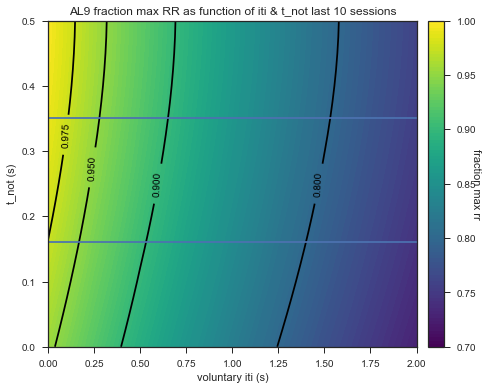

In [393]:
for animal in sorted(animal_frac_max_rr.keys()):
    avg_array_first5 = []
    avg_array_last10 = []
    for i in sorted(animal_frac_max_rr[animal].keys()):
#     for i in sorted(sesh_frac_max_rr.keys()):
        avg_array_first5.append(np.mean(animal_frac_max_rr[animal][i][:5]))
        avg_array_last10.append(np.mean(animal_frac_max_rr[animal][i][-10:]))

    x = i_t_i
    y = t_not
    X, Y = np.meshgrid(x, y) # create X and Y axes
    
    # CHOOSE DATA HERE
    two_d_plot = np.reshape(np.asarray(avg_array_last10), (len(t_not), len(i_t_i))) # reshape data into 2D
    
    plt.close()
    plt.figure(1)
    plt.figure(figsize = (8,6))
    
#     plt.subplot(111)
    levels = np.linspace(0.70, 1.0, 100) # to create smooth contour spacing
    plt.contourf(X, Y, two_d_plot, levels = levels, cmap = 'viridis') # filled contour plot with data
    ticks = np.linspace(0.5, 1.0, 11)
    cbar = plt.colorbar(ticks = ticks, pad = 0.025)
    cbar.set_label('fraction max rr', rotation = '270')
#     plt.subplot(111)
    levels2 = np.linspace(0.8, 1.0, 9) # to create contour line at 0.95
    levels2 = [0.8, 0.9, 0.95, 0.975]
    ninetyfive = plt.contour(X, Y, two_d_plot, levels = levels2, colors = 'k') # contour line at 0.95
    plt.clabel(ninetyfive, levels2)
    plt.axhline(0.35)
    plt.axhline(0.16)
    plt.xlim(0,2)
    plt.ylim(0, .5)
    plt.xlabel('voluntary iti (s)')
    plt.ylabel('t_not (s)')
    plt.title('%s fraction max RR as function of iti & t_not last 10 sessions' %animal)
    
#     #plt.savefig('_graphs_tnot_iti_rr_analysis/%s_fraction_max_rr_by_iti_&_t0_last10sessions_updated_Drsi.pdf' %animal)

In [ ]:
# # calculate percent max reward rate with performance and reaction time data
# # using default t0 = 0.160 s 

# T0 = 0.16

# fraction_max_rr = {}
# for animal in perf.keys():
#     for i in range(len(perf[animal])):
#         try:
#             fraction_max_rr[animal].append(percent_max_rr_iti(rt[animal][i], perf[animal][i], T0))
#         except KeyError:
#             fraction_max_rr[animal] = [percent_max_rr_iti(rt[animal][i], perf[animal][i], T0)]


# fraction_max_rr_err = {}
# for animal in perf.keys():
#         for i in range(len(perf[animal])):
#             topright = (rt[animal][i] + rt_err[animal][i], max(0.501, perf[animal][i] - perf_err[animal][i]))
#             bottleft = (rt[animal][i] - rt_err[animal][i], max(0.501, perf[animal][i] + perf_err[animal][i]))
#             topright_frac_max_err = percent_max_rr_iti(topright[0], topright[1], T0)
#             bottleft_frac_max_err = percent_max_rr_iti(bottleft[0], bottleft[1], T0)
#             topright_err = abs(fraction_max_rr[animal][i] - topright_frac_max_err)
#             bottleft_err = abs(bottleft_frac_max_err - fraction_max_rr[animal][i])

#             try:
#                 fraction_max_rr_err[animal].append((topright_err, bottleft_err))
#             except KeyError:
#                 fraction_max_rr_err[animal] = [(topright_err, bottleft_err)]
                
# # print fraction_max_rr_err

# # calculate the average and standard deviation of percent max reward rate
# # do so for trained animals (last 10 sessions) and naive animals (first 5 sessions)

# trained_avg_max_rr = {}
# trained_std_max_rr = {}
# naive_avg_max_rr = {}
# naive_std_max_rr = {}
# for animal in fraction_max_rr.keys():
#     trained_avg_max_rr[animal] = np.mean(fraction_max_rr[animal][-10:]) # last ten sessions
#     trained_std_max_rr[animal] = np.std(fraction_max_rr[animal][-10:]) # last ten sessions
#     naive_avg_max_rr[animal] = np.mean(fraction_max_rr[animal][:5]) # first five sessions
#     naive_std_max_rr[animal] = np.std(fraction_max_rr[animal][:5]) # first five sessions

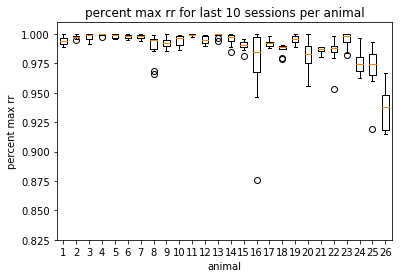

In [15]:
# make a box plot for the trained and/or naive animals
# note that it is very hard to control color, etc with plt.boxplot

d = []
for animal in fraction_max_rr.keys():
    d.append((fraction_max_rr[animal][-10:], fraction_max_rr[animal][:5]))

# d = [fraction_max_rr['AK1'][:2], fraction_max_rr['AK1'][-10:]]

d = sorted(d, reverse = True)

d_trained = [i[0] for i in d]
d_naive = [i[1] for i in d]

# plt.boxplot(d_naive, patch_artist = True)
plt.boxplot(d_trained)
plt.ylim(0.825, 1.01)
plt.xlabel('animal')
plt.ylabel('percent max rr')
plt.title('percent max rr for last 10 sessions per animal')
# #plt.savefig('percent_max_rr_last_10_trained_sessions_AK_AL.pdf')

In [261]:
# make a box plot for the trained and/or naive animals
# note that it is very hard to control color, etc with plt.boxplot

# make multiple plots for multiple t0s

for t0 in sorted(t0_fraction_max_rr.keys()):
    d = []
    for animal in t0_fraction_max_rr[t0].keys():
        d.append((t0_fraction_max_rr[t0][animal][-10:], t0_fraction_max_rr[t0][animal][:5]))

    # d = [fraction_max_rr['AK1'][:2], fraction_max_rr['AK1'][-10:]]

    d = sorted(d, reverse = True)

    d_trained = [i[0] for i in d]
    d_naive = [i[1] for i in d]

    # plt.boxplot(d_naive, patch_artist = True)
    plt.boxplot(d_trained)
    plt.ylim(0.825, 1.01)
    plt.xlabel('animal')
    plt.ylabel('percent max rr')
    plt.title('percent max rr for last 10 sessions per animal t0 = %.2f' %t0)
    #plt.savefig('percent_max_rr_t0_%.2f_last_10_trained_sessions_AK_AL.pdf' %t0)
    plt.close()

In [17]:
num = 1
for a in d_trained:
    #print 'a = ', a
    print num
    sampresult = stats.ttest_1samp(a, 0.999, axis = 0)
#     sampresult = stats.wilcoxon([i-1 for i in a])
    print 'p =', sampresult[1]
    num += 1
    print ' '

1
p = 0.00298394422354
 
2
p = 0.0233826872476
 
3
p = 0.238328992818
 
4
p = 0.0884539397212
 
5
p = 0.43815991515
 
6
p = 0.0870578777696
 
7
p = 0.045246742881
 
8
p = 0.0313790119611
 
9
p = 0.00159443549626
 
10
p = 0.0195024358749
 
11
p = 0.646934032613
 
12
p = 0.00836148580902
 
13
p = 0.808041264363
 
14
p = 0.0718770297598
 
15
p = 9.23789749508e-05
 
16
p = 0.0592346003281
 
17
p = 6.58193492144e-05
 
18
p = 1.29639459602e-05
 
19
p = 0.0157350103868
 
20
p = 0.00247826512173
 
21
p = 1.15675467992e-07
 
22
p = 0.00716039206462
 
23
p = 0.0881033961448
 
24
p = 6.38734446763e-05
 
25
p = 0.0020937096276
 
26
p = 2.35520572361e-06
 


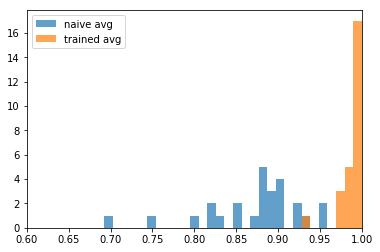

In [18]:
# make a histogram for trained and/or naive animals with average percent max rr

d_trained_avg = []
d_naive_avg = []
for animal in trained_avg_max_rr.keys():
    d_trained_avg.append(trained_avg_max_rr[animal])
    d_naive_avg.append(naive_avg_max_rr[animal])

bins = np.linspace(0.6, 1, 40)
plt.hist(d_naive_avg, bins = bins, alpha = 0.7, label = 'naive avg')
plt.hist(d_trained_avg, bins = bins, alpha = 0.7, label = 'trained avg')
plt.legend()
plt.xlim(0.60, 1.0)
#plt.savefig('hist_avg_percent_max_rr_trained_naive_AK_AL.pdf')

<Container object of 3 artists>

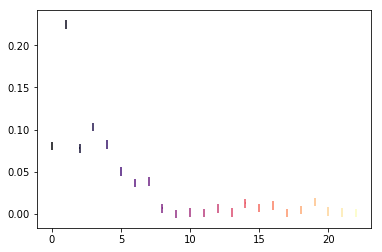

In [19]:
# create opportunity cost dictionary from fraction_max_rr

rr_opp_cost = {key:[1-x for x in fraction_max_rr[key]] for (key,val) in fraction_max_rr.items()}

y = rr_opp_cost['AL14']
x = range(len(y))

xerr = 0.005
yerr = 0.005

c = plt.cm.magma(np.linspace(0.,1,len(x)))

plt.errorbar(x = x, y = rr_opp_cost['AL14'], xerr = xerr, yerr = yerr, linestyle = ' ', color = c)

In [20]:
results_AK_AL['AL14']['bootstrap_error_by_session']['AL14_170807.mwk']

0.014763755350425935

In [21]:
# change success/failure to 1/0 for averaging purposes
session_outcomes_num = {}
for animal in session_outcomes.iterkeys():
    session_outcomes_num[animal] = {key : [0 if i == 'success' else 1 for i in data] for key, data in session_outcomes[animal].items()}

# change RTs for OPC 
session_RTs_OPC = {}
for animal in session_RTs.iterkeys():
    session_RTs_OPC[animal] = {key : [(i-160)/3150 for i in data] for key, data in session_RTs[animal].items()}

NameError: name 'session_outcomes' is not defined

### ITI Analysis

(array([  7.84401614e-06,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.83236217e-04,   1.26624832e-04,   1.34468848e-05,
          1.25504258e-04,   1.68086060e-05,   4.14612281e-05,
          3.92200807e-05,   1.68086060e-05,   3.24966383e-05,
          1.56880323e-05,   2.12909009e-05,   3.02554908e-05,
          1.56880323e-05,   1.68086060e-05,   1.68086060e-05,
          2.24114747e-05,   2.22994173e-04,   2.44621246e-03,
          2.24114747e-05,   4.16853429e-04,   6.49932766e-05,
          3.24966383e-05,   2.19632452e-04,   2.46526221e-05,
          9.18870462e-05,   3.02554908e-05,   1.34468848e-05,
          5.71492604e-05,   2.24114747e-05,   6.94755715e-05,
          5.71492604e-05,   7.39578664e-05,   7.05961452e-05,
        

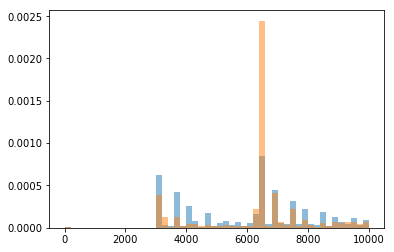

In [47]:
data_iti = [i*0.001 for i in results_AK_AL['AK12']['iti_by_session']['AK12_170615.mwk']]

animal = 'AK12'

data_iti1 = [i*0.001 for i in results_AK_AL[animal]['iti_by_trial']][0:5000]
data_iti2 = [i*0.001 for i in results_AK_AL[animal]['iti_by_trial']][-5000:]


plt.hist(data_iti1, bins = 50, range = (0, 10000), alpha = 0.5, normed = True)
plt.hist(data_iti2, bins = 50, range = (0, 10000), alpha = 0.5, normed = True)

In [19]:
np.median(results_AK_AL['AK12']['iti_by_session']['AK12_170615.mwk'])*0.001 

6898.0190000000002

#### trial iti analysis

In [150]:
dataset = results_AK_AL
succ_min_iti = 6100 #ms
fail_min_iti = 2800 #ms

adjusted_itis_by_animal = {}
for animal in dataset.keys():
    adjusted_itis = {}
    success_itis = []
    failure_itis = []
    ignore_itis = []
    all_itis = []
    for trial in range(len(dataset[animal]['iti_by_trial'])):

        if trial == 0:
            pass
        elif trial >= 1:
            if dataset[animal]['outcome_by_trial'][trial - 1] == 'success':
                success_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001 - succ_min_iti) # must convert itis to ms
                all_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001 - succ_min_iti)
            elif dataset[animal]['outcome_by_trial'][trial - 1] == 'failure':
                failure_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001 - fail_min_iti)
                all_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001 - fail_min_iti)
            # currently no ignore trials taken into account in the pickle files
#             elif dataset[animal]['outcome_by_trial'][trial - 1] == 'ignore':
#                 ignore_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001)
#                 all_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001)
            else:
                pass
        adjusted_itis['success'] = success_itis
        adjusted_itis['failure'] = failure_itis
#         adjusted_itis['ignore'] = ignore_itis
        adjusted_itis['all_trials'] = all_itis
        
    adjusted_itis_by_animal[animal] = adjusted_itis

AK1 median iti: 1833.677


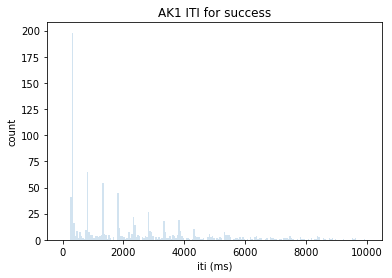

In [479]:
for animal in ['AK1']: #sorted(adjusted_itis_by_animal.keys()):
    range_ = (0, 10000)
    bins = 200
    alpha = 0.2
    trial_type = 'success'
    plt.hist(adjusted_itis_by_animal[animal][trial_type][-1000:], bins = bins, range = range_, alpha = alpha)
    plt.title('%s ITI for %s' %(animal, trial_type))
    plt.xlabel('iti (ms)')
    plt.ylabel('count')
    # #plt.savefig('AK9_iti_all_trials.pdf')
#     #plt.savefig('%s_iti_all_trials_0_to_2000.pdf' %animal)
#     plt.close()

    print animal, 'median iti:', np.median([i for i in adjusted_itis_by_animal[animal][trial_type][-10000:] if i >= 0])

#### session iti analysis

In [660]:
dataset = results_AK_AL
succ_min_iti = 5800 #ms
fail_min_iti = 2800 #ms

adjusted_itis_by_animal_by_session = {} # organize itis by animal, then session, then type of trial
adjusted_itis_by_animal_by_type = {} # organize itis by animal, then type of trial, then session
for animal in dataset.keys():
    print 'collecting itis for %s' %animal
    adjusted_itis_success = {}
    adjusted_itis_failure = {}
    adjusted_itis_all_trials = {}
    adjusted_itis_by_type = {}
    adjusted_itis_by_session = {}
    for session in dataset[animal]['iti_by_session'].keys():
        adjusted_itis = {}
        success_itis = []
        failure_itis = []
        ignore_itis = []
        all_itis = []
        for trial in range(len(dataset[animal]['iti_by_session'][session])):
            if trial == 0:
                pass
            elif trial >= 1:
                if dataset[animal]['beh_outcome_by_session'][session][trial - 1] == 'success':
                    success_itis.append(dataset[animal]['iti_by_session'][session][trial]*0.001 - succ_min_iti) # must convert itis to ms
                    all_itis.append(dataset[animal]['iti_by_session'][session][trial]*0.001 - succ_min_iti)
                elif dataset[animal]['beh_outcome_by_session'][session][trial - 1] == 'failure':
                    failure_itis.append(dataset[animal]['iti_by_session'][session][trial]*0.001 - fail_min_iti)
                    all_itis.append(dataset[animal]['iti_by_session'][session][trial]*0.001 - fail_min_iti)
                # currently no ignore trials taken into account in the pickle files
    #             elif dataset[animal]['outcome_by_trial'][trial - 1] == 'ignore':
    #                 ignore_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001)
    #                 all_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001)
                else:
                    pass

        # organize by type of trial and then session
        adjusted_itis_success[session] = success_itis
        adjusted_itis_failure[session] = failure_itis
        adjusted_itis_all_trials[session] = all_itis

        # organize by session and then type of trial
        adjusted_itis['success'] = success_itis
        adjusted_itis['failure'] = failure_itis
#         adjusted_itis['ignore'] = ignore_itis
        adjusted_itis['all_trials'] = all_itis
        adjusted_itis_by_session[session] = adjusted_itis

    # organize by type of trial and then session
    adjusted_itis_by_type['success'] = adjusted_itis_success
    adjusted_itis_by_type['failure'] = adjusted_itis_failure
    adjusted_itis_by_type['all_trials'] = adjusted_itis_all_trials
    # organize by type of trial and then session
    adjusted_itis_by_animal_by_type[animal] = adjusted_itis_by_type

    # organize by session and then type of trial
    adjusted_itis_by_animal_by_session[animal] = adjusted_itis_by_session

collecting itis for AL8
collecting itis for AL9
collecting itis for AL6
collecting itis for AL7
collecting itis for AL4
collecting itis for AL5
collecting itis for AL2
collecting itis for AL3
collecting itis for AL1
collecting itis for AL12
collecting itis for AK11
collecting itis for AK12
collecting itis for AK10
collecting itis for AL10
collecting itis for AL11
collecting itis for AK9
collecting itis for AL13
collecting itis for AL14
collecting itis for AL15
collecting itis for AL16
collecting itis for AK3
collecting itis for AK2
collecting itis for AK1
collecting itis for AK7
collecting itis for AK6
collecting itis for AK5
collecting itis for AK4


In [663]:
# demonstrating the two dictionaries have the same information, just organized differently

adjusted_itis_by_animal_by_type['AK1']['success']['AK1_170630.mwk'] == adjusted_itis_by_animal_by_session['AK1']['AK1_170630.mwk']['success']

True

#### extract perf, rt and iti data for easy plotting

In [646]:
# extract performance, reaction time and iti data from results_AK_AL and adjusted_itis_by_animal_by_session

perf = {}
rt = {}
perf_err = {}
rt_err = {}
iti_corr = {}
iti_err = {}
iti_all = {}

mean_of_all_itis = False # if true, average across all itis, even very long ones. if false, average from 0 to boundary
boundary = 2000 # boundary up to which the itis will be averaged

for animal in results_AK_AL.keys():
    print 'extracting data for %s' %animal
    if animal not in ['AK12']:
        for session in sorted(results_AK_AL[animal]['pct_correct_by_session'].keys()):
            try:
                perf[animal].append(results_AK_AL[animal]['pct_correct_by_session'][session])
                rt[animal].append(results_AK_AL[animal]['avg_rt_success_by_session'][session]*0.001)
                perf_err[animal].append(results_AK_AL[animal]['bootstrap_error_by_session'][session])
                rt_err[animal].append(results_AK_AL[animal]['rt_success_error_by_session'][session]*0.001)
                
                # if want just mean of all itis
                if mean_of_all_itis == True:
                    iti_corr[animal].append(np.mean(adjusted_itis_by_animal_by_session[animal][session]['success']))
                    iti_err[animal].append(np.mean(adjusted_itis_by_animal_by_session[animal][session]['failure']))
                    iti_all[animal].append(np.mean(adjusted_itis_by_animal_by_session[animal][session]['all_trials']))
                # if want mean up to a boundary
                else:
                    iti_corr[animal].append(np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['success'] if 0 <= i < boundary]))
                    iti_err[animal].append(np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['failure'] if 0 <= i < boundary]))
                    iti_all[animal].append(np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['all_trials'] if 0 <= i < boundary]))

            except KeyError:
                perf[animal] = [results_AK_AL[animal]['pct_correct_by_session'][session]]
                rt[animal] = [results_AK_AL[animal]['avg_rt_success_by_session'][session]*0.001]
                perf_err[animal] = [results_AK_AL[animal]['bootstrap_error_by_session'][session]]
                rt_err[animal] = [results_AK_AL[animal]['rt_success_error_by_session'][session]*0.001]
                
                # if want just mean of all itis
                if mean_of_all_itis == True:
                    iti_corr[animal] = [np.mean(adjusted_itis_by_animal_by_session[animal][session]['success'])]
                    iti_err[animal] = [np.mean(adjusted_itis_by_animal_by_session[animal][session]['failure'])]
                    iti_all[animal] = [np.mean(adjusted_itis_by_animal_by_session[animal][session]['all_trials'])]
                # if want mean up to a boundary
                else:
                    iti_corr[animal] = [np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['success'] if 0 <= i < boundary])]
                    iti_err[animal] = [np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['failure'] if 0 <= i < boundary])]
                    iti_all[animal] = [np.mean([i for i in adjusted_itis_by_animal_by_session[animal][session]['all_trials'] if 0 <= i < boundary])]

extracting data for AL8
extracting data for AL9
extracting data for AL6
extracting data for AL7
extracting data for AL4
extracting data for AL5
extracting data for AL2
extracting data for AL3
extracting data for AL1
extracting data for AL12
extracting data for AK11
extracting data for AK12
extracting data for AK10
extracting data for AL10
extracting data for AL11
extracting data for AK9
extracting data for AL13
extracting data for AL14
extracting data for AL15
extracting data for AL16
extracting data for AK3
extracting data for AK2
extracting data for AK1
extracting data for AK7
extracting data for AK6
extracting data for AK5
extracting data for AK4


In [673]:
# create dict that now has mean itis

adjusted_mean_itis_by_animal_by_type = {}

mean_of_all_itis = False # if true, average across all itis, even very long ones. if false, average from 0 to boundary
boundary = 2000 # boundary up to which the itis will be averaged 

for animal in adjusted_itis_by_animal_by_type.keys():
    mean_iti_by_type = {}
    for trial_type in adjusted_itis_by_animal_by_type[animal].keys():
        mean_sesh_iti = {}
        for session in adjusted_itis_by_animal_by_type[animal][trial_type].keys():
            if mean_of_all_itis == True: # averaging all itis
                mean_sesh_iti[session] = np.mean(adjusted_itis_by_animal_by_type[animal][trial_type][session])
            else: # averaging up to the boundary
                mean_sesh_iti[session] = np.mean([i for i in adjusted_itis_by_animal_by_type[animal][trial_type][session] if 0 <= i < boundary])
        mean_iti_by_type[trial_type] = mean_sesh_iti
    adjusted_mean_itis_by_animal_by_type[animal] = mean_iti_by_type

In [ ]:
adjusted_mean_itis_by_animal_by_type['AK1']['success']['AK1_170630.mwk']

In [667]:
adjusted_itis_by_animal_by_type['AK1']['success']

{'AK1_170531.mwk': [1144.152,
  32443.495000000003,
  2119.8320000000003,
  1520.6400000000003,
  33593.745,
  1118.0320000000002,
  605.0990000000002,
  20037.847,
  603.0439999999999,
  2100.035,
  3650.7970000000005,
  1555.8600000000006,
  608.4920000000002,
  24335.246,
  1642.3640000000005,
  5577.7880000000005,
  73172.493,
  72422.996,
  14285.957000000002,
  1308.6580000000004,
  2238.706,
  620.1360000000004,
  5039.611000000001,
  612.1680000000006,
  619.0010000000002,
  1139.6350000000002,
  5981.085000000001,
  611.4899999999998,
  2461.647000000001,
  646.6220000000003,
  782.6220000000003,
  616.3360000000002,
  623.0370000000003,
  5089.464,
  9384.629,
  613.2660000000005,
  1628.9120000000003,
  618.9260000000004,
  1849.5030000000006,
  5745.648000000001,
  597.7700000000004,
  618.8289999999997,
  3489.3250000000007,
  623.3180000000002,
  1123.9170000000004,
  635.067,
  613.1819999999998,
  612.643,
  23207.829,
  2791.812,
  2987.0609999999997,
  2128.227,
  446

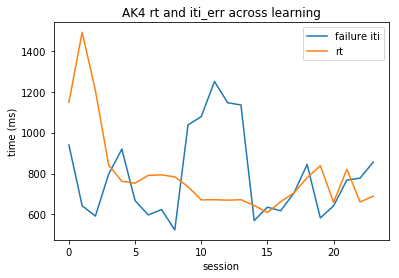

In [647]:
# plt.plot(iti_corr['AL4'], label = 'success')

for animal in iti_err.keys():
    plt.close()
    plt.plot(iti_err[animal], label = 'failure iti')
    plt.plot([i*1000 for i in rt[animal]], label = 'rt')
    plt.ylabel('time (ms)')
    plt.xlabel('session')
    plt.title('%s rt and iti_err across learning' %animal)
    plt.legend()
#     #plt.savefig('rt_and_iti_across_learning/%s_rt_and_iti_err_across_learning_iti_0_to_2000ms.pdf' %animal)

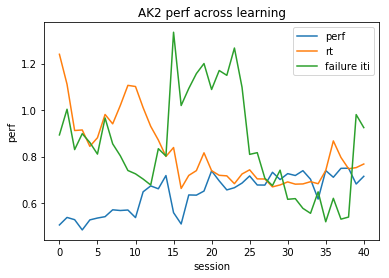

In [644]:
for animal in ['AK2']: # perf.keys():
    plt.close()
    plt.plot(perf[animal], label = 'perf')
    plt.plot(rt[animal], label = 'rt')
    plt.plot([i*0.001 for i in iti_err[animal]], label = 'failure iti')
    plt.legend()
    plt.ylabel('perf')
    plt.xlabel('session')
    plt.title('%s perf across learning' %animal)

In [703]:
def mesh_data(results, datakey):
    d = {}
    for animal in results.keys():
#         i = results[animal]['norm_session_indices'] # indexed session list comes pre-made from get_data_for_figure()
        i = [(x+1)/len(results[animal][datakey]) for x in range(len(results[animal][datakey]))]
        y = []
        y_data = results[animal][datakey]
        if type(y_data) == dict:
            for session in sorted(y_data.iterkeys()):
                y.append(y_data[session])
            d[animal] = {'i': i, 'y': y}
        elif type(y_data) == list:
            y = y_data
            d[animal] = {'i': i, 'y': y}

    all_y = []
    all_i = []
    for a in d.iterkeys():
        # print 'key = ' + a
        if len(all_i) == 0:
            # print 'in if statement'
            all_i = d[a]['i']
            all_y = d[a]['y']
            # print all_i
            # print all_x
        else:
            # print 'in else statement'
            for j in range(len(d[a]['i'])):
                # print 'first for loop'
                for i in range(len(all_i)):
                    # print 'second for loop'
                    if all_i[i] >= d[a]['i'][j]:
                        #print 'first half'
                        #print all_x[:i]
                        all_i = all_i[:i] + [d[a]['i'][j]] + all_i[i:]
                        all_y = all_y[:i] + [d[a]['y'][j]] + all_y[i:]
                        # print all_i
                        # print all_x
                        break

    # print 'all_x:', all_x
    # print ' '
    # print 'all_i:', all_i

    meshed_data = {'all_i': all_i, 'all_y': all_y}

    return meshed_data

def avg_binned_data(meshed_data, n_bins):
    x_data = meshed_data['all_i']
    y_data = meshed_data['all_y']

    # if every animal has the exact number of sessions, add some noise to the indices to shuffle them:
    if wiggle_session_indices == True:
        x_data = [(i+(random.uniform(-1,1)/25)) for i in x_data]
    else:
        pass


    n_bins = n_bins
    
    x_n, x_bins, x_patches = plt.hist(x_data, bins = n_bins)

    # based on the bins for x_data, bin y_data
    # note that this code creates an extra bin at the end because there is one more bin value than bins
    # that is fixed with a for loop below
    y_bins = []
    for i in range(len(x_bins)):
        y_bin = []
        for j in range(len(x_data)):
            if i < (len(x_bins)-1):
                if (x_data[j] >= x_bins[i] and (x_data[j] < x_bins[i+1])):
                    y_bin.append(y_data[j])
                else:
                    pass
            elif i >= (len(x_bins)-1):
                if x_data[j] == (x_bins[i]):
                    y_bin.append(y_data[j])
                else:
                    pass
        y_bins.append(y_bin)

    # the above code creates an extra bin at the end
    # this for loop combines the last two bins
    for i in range(len(y_bins)):
        if i == (len(y_bins)-1):
            y_bins[i-1] = y_bins[i-1] + y_bins[i]
            y_bins.pop(i)
        else:
            pass

    # calculate the mean for values in every bin
    y_bins_mean = []
    y_bins_std = []
    y_bins_sem = []
    y_bins_median = []
    y_bins_25percentile = []
    y_bins_75percentile = []
    for i in y_bins:
#         if 0 in i:
#             i = [0.001 if x == 0 else x for x in i] # if there are zeroes, convert to small values to not have issues with averaging
#         else:
#             pass
        y_bins_mean.append(np.nanmean(i))
        y_bins_median.append(np.nanmedian(i))
        y_bins_25percentile.append(np.median(i) - np.percentile(i, q = 25))
        y_bins_75percentile.append(np.percentile(i, q = 75) - np.median(i))
        y_bins_std.append(np.std(i))
        y_bins_sem.append(np.std(i)/math.sqrt(len(i)))

    # calculate bin centers in order to plot the mean
    x_bincenters = [np.mean([x_bins[i],x_bins[i+1]]) for i in range(len(x_bins)-1)]

#     # Plot
#     xmin = -0.05 # indexed sessions from 0 to 1
#     xmax = 1.05
#     ymin = 0.4 # performance from 0 to 1
#     ymax = 1.0

#     fig = plt.figure()
#     plt.plot(x_data, y_data, 'r.', markersize=10, label=u'observations')
#     plt.errorbar(x_bincenters, y_bins_mean, yerr = y_bins_sem, fmt = 'bo-', label=u'binned average')
#     plt.xlabel('normalized session time')
#     plt.ylabel('mean performance $\pm$ sem')
#     plt.axis([xmin, xmax, ymin, ymax])
#     plt.legend(loc='lower right')
#     #plt.savefig('AK_Cohort_perf_binned_avg.pdf')
#     plt.close()
#     # plt.show()

    avg_binned_data = {
    'x_bins': x_bins,
    'x_bincenters': x_bincenters,
    'y_bins': y_bins,
    'y_bins_mean': y_bins_mean,
    'y_bins_std': y_bins_std,
    'y_bins_sem': y_bins_sem,
    'y_bins_median': y_bins_median,
    'y_bins_25percentile': y_bins_25percentile,
    'y_bins_75percentile': y_bins_75percentile
    }

    return avg_binned_data

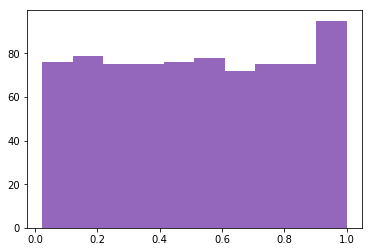

In [715]:
meshed_data_rt = mesh_data(results_AK_AL, 'avg_rt_success_by_session')
meshed_data_perf = mesh_data(results_AK_AL, 'pct_correct_by_session')
meshed_data_iti_err = mesh_data(adjusted_mean_itis_by_animal_by_type, 'failure')
meshed_data_iti_corr = mesh_data(adjusted_mean_itis_by_animal_by_type, 'success')
meshed_data_iti_all = mesh_data(adjusted_mean_itis_by_animal_by_type, 'all_trials')

n_bins = 10
binned_avg_rt = avg_binned_data(meshed_data_rt, n_bins)
binned_avg_perf = avg_binned_data(meshed_data_perf, n_bins)
binned_avg_iti_err = avg_binned_data(meshed_data_iti_err, n_bins)
binned_avg_iti_corr = avg_binned_data(meshed_data_iti_corr, n_bins)
binned_avg_iti_all = avg_binned_data(meshed_data_iti_all, n_bins)

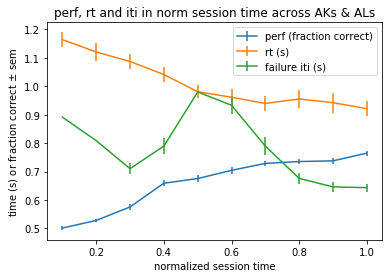

In [705]:
binned_avg_iti_err['y_bins_mean']

# plt.plot([i*0.001 for i in binned_avg_iti_err['y_bins_mean']], label = 'failure iti')
# plt.plot([i*0.001 for i in binned_avg_rt['y_bins_mean']], label = 'rt')
# plt.plot(binned_avg_perf['y_bins_mean'], label = 'perf')

x = [(i+1)/len(binned_avg_perf['y_bins_mean']) for i in range(len(binned_avg_perf['y_bins_mean']))]
y1 = binned_avg_perf['y_bins_mean']
yerr1 = binned_avg_perf['y_bins_sem']

y2 = [i*0.001 for i in binned_avg_rt['y_bins_mean']]
yerr2 = [i*0.001 for i in binned_avg_rt['y_bins_sem']]

y3 = [i*0.001 for i in binned_avg_iti_err['y_bins_mean']]
yerr3 = [i*0.001 for i in binned_avg_iti_err['y_bins_sem']]

plt.errorbar(x = x, y = y1, yerr = yerr1, label = 'perf (fraction correct)')
plt.errorbar(x = x, y = y2, yerr = yerr2, label = 'rt (s)')
plt.errorbar(x = x, y = y3, yerr = yerr3, label = 'failure iti (s)')
plt.legend()
plt.xlabel('normalized session time')
plt.ylabel('time (s) or fraction correct $\pm$ sem')
plt.title('perf, rt and iti in norm session time across AKs & ALs')

In [527]:
def calculate_opc():
    #this function returns a dictionary with two arrays with which to plot an optimal performance curve (OPC)

    #eta = (A/sigma)^2 (signal to noise ratio (drift rate to noise))
    #theta = | threshold / A | (ratio of threshold over drift rate)
    
    #make arrays with all possible values for eta and theta
    etas = np.arange(0.0001, 4, 0.01)
    thetas = np.arange(0.0001, 2.5, 0.01)
    e, th = np.meshgrid(etas, thetas)
    #calculate possible error rates with etas and thetas
    #pre-calculate 2*etas to reduce clutter and make equation legible
    e_x_2 = np.multiply(2,e)
    p_err = (1/(1 + np.exp(e_x_2*th)))
    #p_err is a huge array of arrays, but we only need the last array
    ind = len(p_err) - 1
    p_err = p_err[ind]
    #calculate mean normalized decision time as a function of p_err
    #pre-calculate components of equation to reduce clutter and make equation legible
    term1 = 1 / np.multiply(p_err, np.log((1-p_err)/p_err))
    term2 = 1 / (1 - np.multiply(2, p_err))
    mean_norm_dt = 1 / (term1 + term2)

    return {'p_err': p_err, 'mean_norm_dt': mean_norm_dt}

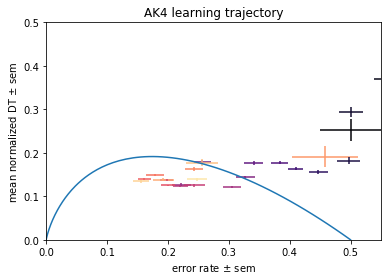

In [589]:
# transform data to plot in OPC space

t0 = 160 # in ms
derr = 2500 # without 300 ms blocking time

error_rate = {}
mean_norm_dt = {}
mean_norm_dt_err = {}

for animal in perf.keys():
    error_rate[animal] = [1 - i for i in perf[animal]]
    for session in range(len(iti_err[animal])):
        try: 
            mean_norm_dt[animal].append((rt[animal][session]*1000 - t0)/(t0 + derr + iti_err[animal][session]))
            mean_norm_dt_err[animal].append(rt_err[animal][session]*1000/(t0 + derr + iti_err[animal][session]))
        except KeyError:
            mean_norm_dt[animal] = [(rt[animal][session]*1000 - t0)/(t0 + derr + iti_err[animal][session])]
            mean_norm_dt_err[animal] = [(rt_err[animal][session]*1000)/(t0 + derr + iti_err[animal][session])]
            
    opc = calculate_opc()
    x_opc = opc['p_err']
    y_opc = opc['mean_norm_dt']

    x = error_rate[animal]
    y = mean_norm_dt[animal]
    xerr = perf_err[animal]
    yerr = mean_norm_dt_err[animal]

    xmin = 0.0
    xmax = 0.55
    ymin = 0.0
    ymax = 0.5

    c = plt.cm.magma(np.linspace(0.,0.95,len(x)))

    plt.close()
    plt.plot(x_opc, y_opc, label = 'opc')
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
    plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('error rate $\pm$ sem')
    plt.ylabel('mean normalized DT $\pm$ sem')
    plt.title('%s learning trajectory' %animal)
    #plt.savefig('opc_during_learning_with_iti_by_session/%s_opc_during_learning_with_iti_by_session_0_to_1000ms.pdf' %animal)

#### estimate normalized threshold z_bar

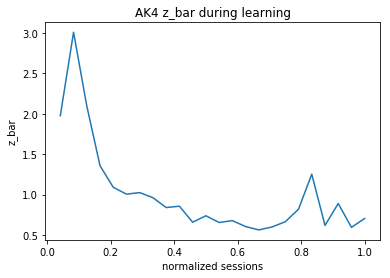

In [860]:
# calculate z_bar (threshold/SNR) for every animal during learning

t0 = 0.16

# equation for z_bar = DT / (1 - ER) = DT / PERF

z_bar = {}

for animal in perf.keys():
    for session in range(len(perf[animal])):
        try: 
            z_bar[animal].append((rt[animal][session] - t0)/(perf[animal][session]))
        except KeyError:
            z_bar[animal] = [(rt[animal][session] - t0)/(perf[animal][session])]

    x = [(i+1)/(len(perf[animal])) for i in range(len(perf[animal]))]
    y = z_bar[animal]

#     xmin = 0.0
#     xmax = 0.1
#     ymin = 0.0
#     ymax = 5000

    c = plt.cm.magma(np.linspace(0.,0.95,len(x)))

    plt.close()
    plt.plot(x, y, label = 'z_bar')
#     plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
#     plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('normalized sessions')
    plt.ylabel('z_bar')
    plt.title('%s z_bar during learning' %animal)
    #plt.savefig('%s_z_bar_during_learning.pdf' %animal)

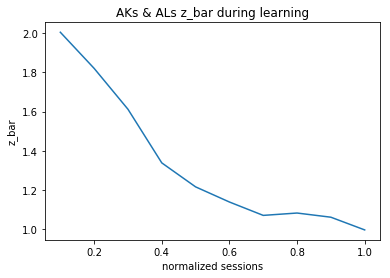

In [865]:
# calculate z_bar (threshold/SNR) for every animal during learning

t0 = 0.16

# equation for z_bar = DT / (1 - ER) = DT / PERF

z_bar_binned = []


for session in range(len(binned_avg_perf['y_bins_mean'])):
    z_bar_binned.append((binned_avg_rt['y_bins_mean'][session]*0.001 - t0)/(binned_avg_perf['y_bins_mean'][session]))


x = [(i+1)/(len(binned_avg_perf['y_bins_mean'])) for i in range(len(binned_avg_perf['y_bins_mean']))]
y = z_bar_binned

# xmin = 0.0
# xmax = 0.1
# ymin = 0.0
# ymax = 5000

c = plt.cm.magma(np.linspace(0.,0.95,len(x)))

plt.close()
plt.plot(x, y, label = 'z_bar')
#     plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
#     plt.axis([xmin, xmax, ymin, ymax])
plt.xlabel('normalized sessions')
plt.ylabel('z_bar')
plt.title('AKs & ALs z_bar during learning')
#plt.savefig('AKs_ALs_z_bar_during_learning.pdf')

#### estimate non-normalized threshold z over learning

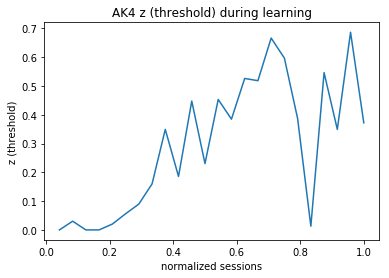

In [868]:
# calculate z_bar (threshold/SNR) for every animal during learning

t0 = 0.16

# equation for z_bar = DT / (1 - ER) = DT / PERF = z / A_bar

z = {}

for animal in perf.keys():
    for session in range(len(perf[animal])):
        ER = 1 - perf[animal][session]
        DT = rt[animal][session] - t0
        z_bar = DT/(1 - ER) 
        A_bar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
        try: 
            z[animal].append(z_bar*A_bar)
        except KeyError:
            z[animal] = [z_bar*A_bar]

    x = [(i+1)/(len(perf[animal])) for i in range(len(perf[animal]))]
    y = z[animal]

#     xmin = 0.0
#     xmax = 0.1
#     ymin = 0.0
#     ymax = 5000

    c = plt.cm.magma(np.linspace(0.,0.95,len(x)))

    plt.close()
    plt.plot(x, y, label = 'z (threshold)')
#     plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
#     plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('normalized sessions')
    plt.ylabel('z (threshold)')
    plt.title('%s z (threshold) during learning' %animal)
    #plt.savefig('%s_z_(threshold)_during_learning.pdf' %animal)

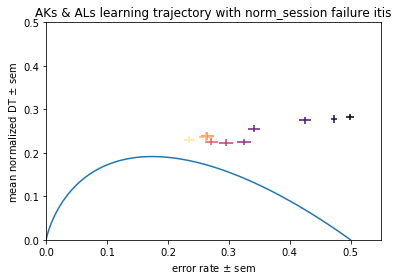

In [714]:
# transform data to plot in OPC space

t0 = 160 # in ms
derr = 2500 # without 300 ms blocking time

mean_norm_dt_binned = []
mean_norm_dt_err_binned = []
error_rate_binned = [1 - i for i in binned_avg_perf['y_bins_mean']]
error_rate_binned_err = binned_avg_perf['y_bins_sem']

if with_itis = True:
    for norm_session in range(len(binned_avg_rt['y_bins_mean'])):
        norm_session_rt = binned_avg_rt['y_bins_mean'][norm_session]
        norm_session_rt_err = binned_avg_rt['y_bins_sem'][norm_session]
        norm_session_iti_err = binned_avg_iti_err['y_bins_mean'][norm_session]
        mean_norm_dt_binned.append((norm_session_rt - t0)/(t0 + derr + norm_session_iti_err))
        mean_norm_dt_err_binned.append(norm_session_rt_err/(t0 + derr + norm_session_iti_err))
else:
    for norm_session in range(len(binned_avg_rt['y_bins_mean'])):
        norm_session_rt = binned_avg_rt['y_bins_mean'][norm_session]
        norm_session_rt_err = binned_avg_rt['y_bins_sem'][norm_session]
        norm_session_iti_err = binned_avg_iti_err['y_bins_mean'][norm_session]
        mean_norm_dt_binned.append((norm_session_rt - t0)/(t0 + derr + norm_session_iti_err))
        mean_norm_dt_err_binned.append(norm_session_rt_err/(t0 + derr + norm_session_iti_err))

opc = calculate_opc()
x_opc = opc['p_err']
y_opc = opc['mean_norm_dt']

x = error_rate_binned
y = mean_norm_dt_binned
xerr = error_rate_binned_err
yerr = mean_norm_dt_err_binned

xmin = 0.0
xmax = 0.55
ymin = 0.0
ymax = 0.5

c = plt.cm.magma(np.linspace(0.,0.95,len(x)))

plt.close()
plt.plot(x_opc, y_opc, label = 'opc')
plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
plt.axis([xmin, xmax, ymin, ymax])
plt.xlabel('error rate $\pm$ sem')
plt.ylabel('mean normalized DT $\pm$ sem')
plt.title('AKs & ALs learning trajectory with norm_session failure itis')
#plt.savefig('opc_during_learning_with_iti_by_session/AKs_ALs_opc_during_learning_with_iti_by_session_0_to_2000ms.pdf')

#### show how iti affects fraction max RR over learning for binned data

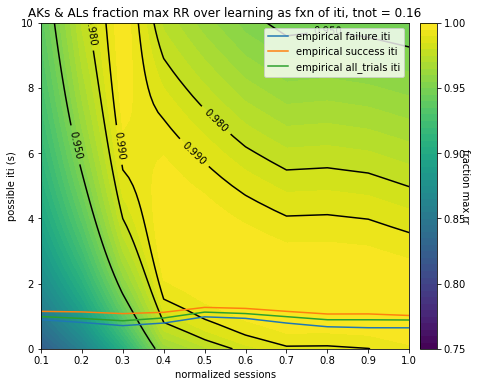

In [854]:
dcorr = 6.10 # without 300 ms blocking time, in seconds
derr = 2.80 # without 300 ms blocking time, in seconds

# ~~~~~~modify tnot here for plotting~~~~~~
tnot = 0.16
    
min_iti = 0
max_iti = 10
step_iti = 0.25
i_t_i = np.arange(min_iti, max_iti + step_iti, step_iti)

x = np.asarray([(i+1)/len(binned_avg_perf['y_bins_mean']) for i in range(len(binned_avg_perf['y_bins_mean']))]) # normalized sessions
y = i_t_i 
X, Y = np.meshgrid(x, y)

binned_frac_max_rr = {}
for i in range(len(x)):
    norm_sesh = x[i]
    perf_sesh = binned_avg_perf['y_bins_mean'][i]
    rt_sesh = binned_avg_rt['y_bins_mean'][i]*0.001
#     iti_err = binned_avg_iti_err['y_bins_mean']
#     iti_corr = binned_avg_iti_corr['y_bins_mean']
    for j in range(len(y)):
        iti = y[j]
        binned_frac_max_rr[(iti, norm_sesh)] = percent_max_rr_iti(rt_sesh, perf_sesh, tnot, dcorr, derr, iti, iti)['fraction_max_rr']
    
binned_frac_max_rr_list = []
for key in sorted(binned_frac_max_rr.keys()):
    binned_frac_max_rr_list.append(binned_frac_max_rr[key])

two_d_plot = np.reshape(np.asarray(binned_frac_max_rr_list), (len(y), len(x)))

plt.close()
plt.figure(1)
plt.figure(figsize = (8,6))

#     plt.subplot(111)
levels = np.linspace(0.75, 1.0, 51) # to create smooth contour spacing
plt.contourf(X, Y, two_d_plot, levels = levels) # filled contour plot with data
ticks = np.linspace(0.5, 1.0, 11)
cbar = plt.colorbar(ticks = ticks, pad = 0.025)
cbar.set_label('fraction max rr', rotation = '270')
#     plt.subplot(111)
levels2 = [0.95, 0.98, 0.99] #np.linspace(0.9, 1.0, 3) # to create contour line at 0.95
ninetyfive = plt.contour(X, Y, two_d_plot, levels = levels2, colors = 'k') # contour line at 0.95
plt.clabel(ninetyfive, levels2)
plt.plot(x, [i*0.001 for i in binned_avg_iti_err['y_bins_mean']], label = 'empirical failure iti')
plt.plot(x, [i*0.001 for i in binned_avg_iti_corr['y_bins_mean']], label = 'empirical success iti')
plt.plot(x, [i*0.001 for i in binned_avg_iti_all['y_bins_mean']], label = 'empirical all_trials iti')
plt.legend()
plt.xlabel('normalized sessions')
plt.ylabel('possible iti (s)')
plt.title('AKs & ALs fraction max RR over learning as fxn of iti, tnot = %.2f' %tnot)
#plt.savefig('AKs_ALs_fraction_max_rr_over_binned_learning_as_fx_iti_tnot=%.2f.pdf' %tnot)

#### show how t_not affects fraction max RR over learning for binned data

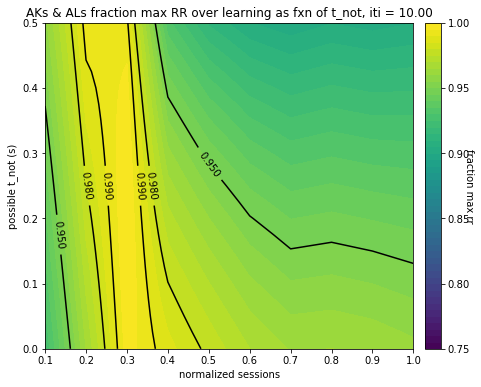

In [837]:
dcorr = 5.80 # without 300 ms blocking time, in seconds
derr = 2.50 # without 300 ms blocking time, in seconds


min_t0 = 0.0
max_t0 = 0.5
step_t0 = 0.025
t_not = np.arange(min_t0, max_t0 + step_t0, step_t0)

# ~~~~~~modify iti here for plotting~~~~~~
iti = 10.0

x = np.asarray([(i+1)/len(binned_avg_perf['y_bins_mean']) for i in range(len(binned_avg_perf['y_bins_mean']))]) # normalized sessions
y = t_not
X, Y = np.meshgrid(x, y)

binned_frac_max_rr = {}
for i in range(len(x)):
    norm_sesh = x[i]
    perf_sesh = binned_avg_perf['y_bins_mean'][i]
    rt_sesh = binned_avg_rt['y_bins_mean'][i]*0.001
#     iti_err = binned_avg_iti_err['y_bins_mean']
#     iti_corr = binned_avg_iti_corr['y_bins_mean']
    for j in range(len(y)):
        tnot = y[j]
        binned_frac_max_rr[(tnot, norm_sesh)] = percent_max_rr_iti(rt_sesh, perf_sesh, tnot, dcorr, derr, iti, iti)['fraction_max_rr']
    
binned_frac_max_rr_list = []
for key in sorted(binned_frac_max_rr.keys()):
    binned_frac_max_rr_list.append(binned_frac_max_rr[key])

two_d_plot = np.reshape(np.asarray(binned_frac_max_rr_list), (len(y), len(x)))

plt.close()
plt.figure(1)
plt.figure(figsize = (8,6))

#     plt.subplot(111)
levels = np.linspace(0.75, 1.0, 51) # to create smooth contour spacing
plt.contourf(X, Y, two_d_plot, levels = levels) # filled contour plot with data
ticks = np.linspace(0.5, 1.0, 11)
cbar = plt.colorbar(ticks = ticks, pad = 0.025)
cbar.set_label('fraction max rr', rotation = '270')
#     plt.subplot(111)
levels2 = [0.95, 0.98, 0.99] #np.linspace(0.9, 1.0, 3) # to create contour line at 0.95
ninetyfive = plt.contour(X, Y, two_d_plot, levels = levels2, colors = 'k') # contour line at 0.95
plt.clabel(ninetyfive, levels2)
# plt.plot(x, [i*0.001 for i in binned_avg_iti_err['y_bins_mean']], label = 'empirical failure iti')
# plt.plot(x, [i*0.001 for i in binned_avg_iti_corr['y_bins_mean']], label = 'empirical success iti')
# plt.plot(x, [i*0.001 for i in binned_avg_iti_all['y_bins_mean']], label = 'empirical all_trials iti')
plt.legend()
plt.xlabel('normalized sessions')
plt.ylabel('possible t_not (s)')
plt.title('AKs & ALs fraction max RR over learning as fxn of t_not, iti = %.2f' %iti)
#plt.savefig('AKs_ALs_fraction_max_rr_over_binned_learning_as_fx_tnot_iti=%.2fs.pdf' %iti)

In [763]:
binned_frac_max_rr[(0.1, 0.0)]

0.87622350990017173

In [798]:
np.shape(rt_sesh)

()

#### calculate fraction max rr when taking session by session itis into account

In [576]:
t0 = 0.16 # in seconds
dcorr = 5.8 # without 300 ms blocking time, in seconds
derr = 2.8 # without 300 ms blocking time, in seconds

animal_frac_max_rr_list = {}
for animal in sorted(perf.keys()):
    for i in range(len(perf[animal])):
        rt_sesh = rt[animal][i]
        perf_sesh = perf[animal][i]
        iti_err_sesh = iti_err[animal][i]*0.001 # convert to s
        iti_corr_sesh = iti_corr[animal][i]*0.001 # convert to s
        try:
            animal_frac_max_rr_sessionlist[animal].append(percent_max_rr_iti(rt_sesh, perf_sesh, tnot, dcorr, derr, iti_corr_sesh, iti_err_sesh)['fraction_max_rr'])
        except KeyError:
            animal_frac_max_rr_sessionlist[animal] = [percent_max_rr_iti(rt_sesh, perf_sesh, tnot, dcorr, derr, iti_corr_sesh, iti_err_sesh)['fraction_max_rr']]

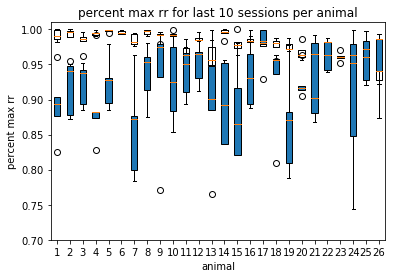

In [587]:
# make a box plot for the trained and/or naive animals
# note that it is very hard to control color, etc with plt.boxplot

d = []
for animal in animal_frac_max_rr_sessionlist.keys():
    d.append((animal_frac_max_rr_sessionlist[animal][-5:], animal_frac_max_rr_sessionlist[animal][:5]))

# d = [fraction_max_rr['AK1'][:2], fraction_max_rr['AK1'][-10:]]

d = sorted(d, reverse = True)

d_trained = [i[0] for i in d]
d_naive = [i[1] for i in d]

plt.boxplot(d_naive, patch_artist = True)
plt.boxplot(d_trained)
plt.ylim(0.7, 1.01)
plt.xlabel('animal')
plt.ylabel('percent max rr')
plt.title('percent max rr for last 10 sessions per animal')
# #plt.savefig('percent_max_rr_last_10_trained_sessions_AK_AL.pdf')

In [575]:
iti_err['AK1'][0]*0.001

0.52915712156862738

In [562]:
mean_norm_dt_err['AK1']

[-0.045846576611233043,
 -0.046448443940276349,
 -0.045013743659110969,
 -0.042612972868644031,
 -0.042936275264322796,
 -0.044958498353850913,
 -0.045107579883706818,
 -0.044133757267933164,
 -0.038919765255007621,
 -0.039162527469643695,
 -0.038674215965580488,
 -0.038601456598592675,
 -0.045563284190157552,
 -0.045796580320671638,
 -0.045917120515898323,
 -0.044489541224229726,
 -0.044536097203472673,
 -0.045784628599074534,
 -0.045143240468543171,
 -0.045416860765728616,
 -0.044421376320830187,
 -0.044837642702995333]

In [504]:
iti_err['AK1']

[10138.090663999999,
 25323.363118749996,
 13323.892037499998,
 10244.051896656534,
 7285.7892863157895,
 3961.8631522309711,
 4634.0631969696969,
 5513.0870363636377,
 9961.4810652173928,
 8257.4842861736342,
 19304.598020512822,
 7567.389975,
 4010.8217154811723,
 7291.208628048782,
 7995.9857149758454,
 3595.4939568965524,
 12255.315618055556,
 17144.359653594773,
 15862.025327044032,
 9038.95872826087,
 18984.845433962266,
 12913.783903409092]

12913.7839034
135255.165
0.881290322581


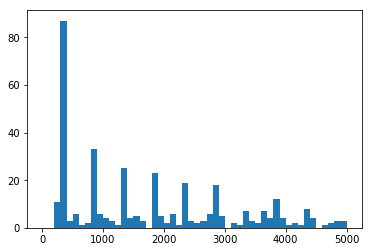

In [505]:
plt.hist(adjusted_itis_by_animal_by_session['AK1']['AK1_170712.mwk']['success'], bins = 50, range = (0,5000))
print np.mean(adjusted_itis_by_animal_by_session['AK1']['AK1_170712.mwk']['failure'])
print max(adjusted_itis_by_animal_by_session['AK1']['AK1_170630.mwk']['failure'])
print len(adjusted_itis_by_animal_by_session['AK1']['AK1_170630.mwk']['success'])/len(adjusted_itis_by_animal_by_session['AK1']['AK1_170630.mwk']['all_trials'])

In [448]:
animal = 'AK1'

t0 = 0.16

error_rate = perf[animal]
dt = [i - t0 for i in rt[animal]]



dt_mean_norm = 

print rt[animal]

[1.3478686253298153, 1.2792591030303033, 1.2154295727002966, 0.94325014655172412, 0.85670976755852846, 0.87228296020761242, 0.82376382649842272, 0.81429333367139956, 0.80750919493670881, 0.76799889816124456, 0.78543672285714283, 0.74443258675078872, 0.72130919175455421, 0.71951147604485222, 0.7630789133663366, 0.71369761470588244, 0.66675230683403064, 0.67350449162011172, 0.67069667342342343, 0.67142893421052652, 0.68762545278450349, 0.810969694143167]


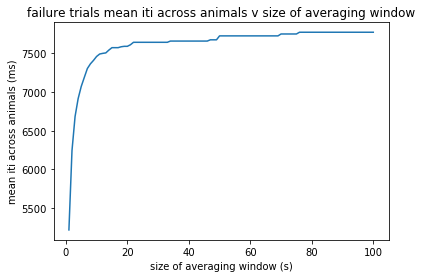

In [297]:
trial_type = 'failure'
step = 100000
averaging_intervals = np.arange(0, 10000000 + step, step)
all_mean = []
all_std = []
for animal in adjusted_itis_by_animal.keys():
    animal_mean = []
    for interval in averaging_intervals:
        animal_mean.append(np.mean([i for i in adjusted_itis_by_animal[animal][trial_type] if 0 < i < interval]))
    all_mean.append(animal_mean)
    
all_mean
    
all_mean_mean = np.mean(all_mean, axis = 0)
all_mean_std = np.std(all_mean, axis = 0)


x = range(len(all_mean_mean))
y = all_mean_mean
yerr = all_mean_std
plt.errorbar(x = x, y = y, yerr = 0)
plt.ylabel('mean iti across animals (ms)')
plt.xlabel('size of averaging window (s)')
plt.title('%s trials mean iti across animals v size of averaging window' %trial_type)

In [296]:
(10000000*0.001)/60

166.66666666666666

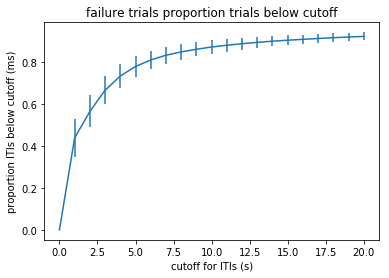

In [216]:
trial_type = 'failure'
step = 1000
max_ = 20000
cutoffs = np.arange(0, max_ + step, step)
all_prop_below_cutoff = []
all_std = []
for animal in adjusted_itis_by_animal.keys():
    prop_below_cutoff = []
    for cutoff in cutoffs:
        below_cutoff = [i for i in adjusted_itis_by_animal[animal][trial_type][-5000:] if 0 < i < cutoff]
        prop_below_cutoff.append(len(below_cutoff)/len(adjusted_itis_by_animal[animal][trial_type][-5000:]))
    all_prop_below_cutoff.append(prop_below_cutoff)
    
all_pbc_mean = np.mean(all_prop_below_cutoff, axis = 0)
all_pbc_std = np.std(all_prop_below_cutoff, axis = 0)


x = range(len(all_pbc_mean))
y = all_pbc_mean
yerr = all_pbc_std
plt.errorbar(x = x, y = y, yerr = yerr)
plt.ylabel('proportion ITIs below cutoff (ms)')
plt.xlabel('cutoff for ITIs (s)')
plt.title('%s trials proportion trials below cutoff' %trial_type)

In [160]:
trunc_data_ak12 = [i for i in adjusted_itis_by_animal['AK9']['success'] if i < 500]
np.mean(trunc_data_ak12)

234.1375222141298

In [315]:
len([i for i in adjusted_itis_by_animal['AK9']['all_trials'] if i > 4000])

7582

In [323]:
len(results_AK_AL['AK9']['outcome_by_trial'])

21590

In [325]:
len([i for i in results_AK_AL['AK9']['outcome_by_trial'] if i == 'ignore'])

0

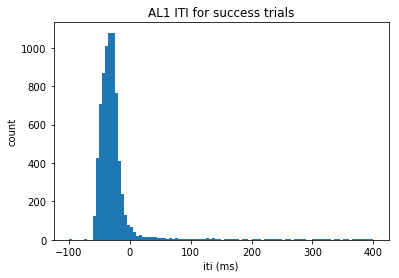

In [429]:
animal = 'AL1'
trial_type = 'success'

range_ = (-100, 400)
bins = 100
plt.hist(adjusted_itis_by_animal[animal][trial_type], bins = bins, range = range_)
plt.title('%s ITI for %s trials' %(animal, trial_type))
plt.xlabel('iti (ms)')
plt.ylabel('count')
# #plt.savefig('AK9_iti_all_trials.pdf')
#plt.savefig('%s_iti_%s_trials_%d_to_%d.pdf' %(animal, trial_type, range_[0], range_[1]))
# plt.close()

In [512]:
len([i for i in adjusted_itis_by_animal['AK3']['all_trials'] if i < 0])

630

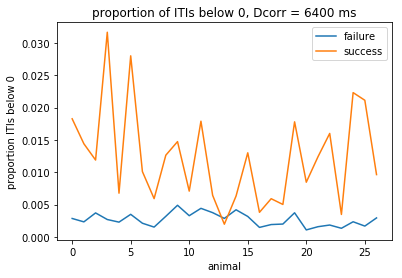

In [576]:
# looking at proportion of ITIs 'below 0'

fail_below_0 = []
succ_below_0 = []
mean_rt_throughout = []
std_rt_throughout = []
animal_order = []
for animal in sorted(adjusted_itis_by_animal.keys()):
    animal_order.append(animal)
    fail_below_0.append(len([i for i in adjusted_itis_by_animal[animal]['failure'] if i < 0]) / len(adjusted_itis_by_animal[animal]['all_trials']))
    succ_below_0.append(len([i for i in adjusted_itis_by_animal[animal]['success'] if i < 0]) / len(adjusted_itis_by_animal[animal]['all_trials']))
    mean_rt_throughout.append(np.mean(results_AK_AL[animal]['rt_by_trial']))
    std_rt_throughout.append(np.std(results_AK_AL[animal]['rt_by_trial']))
    
plt.plot(fail_below_0, label = 'failure')
plt.plot(succ_below_0, label = 'success')
plt.legend()
plt.xlabel('animal')
plt.ylabel('proportion ITIs below 0')
plt.title('proportion of ITIs below 0, Dcorr = 6400 ms')
# #plt.savefig('proportion_itis_below_0_Dcorr_6400.pdf')

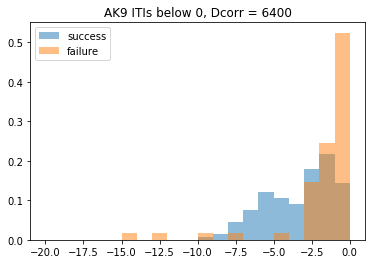

In [574]:
animal = 'AK9'

x1 = [i for i in adjusted_itis_by_animal[animal]['failure'] if i < 0]
x2 = [i for i in adjusted_itis_by_animal[animal]['success'] if i < 0]


range_ = (-20, 0)
bins = 20

plt.hist(x2, range = range_, bins = bins, alpha = 0.5, normed = True, label = 'success')
plt.hist(x1, range = range_, bins = bins, alpha = 0.5, normed = True, label = 'failure')
plt.title('%s ITIs below 0, Dcorr = 6400' %animal)
plt.legend()
#plt.savefig('%s_hist_itis_below_0_succ_fail_Dcorr_6400_%d_to_%d.pdf' %(animal, range_[0], range_[1]))

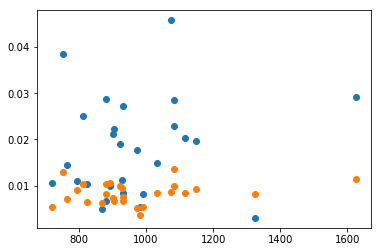

In [447]:
plt.plot(mean_rt_throughout, succ_below_0, linestyle = ' ', marker = 'o')
plt.plot(mean_rt_throughout, fail_below_0, linestyle = ' ', marker = 'o')

In [587]:
np.median([i/j for (i,j) in zip(succ_below_0, fail_below_0)])

3.9565217391304346

In [588]:
fail_below_0[0]/succ_below_0[0]

0.1565934065934066

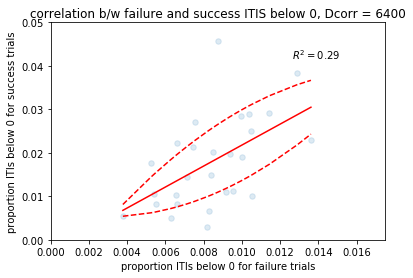

In [469]:
xd = fail_below_0
yd = succ_below_0

# slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
# line = slope*x + intercept

# sort the data
reorder = sorted(range(len(xd)), key = lambda ii: xd[ii])
xd = [xd[ii] for ii in reorder]
yd = [yd[ii] for ii in reorder]

# make the scatter plot
plt.scatter(xd, yd, s=30, alpha=0.15, marker='o')

# determine best fit line
par = np.polyfit(xd, yd, 1, full=True)

slope=par[0][0]
intercept=par[0][1]
xl = [min(xd), max(xd)]
yl = [slope*xx + intercept  for xx in xl]

# coefficient of determination, plot text
variance = np.var(yd)
residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
Rsqr = np.round(1-residuals/variance, decimals=2)
plt.text(.9*max(xd)+.1*min(xd),.9*max(yd)+.1*min(yd),'$R^2 = %0.2f$'% Rsqr, fontsize=10)

plt.xlabel("proportion ITIs below 0 for failure trials")
plt.ylabel("proportion ITIs below 0 for success trials")
plt.title('correlation b/w failure and success ITIS below 0, Dcorr = 6400')

# error bounds
yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)]
par = np.polyfit(xd, yerr, 2, full=True)

yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(xd,yd)]
yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(xd,yd)]

plt.plot(xl, yl, '-r')
plt.plot(xd, yerrLower, '--r')
plt.plot(xd, yerrUpper, '--r')
plt.xlim(0, 0.0175)
plt.ylim(0, 0.05)
#plt.savefig('corr_iti_below_0_for_fail_succ_trials_Dcorr_6400.pdf')
plt.show()

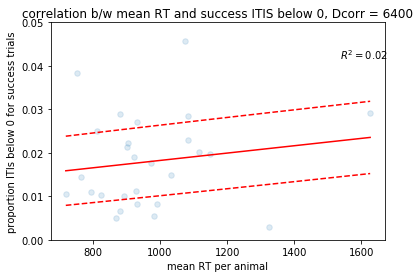

In [471]:
xd = mean_rt_throughout
yd = succ_below_0

# slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
# line = slope*x + intercept

# sort the data
reorder = sorted(range(len(xd)), key = lambda ii: xd[ii])
xd = [xd[ii] for ii in reorder]
yd = [yd[ii] for ii in reorder]

# make the scatter plot
plt.scatter(xd, yd, s=30, alpha=0.15, marker='o')

# determine best fit line
par = np.polyfit(xd, yd, 1, full=True)

slope=par[0][0]
intercept=par[0][1]
xl = [min(xd), max(xd)]
yl = [slope*xx + intercept  for xx in xl]

# coefficient of determination, plot text
variance = np.var(yd)
residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
Rsqr = np.round(1-residuals/variance, decimals=2)
plt.text(.9*max(xd)+.1*min(xd),.9*max(yd)+.1*min(yd),'$R^2 = %0.2f$'% Rsqr, fontsize=10)

plt.xlabel('mean RT per animal')
plt.ylabel('proportion ITIs below 0 for success trials')
plt.title('correlation b/w mean RT and success ITIS below 0, Dcorr = 6400')

# error bounds
yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)]
par = np.polyfit(xd, yerr, 2, full=True)

yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(xd,yd)]
yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(xd,yd)]

plt.plot(xl, yl, '-r')
plt.plot(xd, yerrLower, '--r')
plt.plot(xd, yerrUpper, '--r')
# plt.xlim(0, 0.0175)
plt.ylim(0, 0.05)
#plt.savefig('corr_mean_rt_and_iti_below_0_for_succ_trials_Dcorr_6400.pdf')
plt.show()

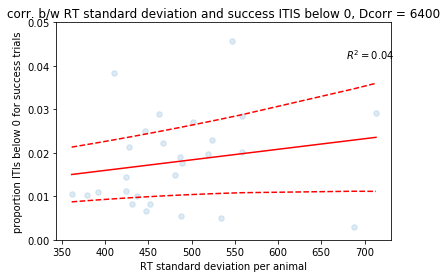

In [473]:
xd = std_rt_throughout
yd = succ_below_0

# slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
# line = slope*x + intercept

# sort the data
reorder = sorted(range(len(xd)), key = lambda ii: xd[ii])
xd = [xd[ii] for ii in reorder]
yd = [yd[ii] for ii in reorder]

# make the scatter plot
plt.scatter(xd, yd, s=30, alpha=0.15, marker='o')

# determine best fit line
par = np.polyfit(xd, yd, 1, full=True)

slope=par[0][0]
intercept=par[0][1]
xl = [min(xd), max(xd)]
yl = [slope*xx + intercept  for xx in xl]

# coefficient of determination, plot text
variance = np.var(yd)
residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
Rsqr = np.round(1-residuals/variance, decimals=2)
plt.text(.9*max(xd)+.1*min(xd),.9*max(yd)+.1*min(yd),'$R^2 = %0.2f$'% Rsqr, fontsize=10)

plt.xlabel('RT standard deviation per animal')
plt.ylabel('proportion ITIs below 0 for success trials')
plt.title('corr. b/w RT standard deviation and success ITIS below 0, Dcorr = 6400')

# error bounds
yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)]
par = np.polyfit(xd, yerr, 2, full=True)

yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(xd,yd)]
yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(xd,yd)]

plt.plot(xl, yl, '-r')
plt.plot(xd, yerrLower, '--r')
plt.plot(xd, yerrUpper, '--r')
# plt.xlim(0, 0.0175)
plt.ylim(0, 0.05)
#plt.savefig('corr_rt_std_and_iti_below_0_for_succ_trials_Dcorr_6400.pdf')
plt.show()

In [511]:
dataset = results_AK_AL
succ_min_iti = 6450 #ms
fail_min_iti = 3150 #ms

adjusted_itis_by_animal = {}
for animal in dataset.keys():
    adjusted_itis = {}
    previous_rts = [] # collect the previous trial's RT, which determines the present trial's ITI
    success_itis = []
    failure_itis = []
#     ignore_itis = []
    all_itis = []
    for trial in range(len(dataset[animal]['iti_by_trial'])):

        if trial == 0:
            pass
        elif trial >= 1:
            previous_rts.append(dataset[animal]['rt_by_trial'][trial - 1])
            if dataset[animal]['outcome_by_trial'][trial - 1] == 'success':
                success_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001 - succ_min_iti) # must convert itis to ms
                all_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001 - succ_min_iti)
            elif dataset[animal]['outcome_by_trial'][trial - 1] == 'failure':
                failure_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001 - fail_min_iti)
                all_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001 - fail_min_iti)
            # currently no ignore trials taken into account in the pickle files
#             elif dataset[animal]['outcome_by_trial'][trial - 1] == 'ignore':
#                 ignore_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001)
#                 all_itis.append(dataset[animal]['iti_by_trial'][trial]*0.001)
            else:
                pass
        adjusted_itis['previous_rt'] = previous_rts
        adjusted_itis['success'] = success_itis
        adjusted_itis['failure'] = failure_itis
#         adjusted_itis['ignore'] = ignore_itis
        adjusted_itis['all_trials'] = all_itis
        
    adjusted_itis_by_animal[animal] = adjusted_itis

In [514]:
# collect trials with ITIs below 0, and their accompanying previous trial RTs

adjusted_itis_by_animal_below_0 = {}
for animal in sorted(adjusted_itis_by_animal.keys()):
    adjusted_itis_below_0 = {}
    ordered_succ_below_0 = []
    ordered_fail_below_0 = []
    ordered_all_below_0 = []
    ordered_succ_previous_rt_below_0 = []
    ordered_fail_previous_rt_below_0 = []
    ordered_all_previous_rt_below_0 = []
    for i in range(len(adjusted_itis_by_animal[animal]['all_trials'])):
        if adjusted_itis_by_animal[animal]['all_trials'][i] < 0:
            ordered_all_below_0.append(adjusted_itis_by_animal[animal]['all_trials'][i])
            ordered_all_previous_rt_below_0.append(adjusted_itis_by_animal[animal]['previous_rt'][i])
        else:
            pass
    for i in range(len(adjusted_itis_by_animal[animal]['success'])):
        if adjusted_itis_by_animal[animal]['success'][i] < 0:
            ordered_succ_below_0.append(adjusted_itis_by_animal[animal]['success'][i])
            ordered_succ_previous_rt_below_0.append(adjusted_itis_by_animal[animal]['previous_rt'][i])
        else:
            pass 
    for i in range(len(adjusted_itis_by_animal[animal]['failure'])):
        if adjusted_itis_by_animal[animal]['failure'][i] < 0:
            ordered_fail_below_0.append(adjusted_itis_by_animal[animal]['failure'][i])
            ordered_fail_previous_rt_below_0.append(adjusted_itis_by_animal[animal]['previous_rt'][i])
        else:
            pass 
    
    adjusted_itis_below_0['ordered_succ_below_0'] = ordered_succ_below_0
    adjusted_itis_below_0['ordered_fail_below_0'] = ordered_fail_below_0
    adjusted_itis_below_0['ordered_all_below_0'] = ordered_all_below_0
    adjusted_itis_below_0['ordered_succ_previous_rt_below_0'] = ordered_succ_previous_rt_below_0
    adjusted_itis_below_0['ordered_fail_previous_rt_below_0'] = ordered_fail_previous_rt_below_0
    adjusted_itis_below_0['ordered_all_previous_rt_below_0'] = ordered_all_previous_rt_below_0
    adjusted_itis_by_animal_below_0[animal] = adjusted_itis_below_0

(-100, 10)

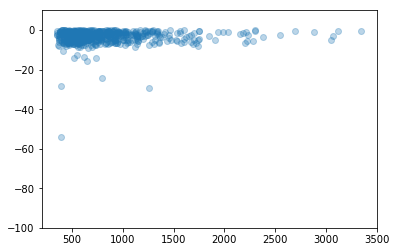

In [515]:
xtest = adjusted_itis_by_animal_below_0['AK3']['ordered_all_previous_rt_below_0']
ytest = adjusted_itis_by_animal_below_0['AK3']['ordered_all_below_0']

plt.plot(xtest, ytest, 'o', alpha = 0.3)
plt.ylim(-100, 10)